In [1]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
print(tf.__version__)

2.10.0


In [5]:

uninfected_dir = r'E:\BasicSR-master\BasicSR-master\results\RCAN_BIX4-official\visualization\val_set5'
parasitized_dir = r'E:\BasicSR-master\BasicSR-master\results\RCAN_BIX4-official_archived_20240406_202800\visualization\val_set5'

uninfected_count = len([name for name in os.listdir(uninfected_dir) if os.path.isfile(os.path.join(uninfected_dir, name))])
parasitized_count = len([name for name in os.listdir(parasitized_dir) if os.path.isfile(os.path.join(parasitized_dir, name))])
all_image = uninfected_count + parasitized_count

print(f'dataset contains {all_image} images.')
print(f'Uninfected dataset contains {uninfected_count} images.')
print(f'Parasitized dataset contains {parasitized_count} images.')

dataset contains 27558 images.
Uninfected dataset contains 13779 images.
Parasitized dataset contains 13779 images.


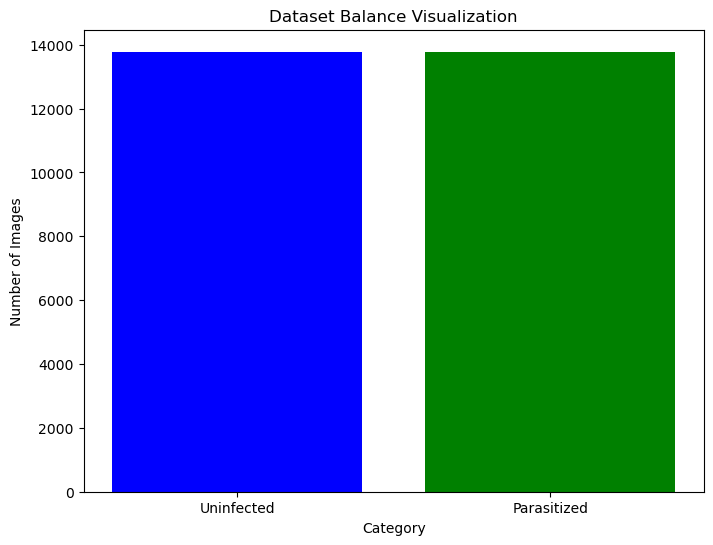

In [6]:
categories = ['Uninfected', 'Parasitized']
counts = [uninfected_count, parasitized_count]

plt.figure(figsize=(8, 6))
plt. bar(categories, counts, color=['blue', 'green'])
plt.title('Dataset Balance Visualization')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

In [7]:
# build diretories of train, val, test
base_dir = r'E:\MV-Code\Datasets\archive\SR-Base_datasets'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    os.makedirs(os.path.join(directory, 'uninfected'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'parasitized'), exist_ok=True)

# cell labels
cell_labels = []

# cells image
cell_images = []

for class_dir, label in [(uninfected_dir, 'uninfected'), (parasitized_dir, 'parasitized')]:
    for filename in os.listdir(class_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            cell_images.append(os.path.join(class_dir, filename))
            cell_labels.append(label)

# convert into numpy array
data = np.array(cell_images)
labels = np.array(cell_labels)

# Split datasets into 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [8]:
def copy_files(X, y, dest_dir):
    for filepath, label in zip(X, y):
        label_str = str(label)
        target_folder = os.path.join(dest_dir, label_str)  # Added closing parenthesis here
        os.makedirs(target_folder, exist_ok=True)
        filename = os.path.basename(filepath)
        target_path = os.path.join(target_folder, filename)
        shutil.copy(filepath, target_path)

copy_files(X_train, y_train, train_dir)
copy_files(X_val, y_val, val_dir)
copy_files(X_test, y_test, test_dir)

In [4]:
# Get train, val, test path 
base_dir = r'E:\MV-Code\Datasets\archive\SR-Base_datasets'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
# test_dir = os.path.join(base_dir, 'test')
test_dir =r"E:\MV-Code\Datasets\archive\Base_datasets\test"

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    shear_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
img_width = 224
img_height = 224

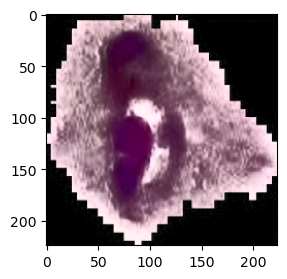

In [6]:
image_path = r"C:\Users\61640\Desktop\op2.png"
augmentation_image = tf.keras.preprocessing.image.load_img(image_path, target_size= (img_width,img_height))
img_tensor = tf.keras.preprocessing.image.img_to_array(augmentation_image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
#Plots image
plt.figure(figsize=(3,3))
plt.imshow(img_tensor[0])
plt.show()

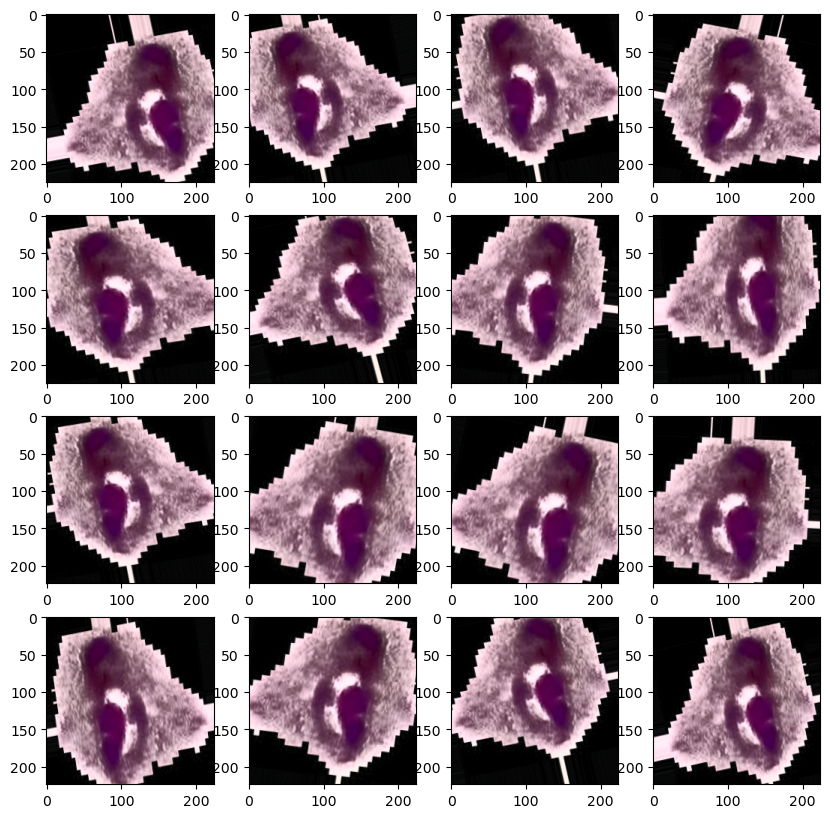

In [9]:
#Creates our batch of one image
pic = train_datagen.flow(img_tensor*255, batch_size =1)
plt.figure(figsize=(10, 10))
#Plots our figures
for i in range(1,17):
    plt.subplot(4, 4, i)
    batch = pic.next()
    image_ = batch[0]
    plt.imshow(image_)
plt.show()

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 19290 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


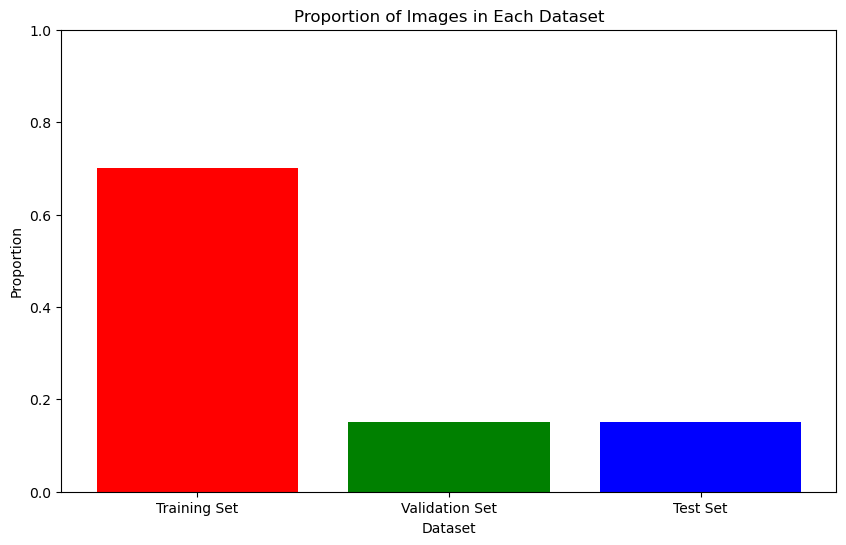

In [74]:
# Assuming the following variables are defined based on the dataset generators you have:
num_train_images = train_generator.samples
num_val_images = validation_generator.samples
num_test_images = test_generator.samples

# Calculate the total number of images
total_images = num_train_images + num_val_images + num_test_images

# Calculate proportions
proportion_train = num_train_images / total_images
proportion_val = num_val_images / total_images
proportion_test = num_test_images / total_images

# Labels for the bars
dataset_labels = ['Training Set', 'Validation Set', 'Test Set']

# Proportions for each dataset
proportions = [proportion_train, proportion_val, proportion_test]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, proportions, color=['red', 'green', 'blue'])
plt.xlabel('Dataset')
plt.ylabel('Proportion')
plt.title('Proportion of Images in Each Dataset')
plt.ylim(0, 1)  # Proportions range from 0 to 1
plt.show()

In [15]:
!pip install tqdm

In [11]:
import hashlib
from tqdm import tqdm

def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def generate_hashes(directory):
    hashes = set()
    for subdir, dirs, files in os.walk(directory):
        for file in tqdm(files):  # tqdm可以在这里用来显示进度
            file_path = os.path.join(subdir, file)
            if os.path.isfile(file_path):  # 确保是文件
                hash_value = file_hash(file_path)  # 使用新的变量名
                hashes.add(hash_value)
    return hashes

# 适当地调用generate_hashes函数
train_hashes = generate_hashes(train_dir)
val_hashes = generate_hashes(val_dir)
test_hashes = generate_hashes(test_dir)

# 检查重复项
duplicates = train_hashes.intersection(val_hashes) | train_hashes.intersection(test_hashes) | val_hashes.intersection(test_hashes)

print(f"Found {len(duplicates)} duplicates across the datasets.")


0it [00:00, ?it/s]
100%|██████████| 9645/9645 [00:08<00:00, 1178.55it/s]
0it [00:00, ?it/s]
100%|██████████| 2067/2067 [00:01<00:00, 1197.30it/s]
0it [00:00, ?it/s]
100%|██████████| 2067/2067 [00:01<00:00, 1277.49it/s]

Found 0 duplicates across the datasets.


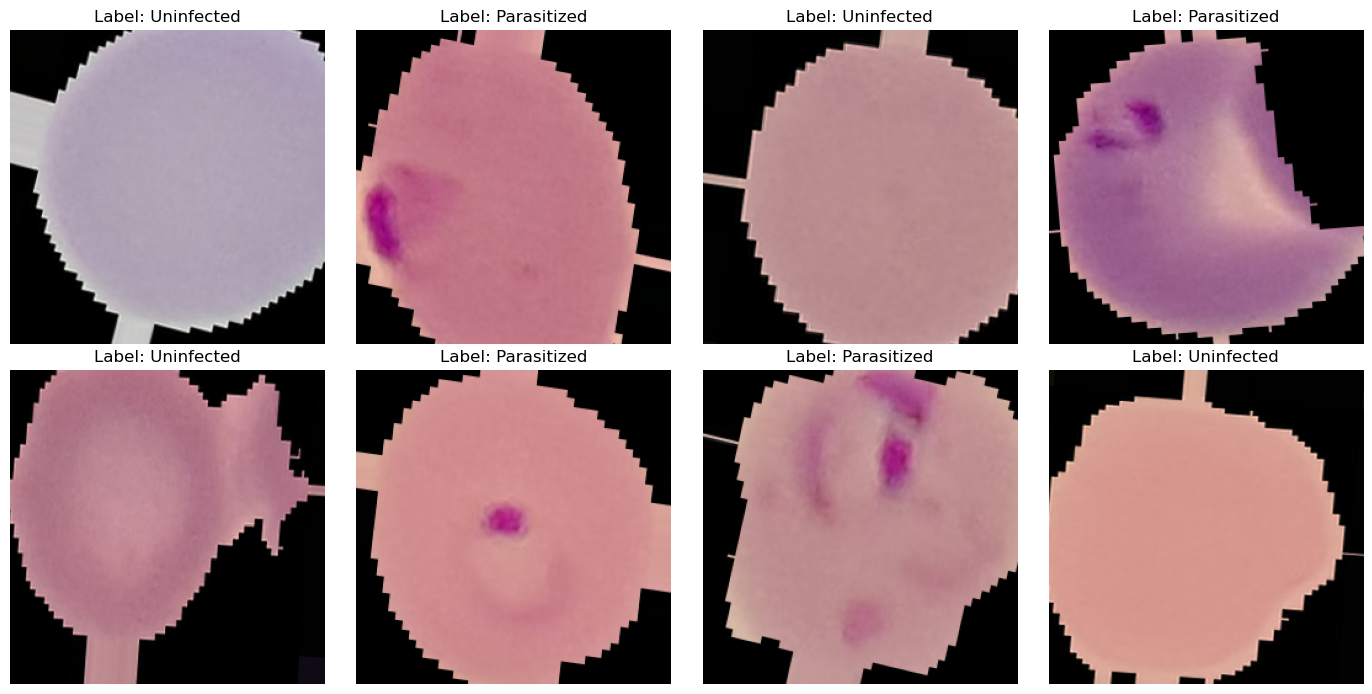

In [12]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(14, 7))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i])
    plt.title('Label: ' + ('Uninfected' if y_batch[i] == 1 else 'Parasitized'))
    plt.axis('off')


plt.tight_layout()
plt.show()

In [38]:
import tensorflow as tf
from tensorflow.keras import backend as K
# Define a loss function
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)  
    bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    return tf.reduce_mean(bce)

# Define a accuracy function
def custom_accuracy(y_true, y_pred):
    threshold = 0.5
    y_pred_thresholded = K.cast(y_pred > threshold, K.floatx())
    correct_predictions = K.equal(y_true, y_pred_thresholded)
    return K.mean(K.cast(correct_predictions, K.floatx()))

In [39]:
# Attention Mechanism
def SEBlock(input_tensor, ratio=8):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    x = multiply([init, se])
    return x

# First Position of SE in model 1

In [40]:
def Classifier_CNN_1_SE1(input_size=(256,256,3), l2_reg=0.00001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    se1 = SEBlock(bn1)
    pool1 = MaxPooling2D(pool_size=(2,2))(se1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    se2 = SEBlock(bn2)
    pool2 = MaxPooling2D(pool_size=(2,2))(se2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
    se3 = SEBlock(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(se3)
    bn4  = BatchNormalization()(conv4)
    se4 = SEBlock(bn4) 
    pool3 = MaxPooling2D(pool_size=(2,2))(se4)
    
    # Fully connected layers
#     flat = Flatten()(pool3)

    gap = GlobalAveragePooling2D()(pool3)
#     dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    dense1 = Dense(256, activation='relu')(gap)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

In [41]:
model1_se1 = Classifier_CNN_1_SE1(input_size=(256,256,3), l2_reg=0.00001)
model1_se1.summary()

from keras.utils.vis_utils import plot_model
plot_model(model1_se1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_se1.compile(optimizer=optimizer, 
                # loss=custom_binary_crossentropy, 
                # metrics=[custom_accuracy])
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 256, 256, 32  128        ['conv2d_8[0][0]']               
 rmalization)                   )                                                           

In [28]:
history_se1 = model1_se1.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 3,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/3


ValueError: in user code:

    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "D:\Software\anaconda\envs\tfff\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


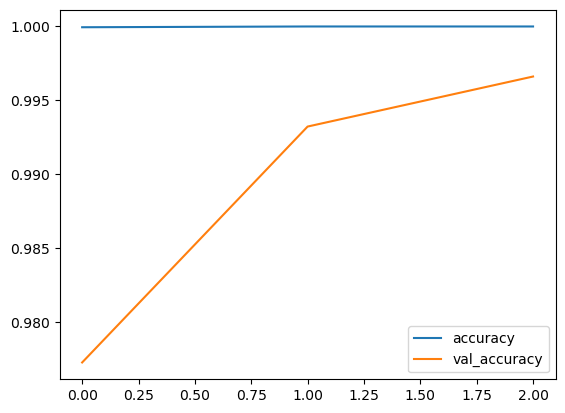

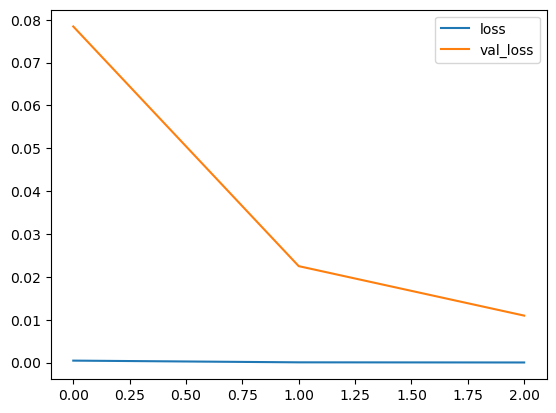

In [49]:
plt.plot(history_se1.history['accuracy'], label='accuracy')
plt.plot(history_se1.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se1.history['loss'], label='loss')
plt.plot(history_se1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [84]:
model1_se1.save('model1_se1.h5')

test_loss, test_accuracy = model1_se1.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 7s 50ms/step - loss: 33.0230 - accuracy: 0.5000
Test Accuracy: 0.5
Test loss: 33.02296829223633


# # Second Position of SE in model 1

In [23]:
def Classifier_CNN_1_SE2(input_size=(64,64,3), l2_reg=0.00001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(bn3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    # SE block after all conv and pooling layers
    se_final = SEBlock(pool4) 
    
    # Fully connected layers
    gap = GlobalAveragePooling2D()(se_final)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

In [24]:
model1_se2 = Classifier_CNN_1_SE2(input_size=(64,64,3), l2_reg=0.00001)
model1_se2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 64, 64, 32)  128         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 32, 32, 32)  0           ['batch_normalization_4[0][

In [25]:
# from keras.utils.vis_utils import plot_model
# plot_model(model1_se1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_se2.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2 = model1_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 38s 62ms/step - loss: 0.4057 - custom_accuracy: 0.8162 - val_loss: 1.0633 - val_custom_accuracy: 0.5909
Epoch 2/15
603/603 [==============================] - 37s 62ms/step - loss: 0.2118 - custom_accuracy: 0.9227 - val_loss: 0.2021 - val_custom_accuracy: 0.9190
Epoch 3/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1731 - custom_accuracy: 0.9381 - val_loss: 0.1653 - val_custom_accuracy: 0.9421
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1563 - custom_accuracy: 0.9457 - val_loss: 0.1797 - val_custom_accuracy: 0.9392
Epoch 5/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1502 - custom_accuracy: 0.9473 - val_loss: 0.1482 - val_custom_accuracy: 0.9462
Epoch 6/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1448 - custom_accuracy: 0.9510 - val_loss: 0.1293 - val_custom_accuracy: 0.9536
Epoch 7/15
603/603 [==============================] 

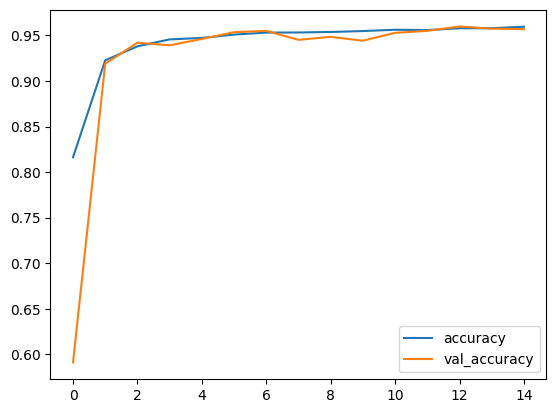

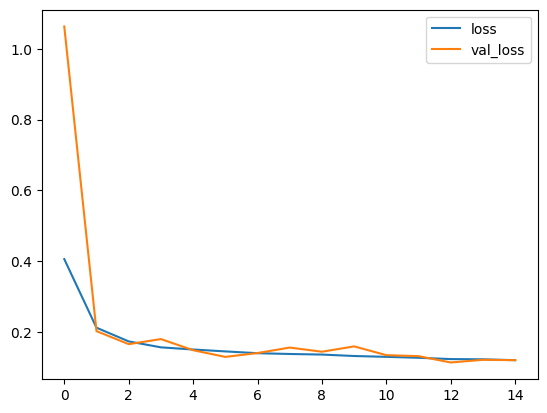

130/130 [==============================] - 4s 27ms/step - loss: 0.1049 - custom_accuracy: 0.9661
Test Accuracy: 0.9661057591438293
Test loss: 0.10487961769104004


In [26]:
plt.plot(history_se2.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2.history['loss'], label='loss')
plt.plot(history_se2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


model1_se2.save('model1_se2.h5')

test_loss, test_accuracy = model1_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )


In [56]:
model1 = load_model('model1_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

test_loss, test_accuracy = model1.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 4s 27ms/step - loss: 0.1049 - custom_accuracy: 0.9661
Test Accuracy: 0.9661057591438293
Test loss: 0.10487961769104004


In [57]:
predY = model1.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 26ms/step


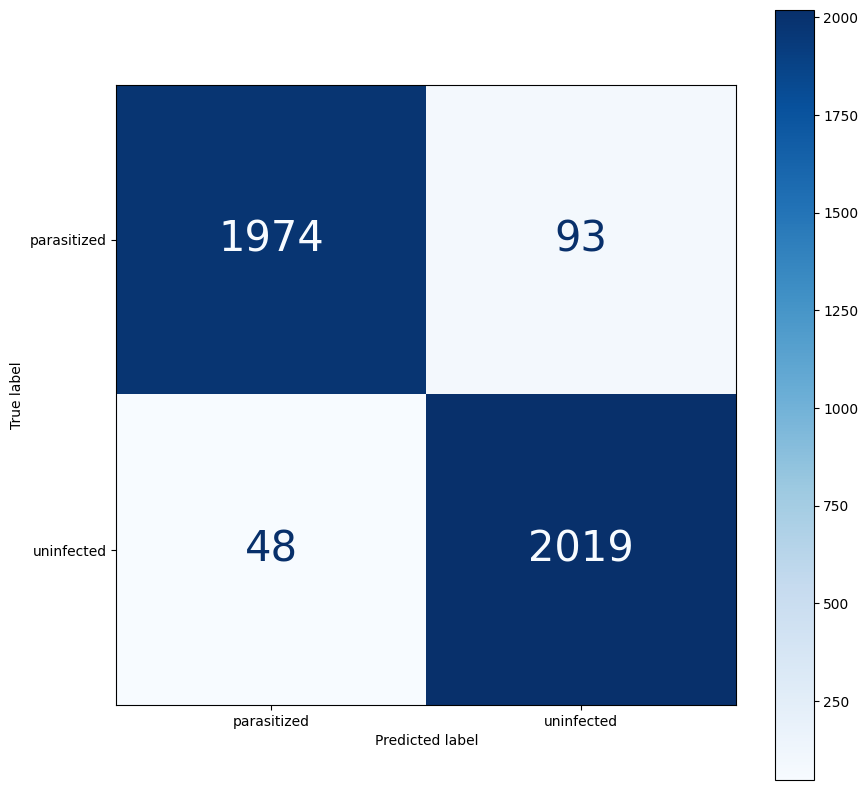

Sensitivity: 0.97677793904209, Specificity: 0.9550072568940493


In [58]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [59]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.976261  0.955007  0.965517  2067.000000
uninfected     0.955966  0.976778  0.966260  2067.000000
accuracy       0.965893  0.965893  0.965893     0.965893
macro avg      0.966114  0.965893  0.965889  4134.000000
weighted avg   0.966114  0.965893  0.965889  4134.000000

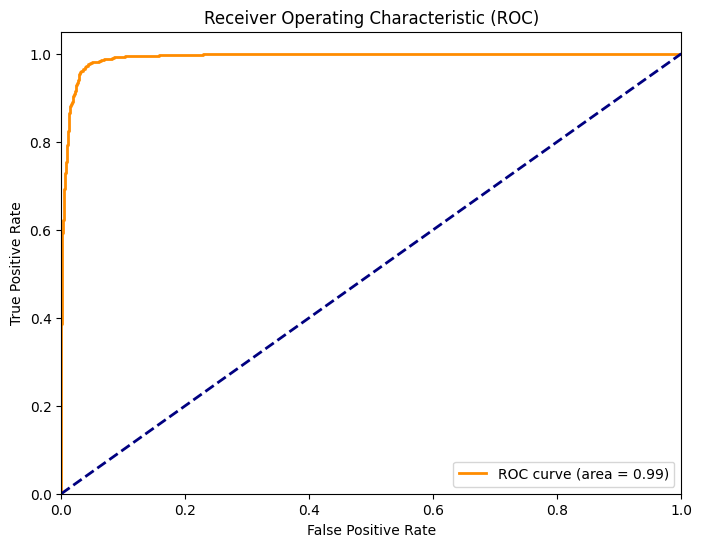

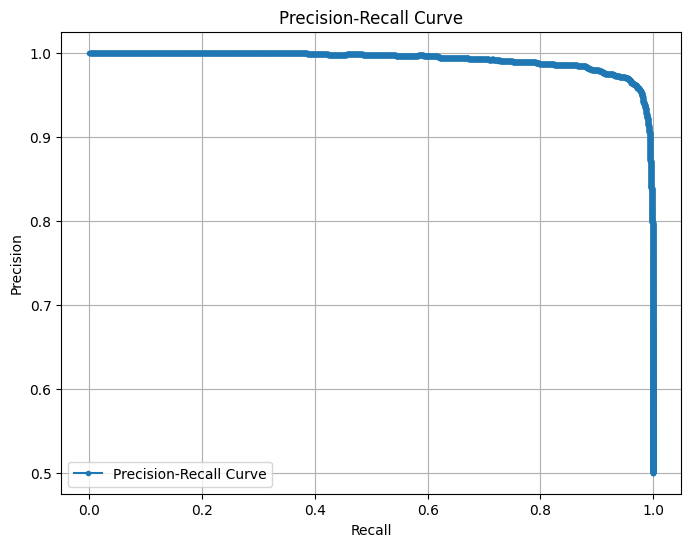

In [60]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Third Position of SE in model 1# 

In [49]:
def Classifier_CNN_1_SE3(input_size=(64,64,3), l2_reg=0.00001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    se1 = SEBlock(pool1)  
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(se1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    se2 = SEBlock(pool2)  
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(se2)
    bn3 = BatchNormalization()(conv3)
    se3 = SEBlock(bn3)  
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(se3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    se4 = SEBlock(pool4)  
    
#     # Fully connected layers
#     flat = Flatten()(se4)

    gap = GlobalAveragePooling2D()(se4)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

In [50]:
model1_se3 = Classifier_CNN_1_SE3(input_size=(64,64,3), l2_reg=0.00001)
model1_se3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 32)   896         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_27 (BatchN  (None, 64, 64, 32)  128         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 32, 32, 32)  0           ['batch_normalization_27[0]

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_se3.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se3 = model1_se3.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 63ms/step - loss: 0.3845 - custom_accuracy: 0.8257 - val_loss: 0.6910 - val_custom_accuracy: 0.7088
Epoch 2/15
603/603 [==============================] - 37s 62ms/step - loss: 0.2069 - custom_accuracy: 0.9271 - val_loss: 0.1772 - val_custom_accuracy: 0.9317
Epoch 3/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1762 - custom_accuracy: 0.9399 - val_loss: 0.1640 - val_custom_accuracy: 0.9410
Epoch 4/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1623 - custom_accuracy: 0.9450 - val_loss: 0.1694 - val_custom_accuracy: 0.9421
Epoch 5/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1526 - custom_accuracy: 0.9480 - val_loss: 0.1669 - val_custom_accuracy: 0.9452
Epoch 6/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1460 - custom_accuracy: 0.9510 - val_loss: 0.1425 - val_custom_accuracy: 0.9531
Epoch 7/15
603/603 [==============================] 

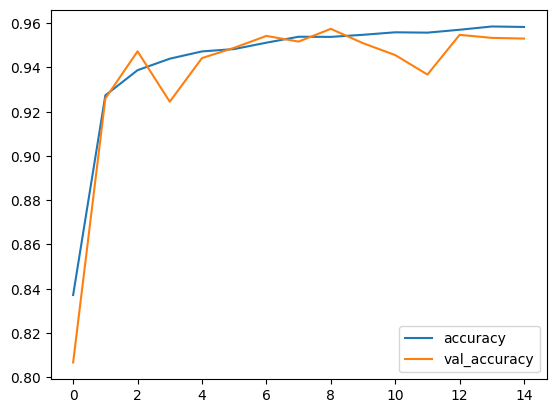

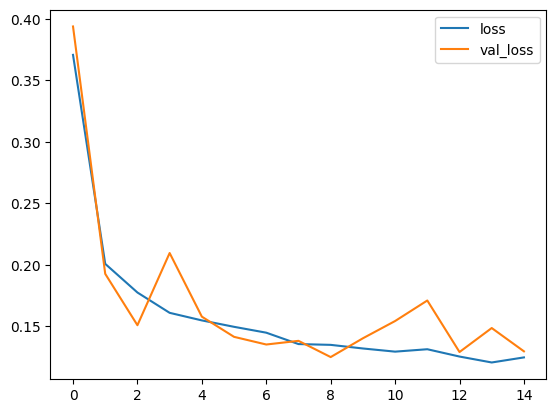

130/130 [==============================] - 4s 28ms/step - loss: 0.1313 - custom_accuracy: 0.9570
Test Accuracy: 0.9569711685180664
Test loss: 0.13130579888820648


In [52]:
plt.plot(history_se2.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2.history['loss'], label='loss')
plt.plot(history_se2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


model1_se3.save('model1_se3.h5')

test_loss, test_accuracy = model1_se3.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 


# First Position of SE in model 2# 

In [53]:
def Classifier_CNN_2_SE1(input_size=(64,64,3), l2_reg=0.00001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = SEBlock(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
    
    
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = SEBlock(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
    
    
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = SEBlock(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)
    
#     # Define the second fully connected layer
#     fc_layer_2 = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(fc_layer_1)
#     fc_layer_2 = BatchNormalization()(fc_layer_2)
    
    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(fc_layer_1)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

In [54]:
model2_se1 = Classifier_CNN_2_SE1(input_size=(64,64,3), l2_reg=0.00001)
model2_se1.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 64, 64, 16)   448         ['input_8[0][0]']                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 64, 64, 16)   1216        ['input_8[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 64, 64, 16)   2368        ['input_8[0][0]']                
                                                                                            

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2_se1.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se1 = model2_se1.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 63ms/step - loss: 0.4102 - custom_accuracy: 0.8177 - val_loss: 1.9859 - val_custom_accuracy: 0.5167
Epoch 2/15
603/603 [==============================] - 37s 62ms/step - loss: 0.2648 - custom_accuracy: 0.8973 - val_loss: 1.4991 - val_custom_accuracy: 0.6172
Epoch 3/15
603/603 [==============================] - 38s 62ms/step - loss: 0.2302 - custom_accuracy: 0.9127 - val_loss: 1.4023 - val_custom_accuracy: 0.6672
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2122 - custom_accuracy: 0.9226 - val_loss: 0.4859 - val_custom_accuracy: 0.8538
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1898 - custom_accuracy: 0.9316 - val_loss: 0.2597 - val_custom_accuracy: 0.9090
Epoch 6/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1818 - custom_accuracy: 0.9365 - val_loss: 0.3072 - val_custom_accuracy: 0.9017
Epoch 7/15
603/603 [==============================] 

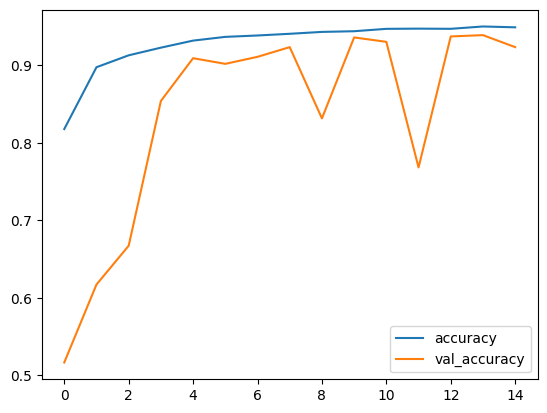

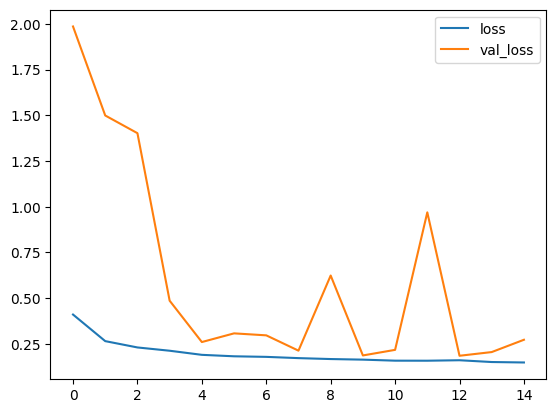

130/130 [==============================] - 4s 28ms/step - loss: 0.2353 - custom_accuracy: 0.9332
Test Accuracy: 0.9331730604171753
Test loss: 0.23526637256145477


In [56]:
plt.plot(history2_se1.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se1.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se1.history['loss'], label='loss')
plt.plot(history2_se1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


model2_se1.save('model2_se1.h5')

test_loss, test_accuracy = model2_se1.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 

# Second Position of SE in model 2#

In [57]:
def Classifier_CNN_2_SE2(input_size=(64,64,3), l2_reg=0.00001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
    parallel_1 = SEBlock(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
    parallel_2 = SEBlock(parallel_2)
       
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    parallel_3 = SEBlock(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)
    
#     # Define the second fully connected layer
#     fc_layer_2 = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(fc_layer_1)
#     fc_layer_2 = BatchNormalization()(fc_layer_2)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(fc_layer_1)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

In [58]:
model2_se2 = Classifier_CNN_2_SE2(input_size=(64,64,3), l2_reg=0.00001)
model2_se2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 64, 64, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 64, 64, 16)   1216        ['input_9[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 64, 64, 16)   2368        ['input_9[0][0]']                
                                                                                            

In [59]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2_se2.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se2 = model2_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 62ms/step - loss: 0.3841 - custom_accuracy: 0.8325 - val_loss: 1.9632 - val_custom_accuracy: 0.5167
Epoch 2/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2544 - custom_accuracy: 0.9032 - val_loss: 0.4585 - val_custom_accuracy: 0.8079
Epoch 3/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2249 - custom_accuracy: 0.9167 - val_loss: 0.6568 - val_custom_accuracy: 0.7860
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2032 - custom_accuracy: 0.9267 - val_loss: 0.1850 - val_custom_accuracy: 0.9373
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1966 - custom_accuracy: 0.9299 - val_loss: 0.2090 - val_custom_accuracy: 0.9249
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1858 - custom_accuracy: 0.9339 - val_loss: 0.2912 - val_custom_accuracy: 0.8917
Epoch 7/15
603/603 [==============================] 

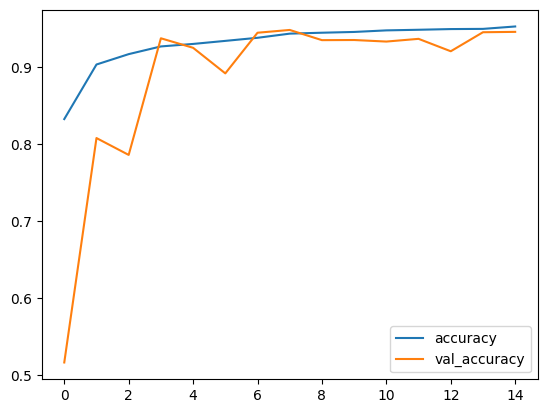

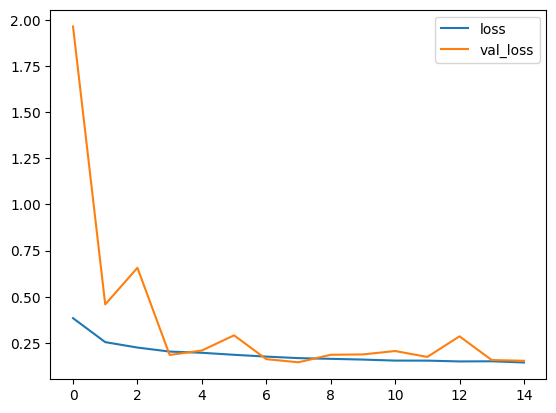

130/130 [==============================] - 4s 30ms/step - loss: 0.1351 - custom_accuracy: 0.9526
Test Accuracy: 0.9526442289352417
Test loss: 0.13505218923091888


In [60]:
plt.plot(history2_se2.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se2.history['loss'], label='loss')
plt.plot(history2_se2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


model2_se2.save('model2_se2.h5')

test_loss, test_accuracy = model2_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 

In [87]:
model2 = load_model('model2_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

test_loss, test_accuracy = model2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 4s 28ms/step - loss: 0.1350 - custom_accuracy: 0.9526
Test Accuracy: 0.9526442289352417
Test loss: 0.13501285016536713


In [94]:
predY = model2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 27ms/step


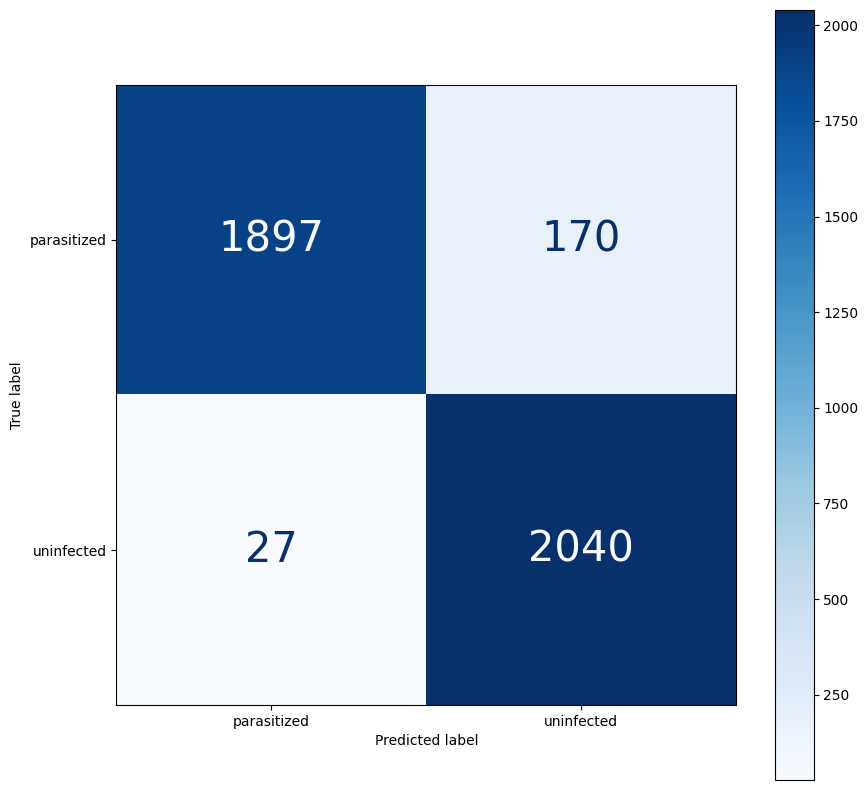

Sensitivity: 0.9869375907111756, Specificity: 0.9177552007740687


In [96]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [97]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df 

precision    recall  f1-score      support
parasitized    0.985967  0.917755  0.950639  2067.000000
uninfected     0.923077  0.986938  0.953940  2067.000000
accuracy       0.952346  0.952346  0.952346     0.952346
macro avg      0.954522  0.952346  0.952289  4134.000000
weighted avg   0.954522  0.952346  0.952289  4134.000000

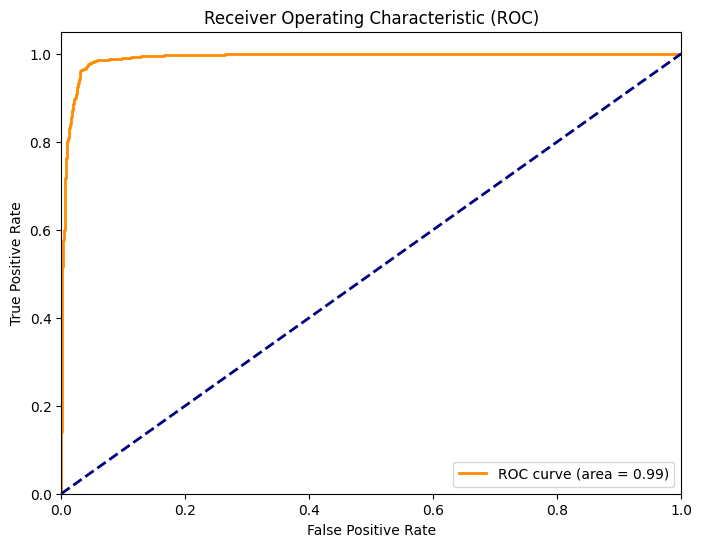

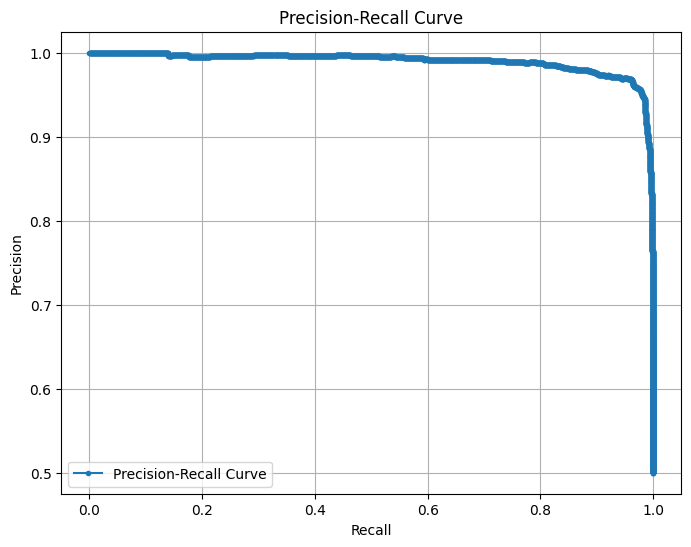

In [98]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Third Position of SE in model 2#

In [14]:
def Classifier_CNN_2_SE3(input_size=(64,64,3), l2_reg=0.00001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
       
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    se_concatenated = SEBlock(concatenated)
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(se_concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)
    
    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(fc_layer_1)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

In [15]:
model2_se3 = Classifier_CNN_2_SE3(input_size=(64,64,3), l2_reg=0.00001)
model2_se3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 16)   1216        ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 16)   2368        ['input_1[0][0]']                
                                                                                              

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2_se3.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se3 = model2_se3.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 146s 231ms/step - loss: 0.4236 - custom_accuracy: 0.8058 - val_loss: 3.1229 - val_custom_accuracy: 0.5030
Epoch 2/15
603/603 [==============================] - 33s 54ms/step - loss: 0.2714 - custom_accuracy: 0.8937 - val_loss: 0.9907 - val_custom_accuracy: 0.7084
Epoch 3/15
603/603 [==============================] - 35s 59ms/step - loss: 0.2351 - custom_accuracy: 0.9116 - val_loss: 0.2107 - val_custom_accuracy: 0.9267
Epoch 4/15
603/603 [==============================] - 53s 87ms/step - loss: 0.2161 - custom_accuracy: 0.9204 - val_loss: 0.4048 - val_custom_accuracy: 0.8518
Epoch 5/15
603/603 [==============================] - 72s 120ms/step - loss: 0.1987 - custom_accuracy: 0.9280 - val_loss: 0.4712 - val_custom_accuracy: 0.8430
Epoch 6/15
603/603 [==============================] - 69s 115ms/step - loss: 0.1951 - custom_accuracy: 0.9315 - val_loss: 0.3308 - val_custom_accuracy: 0.8785
Epoch 7/15
603/603 [============================

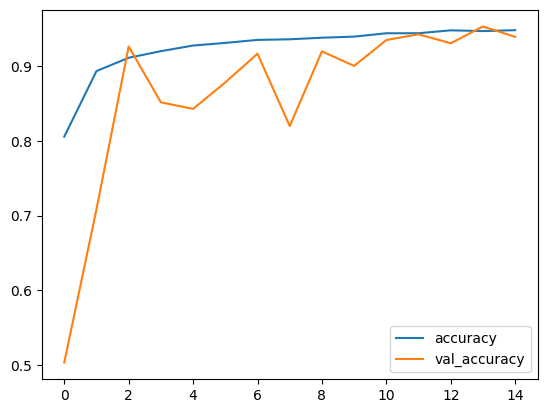

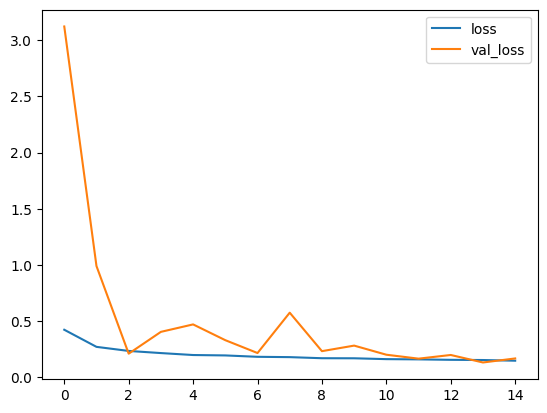

130/130 [==============================] - 9s 69ms/step - loss: 0.1396 - custom_accuracy: 0.9514
Test Accuracy: 0.951442301273346
Test loss: 0.1396409273147583


In [17]:
plt.plot(history2_se3.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se3.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se3.history['loss'], label='loss')
plt.plot(history2_se3.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


model2_se3.save('model2_se3.h5')

test_loss, test_accuracy = model2_se3.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 

# Feature Level Ensemble

In [28]:
from tensorflow.keras.models import load_model
model1 = load_model('model1_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})
model2 = load_model('model2_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

In [29]:
for layer in model1.layers:
    layer.trainable = False

for layer in model2.layers:
    layer.trainable = False

In [30]:
common_input = Input(shape=(64, 64, 3))

output1 = model1.layers[-4].output
output2 = model2.layers[-5].output

print(output1)
print(output2)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 128), dtype=tf.float32, name=None), name='multiply_1/mul:0', description="created by layer 'multiply_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 128), dtype=tf.float32, name=None), name='max_pooling2d_31/MaxPool:0', description="created by layer 'max_pooling2d_31'")


In [31]:
model1_with_common_input = Model(inputs=model1.input, outputs=output1)
model2_with_common_input = Model(inputs=model2.input, outputs=output2)

# model1_with_common_input.summary()
# model2_with_common_input.summary()

output1_from_common = model1_with_common_input(common_input)
output2_from_common = model2_with_common_input(common_input)

merged_outputs = concatenate([output1_from_common, output2_from_common])
# merged_outputs = GlobalAveragePooling2D()(merged_outputs)
merged_outputs = Flatten()(merged_outputs)

print(merged_outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 16384), dtype=tf.float32, name=None), name='flatten_2/Reshape:0', description="created by layer 'flatten_2'")


In [32]:
output = Dense(1, activation='sigmoid')(merged_outputs)

ensemble_model = Model(inputs=common_input, outputs=output)

ensemble_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_6 (Functional)           (None, 8, 8, 128)    246480      ['input_3[0][0]']                
                                                                                                  
 model_7 (Functional)           (None, 8, 8, 128)    60406       ['input_3[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 8, 8, 256)    0           ['model_6[0][0]',                
                                                                  'model_7[0][0]']          

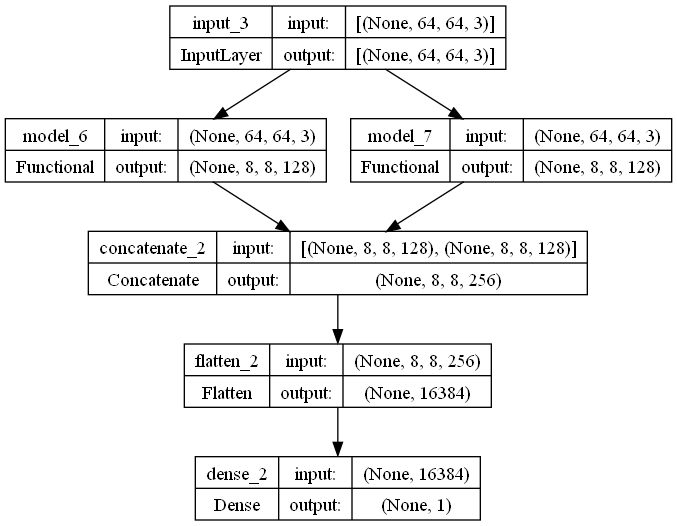

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(ensemble_model, to_file='ensemble_model.png', show_shapes=True, show_layer_names=True)

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
ensemble_model.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_ensemble = ensemble_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 62ms/step - loss: 0.3952 - custom_accuracy: 0.8282 - val_loss: 0.2333 - val_custom_accuracy: 0.9026
Epoch 2/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1952 - custom_accuracy: 0.9348 - val_loss: 0.1559 - val_custom_accuracy: 0.9411
Epoch 3/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1597 - custom_accuracy: 0.9452 - val_loss: 0.1484 - val_custom_accuracy: 0.9450
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1434 - custom_accuracy: 0.9511 - val_loss: 0.1406 - val_custom_accuracy: 0.9500
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1375 - custom_accuracy: 0.9529 - val_loss: 0.1393 - val_custom_accuracy: 0.9466
Epoch 6/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1316 - custom_accuracy: 0.9547 - val_loss: 0.1347 - val_custom_accuracy: 0.9487
Epoch 7/15
603/603 [==============================] 

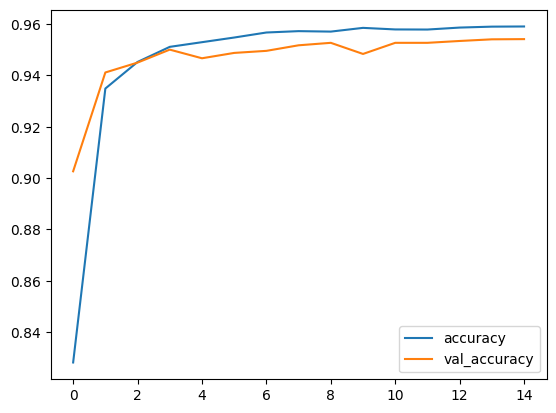

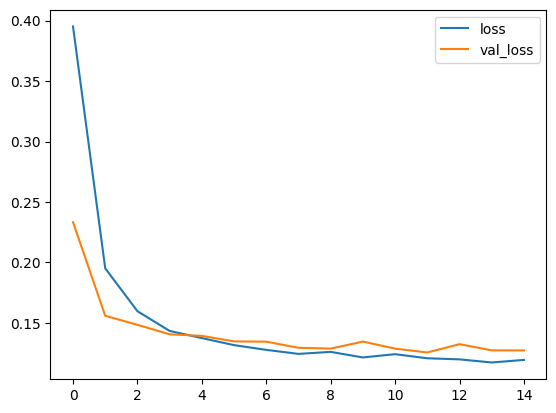

In [35]:
plt.plot(history_ensemble.history['custom_accuracy'], label='accuracy')
plt.plot(history_ensemble.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ensemble.history['loss'], label='loss')
plt.plot(history_ensemble.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [76]:
test_loss, test_accuracy = ensemble_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 3s 23ms/step - loss: 0.1171 - custom_accuracy: 0.9577
Test Accuracy: 0.9576923251152039
Test loss: 0.11712393164634705


In [77]:
ensemble_model.save('ensemble_model_1.h5')

In [78]:
predY = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes

130/130 [==============================] - 3s 22ms/step


In [79]:
predY_classes = (predY > 0.5).astype(int).flatten()
print(predY_classes)

[0 0 0 ... 1 1 1]


In [80]:
print(testY)
print(predY)
print(np.sum(predY_classes==testY), testY.shape[0])

[0 0 0 ... 1 1 1]
[[2.7149117e-03]
 [2.7425440e-05]
 [4.3331324e-06]
 ...
 [9.9629200e-01]
 [9.8473871e-01]
 [9.9641353e-01]]
3958 4134


In [81]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'parasitized': 0, 'uninfected': 1}
{'parasitized': 0, 'uninfected': 1}
{'parasitized': 0, 'uninfected': 1}


In [82]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

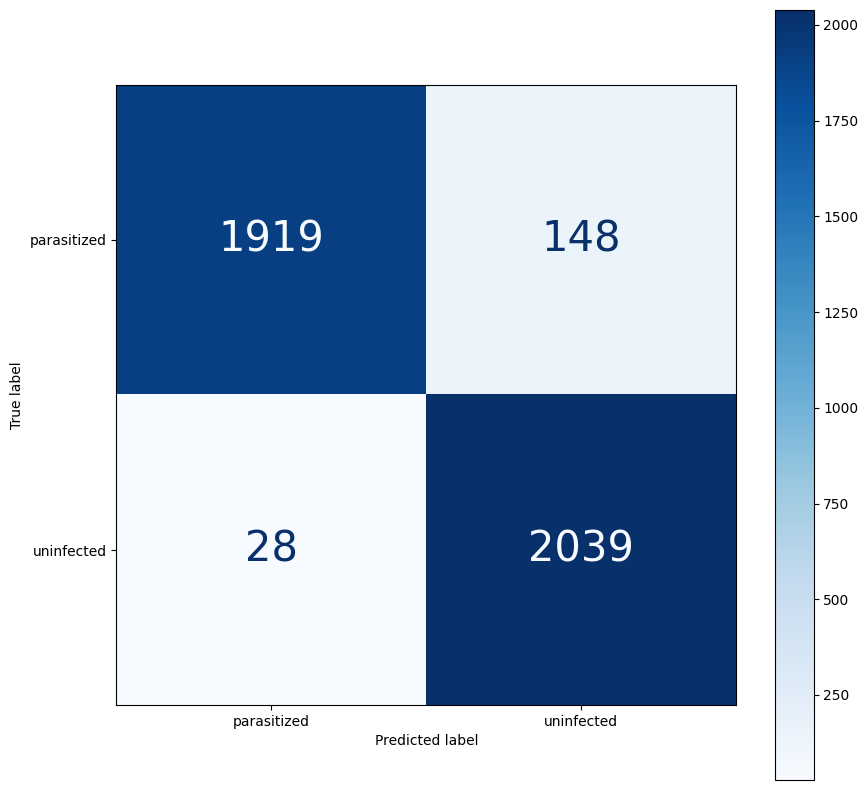

In [83]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()


In [84]:
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

Sensitivity: 0.9864537977745524, Specificity: 0.9283986453797775


In [85]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.985619  0.928399  0.956153  2067.000000
uninfected     0.932327  0.986454  0.958627  2067.000000
accuracy       0.957426  0.957426  0.957426     0.957426
macro avg      0.958973  0.957426  0.957390  4134.000000
weighted avg   0.958973  0.957426  0.957390  4134.000000

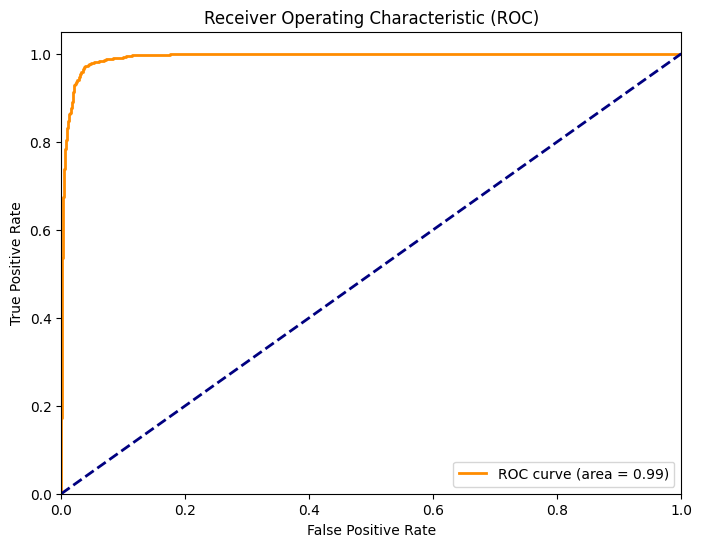

In [86]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

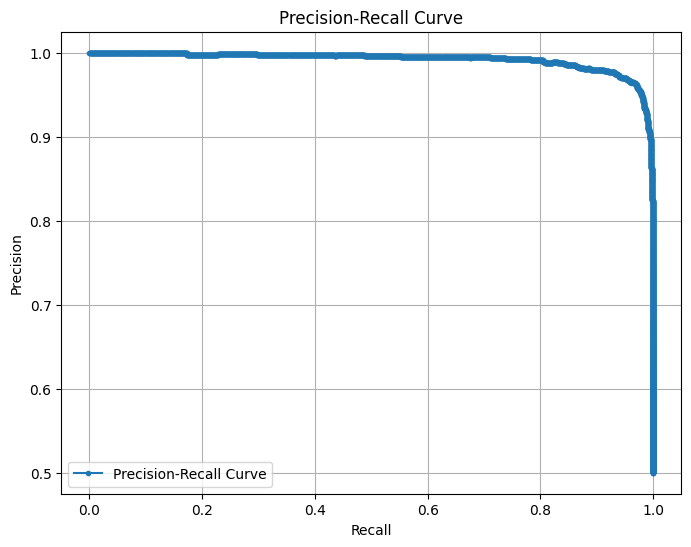

In [87]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Weighted Ensemble

In [88]:
from tensorflow.keras.models import load_model
model1 = load_model('model1_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})
model2 = load_model('model2_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

In [89]:
for layer in model1.layers:
    layer.trainable = False

for layer in model2.layers:
    layer.trainable = False

In [90]:
from tensorflow.keras.layers import Add

common_input = Input(shape=(64, 64, 3))

output1 = model1.layers[-4].output
output2 = model2.layers[-5].output

model1_with_common_input = Model(inputs=model1.input, outputs=output1)
model2_with_common_input = Model(inputs=model2.input, outputs=output2)

output1_from_common = model1_with_common_input(common_input)
output2_from_common = model2_with_common_input(common_input)

weight1 = 0.6
weight2 = 0.4

weighted_output1 = tf.multiply(output1_from_common, weight1)
weighted_output2 = tf.multiply(output2_from_common, weight2)

merged_outputs = Add()([weighted_output1, weighted_output2])
merged_outputs = Flatten()(merged_outputs)

output = Dense(1, activation='sigmoid')(merged_outputs)

ensemble_model_2 = Model(inputs=common_input, outputs=output)

ensemble_model_2.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_15 (Functional)          (None, 8, 8, 128)    246480      ['input_6[0][0]']                
                                                                                                  
 model_16 (Functional)          (None, 8, 8, 128)    60406       ['input_6[0][0]']                
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 8, 8, 128)   0           ['model_15[0][0]']               
 )                                                                                         

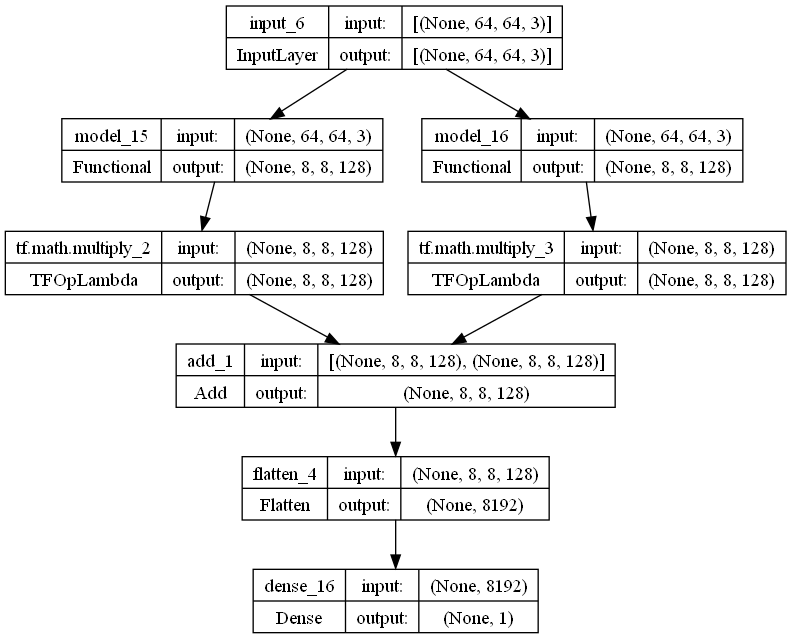

In [91]:
from keras.utils.vis_utils import plot_model
plot_model(ensemble_model_2, to_file='ensemble_model.png', show_shapes=True, show_layer_names=True)

In [92]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
ensemble_model_2.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])

In [93]:
history_ensemble_2 = ensemble_model_2.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 28s 46ms/step - loss: 0.2257 - custom_accuracy: 0.9160 - val_loss: 0.1375 - val_custom_accuracy: 0.9524
Epoch 2/15
603/603 [==============================] - 27s 44ms/step - loss: 0.1378 - custom_accuracy: 0.9519 - val_loss: 0.1296 - val_custom_accuracy: 0.9531
Epoch 3/15
603/603 [==============================] - 26s 43ms/step - loss: 0.1282 - custom_accuracy: 0.9558 - val_loss: 0.1303 - val_custom_accuracy: 0.9526
Epoch 4/15
603/603 [==============================] - 26s 42ms/step - loss: 0.1196 - custom_accuracy: 0.9581 - val_loss: 0.1339 - val_custom_accuracy: 0.9524
Epoch 5/15
603/603 [==============================] - 26s 43ms/step - loss: 0.1203 - custom_accuracy: 0.9564 - val_loss: 0.1405 - val_custom_accuracy: 0.9478
Epoch 6/15
603/603 [==============================] - 25s 42ms/step - loss: 0.1195 - custom_accuracy: 0.9585 - val_loss: 0.1325 - val_custom_accuracy: 0.9531
Epoch 7/15
603/603 [==============================] 

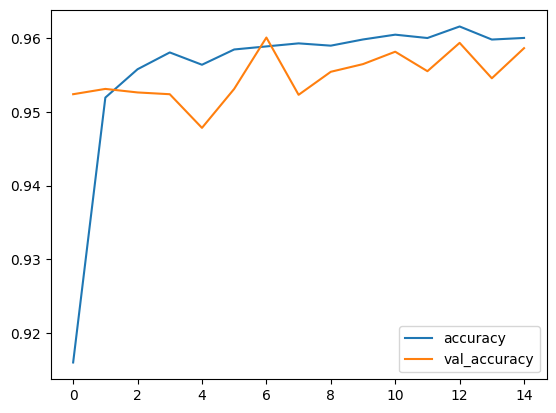

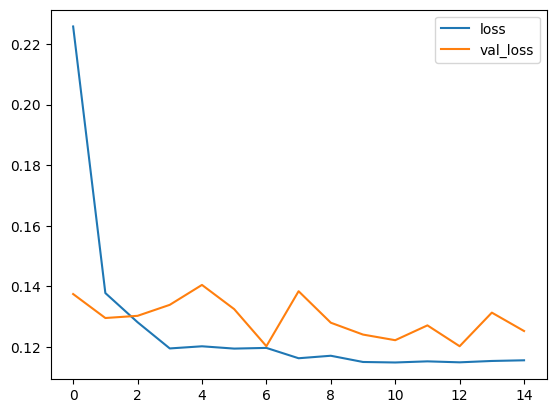

In [94]:
plt.plot(history_ensemble_2.history['custom_accuracy'], label='accuracy')
plt.plot(history_ensemble_2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ensemble_2.history['loss'], label='loss')
plt.plot(history_ensemble_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [95]:
test_loss, test_accuracy = ensemble_model_2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 3s 22ms/step - loss: 0.1004 - custom_accuracy: 0.9637
Test Accuracy: 0.9637019038200378
Test loss: 0.1004103422164917


In [96]:
ensemble_model_2.save('ensemble_model_2.h5')

In [97]:
predY = ensemble_model_2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

class_to_label_map = {'parasitized':0 , 'uninfected':1}

130/130 [==============================] - 3s 23ms/step


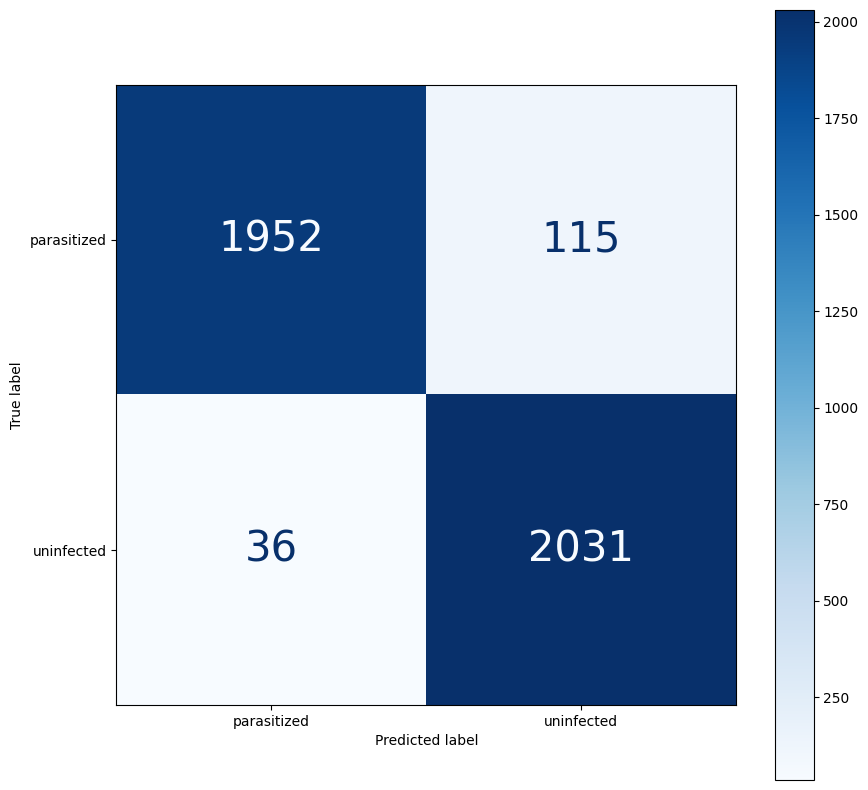

Sensitivity: 0.9825834542815675, Specificity: 0.9443638122883405


In [98]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [99]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


precision    recall  f1-score      support
parasitized    0.981891  0.944364  0.962762  2067.000000
uninfected     0.946412  0.982583  0.964159  2067.000000
accuracy       0.963474  0.963474  0.963474     0.963474
macro avg      0.964152  0.963474  0.963460  4134.000000
weighted avg   0.964152  0.963474  0.963460  4134.000000

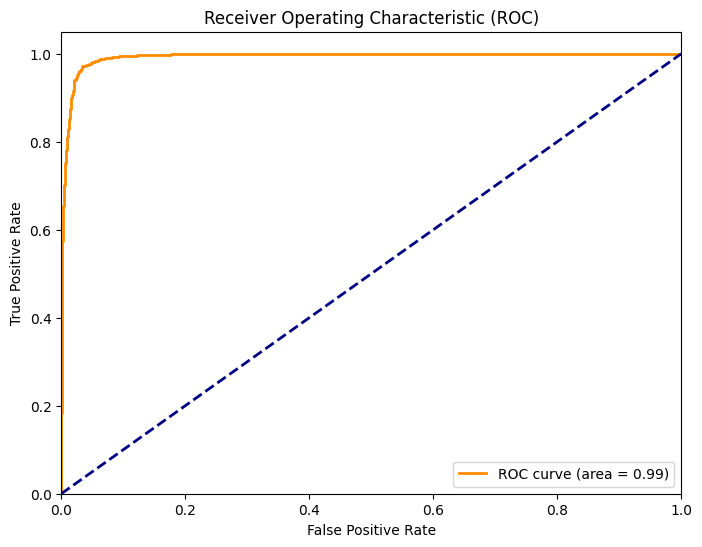

In [100]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

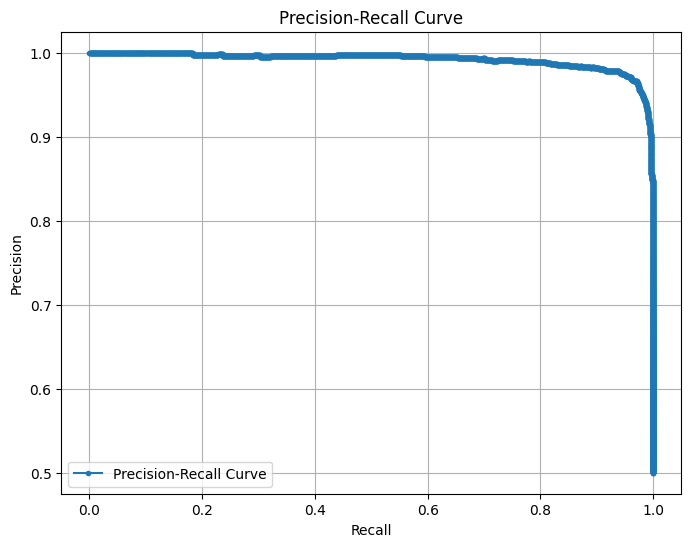

In [101]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Deep Ensemble

In [102]:
from tensorflow.keras.models import load_model
model1 = load_model('model1_se1.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})
model2 = load_model('model2_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

for layer in model1.layers:
    layer.trainable = False

for layer in model2.layers:
    layer.trainable = False


In [103]:
common_input = Input(shape=(64, 64, 3))

output1 = model1.layers[-4].output
output2 = model2.layers[-5].output

model1_with_common_input = Model(inputs=model1.input, outputs=output1)
model2_with_common_input = Model(inputs=model2.input, outputs=output2)

output1_from_common = model1_with_common_input(common_input)
output2_from_common = model2_with_common_input(common_input)

merged_outputs = concatenate([output1_from_common, output2_from_common])
merged_outputs = Flatten()(merged_outputs)


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_18 (Functional)          (None, 8, 8, 128)    252108      ['input_7[0][0]']                
                                                                                                  
 model_19 (Functional)          (None, 8, 8, 128)    60406       ['input_7[0][0]']                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 8, 8, 256)    0           ['model_18[0][0]',               
                                                                  'model_19[0][0]']        

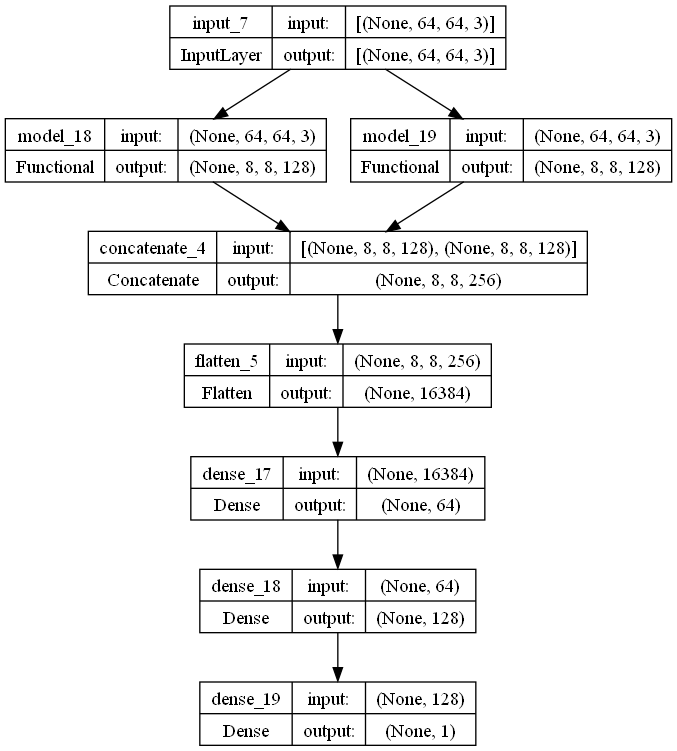

In [104]:
combined = Dense(64, activation='relu', kernel_regularizer=l2(0.00001))(merged_outputs)
combined = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(combined)

output = Dense(1, activation='sigmoid')(combined)

ensemble_model_3 = Model(inputs=common_input, outputs=output)

ensemble_model_3.summary()

from keras.utils.vis_utils import plot_model
plot_model(ensemble_model_3, to_file='ensemble_model.png', show_shapes=True, show_layer_names=True)


In [105]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
ensemble_model_3.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_ensemble = ensemble_model_3.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 28s 44ms/step - loss: 0.2009 - custom_accuracy: 0.9313 - val_loss: 0.1448 - val_custom_accuracy: 0.9459
Epoch 2/15
603/603 [==============================] - 26s 43ms/step - loss: 0.1256 - custom_accuracy: 0.9583 - val_loss: 0.1433 - val_custom_accuracy: 0.9476
Epoch 3/15
603/603 [==============================] - 26s 43ms/step - loss: 0.1165 - custom_accuracy: 0.9613 - val_loss: 0.1247 - val_custom_accuracy: 0.9550
Epoch 4/15
603/603 [==============================] - 26s 43ms/step - loss: 0.1154 - custom_accuracy: 0.9609 - val_loss: 0.1398 - val_custom_accuracy: 0.9486
Epoch 5/15
603/603 [==============================] - 25s 42ms/step - loss: 0.1145 - custom_accuracy: 0.9619 - val_loss: 0.1355 - val_custom_accuracy: 0.9498
Epoch 6/15
603/603 [==============================] - 25s 42ms/step - loss: 0.1104 - custom_accuracy: 0.9628 - val_loss: 0.1663 - val_custom_accuracy: 0.9425
Epoch 7/15
603/603 [==============================] 

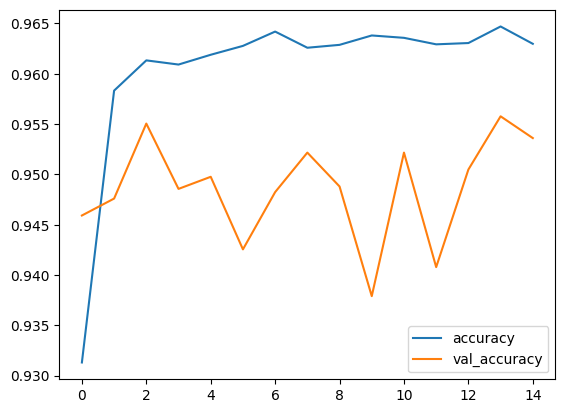

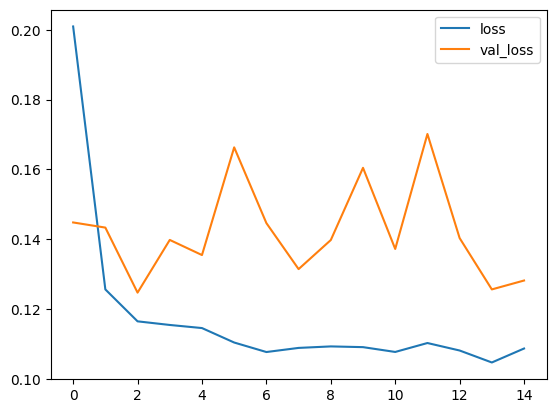

130/130 [==============================] - 3s 23ms/step - loss: 0.1200 - custom_accuracy: 0.9582
Test Accuracy: 0.9581730961799622
Test loss: 0.12002426385879517


In [106]:
plt.plot(history_ensemble.history['custom_accuracy'], label='accuracy')
plt.plot(history_ensemble.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ensemble.history['loss'], label='loss')
plt.plot(history_ensemble.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = ensemble_model_3.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

ensemble_model_3.save('ensemble_model_3.h5')

In [107]:
predY = ensemble_model_3.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

class_to_label_map = {'parasitized':0 , 'uninfected':1}

130/130 [==============================] - 3s 22ms/step


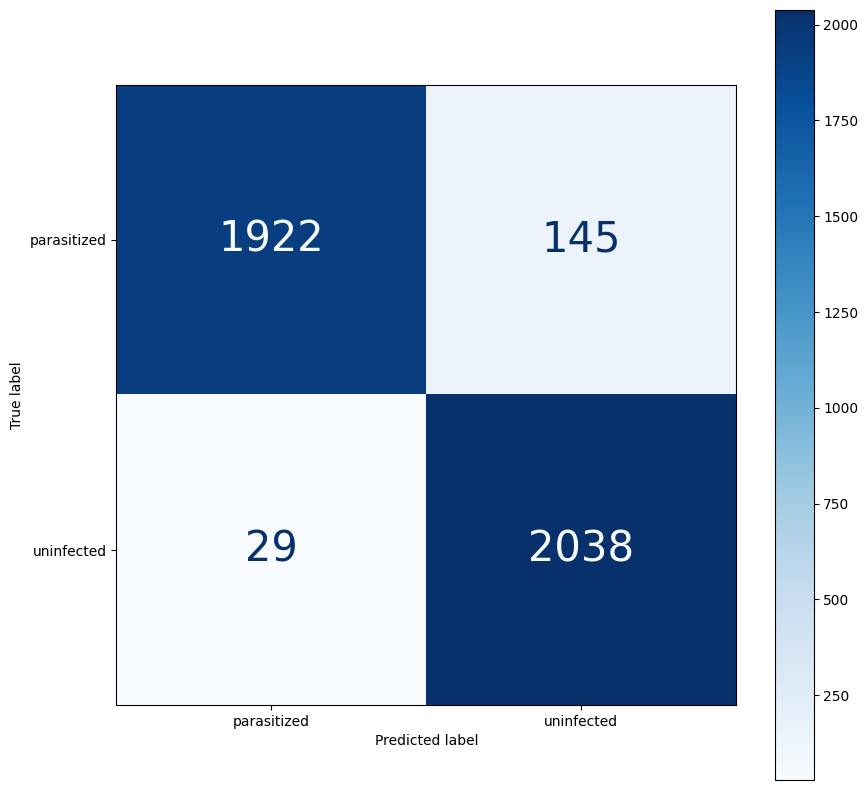

Sensitivity: 0.9859700048379294, Specificity: 0.9298500241896468


In [108]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [109]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


precision   recall  f1-score     support
parasitized    0.985136  0.92985  0.956695  2067.00000
uninfected     0.933578  0.98597  0.959059  2067.00000
accuracy       0.957910  0.95791  0.957910     0.95791
macro avg      0.959357  0.95791  0.957877  4134.00000
weighted avg   0.959357  0.95791  0.957877  4134.00000

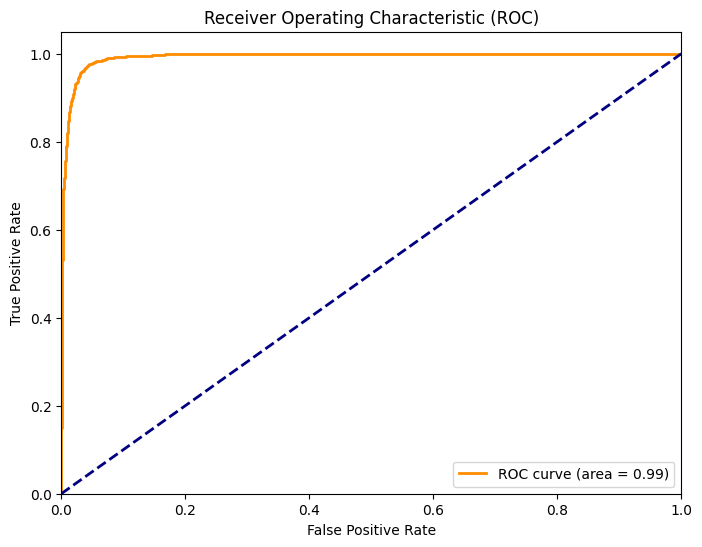

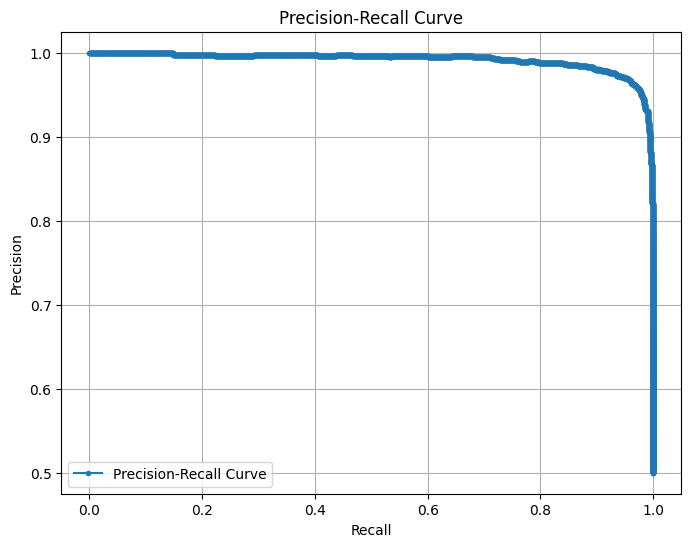

In [110]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# VGG-16

In [84]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(64, 64, 3)))
x = Flatten()(base_model.output)
output = Dense(1, activation='sigmoid')(x)
vgg16_model = Model(inputs=base_model.input, outputs=output)

58889256/58889256 [==============================] - 317s 5us/step


In [85]:
for layer in base_model.layers:
    layer.trainable = False
    
vgg16_model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [86]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
vgg16_model.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])

In [87]:
history = vgg16_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 38s 61ms/step - loss: 0.5438 - custom_accuracy: 0.7561 - val_loss: 0.4460 - val_custom_accuracy: 0.8128
Epoch 2/15
603/603 [==============================] - 37s 62ms/step - loss: 0.4101 - custom_accuracy: 0.8380 - val_loss: 0.3789 - val_custom_accuracy: 0.8362
Epoch 3/15
603/603 [==============================] - 36s 59ms/step - loss: 0.3605 - custom_accuracy: 0.8574 - val_loss: 0.3433 - val_custom_accuracy: 0.8458
Epoch 4/15
603/603 [==============================] - 35s 59ms/step - loss: 0.3352 - custom_accuracy: 0.8683 - val_loss: 0.3201 - val_custom_accuracy: 0.8603
Epoch 5/15
603/603 [==============================] - 36s 60ms/step - loss: 0.3163 - custom_accuracy: 0.8747 - val_loss: 0.3028 - val_custom_accuracy: 0.8726
Epoch 6/15
603/603 [==============================] - 36s 60ms/step - loss: 0.3035 - custom_accuracy: 0.8821 - val_loss: 0.2917 - val_custom_accuracy: 0.8768
Epoch 7/15
603/603 [==============================] 

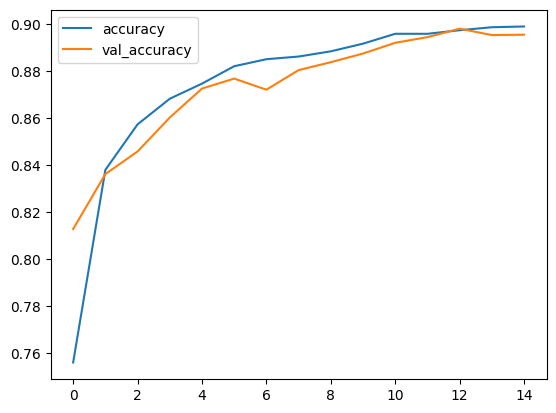

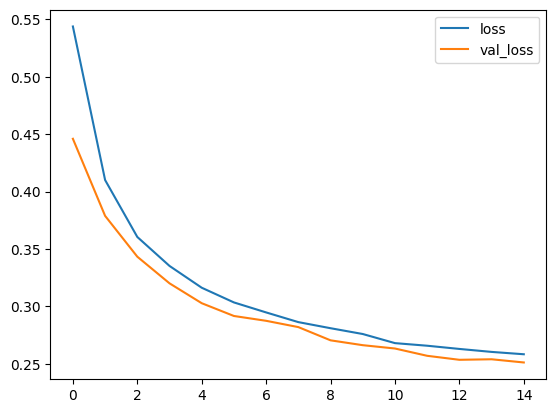

In [91]:
plt.plot(history.history['custom_accuracy'], label='accuracy')
plt.plot(history.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [43]:
# vgg16_model.save('vgg16_model.h5')
from tensorflow.keras.models import load_model
vgg16_model = load_model('vgg16_model.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

In [44]:
test_loss, test_accuracy = vgg16_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 8s 48ms/step - loss: 0.2348 - custom_accuracy: 0.9098
Test Accuracy: 0.9097756743431091
Test loss: 0.23484328389167786


In [45]:
predY = vgg16_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 6s 48ms/step


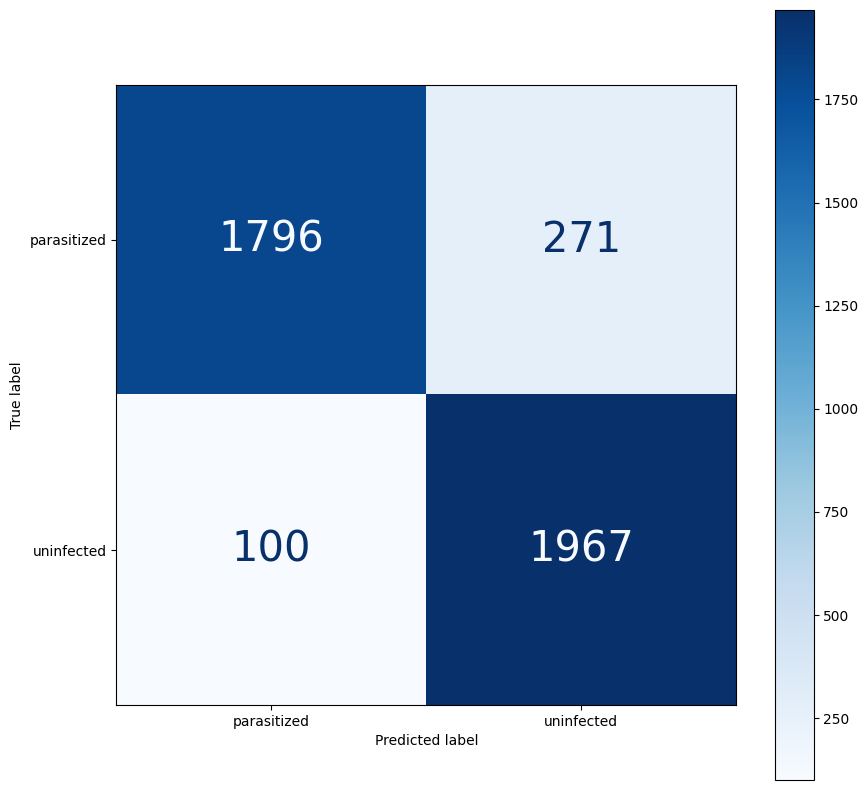

Sensitivity: 0.9516207063376875, Specificity: 0.868892114175133


In [46]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [47]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.947257  0.868892  0.906384  2067.000000
uninfected     0.878910  0.951621  0.913821  2067.000000
accuracy       0.910256  0.910256  0.910256     0.910256
macro avg      0.913084  0.910256  0.910103  4134.000000
weighted avg   0.913084  0.910256  0.910103  4134.000000

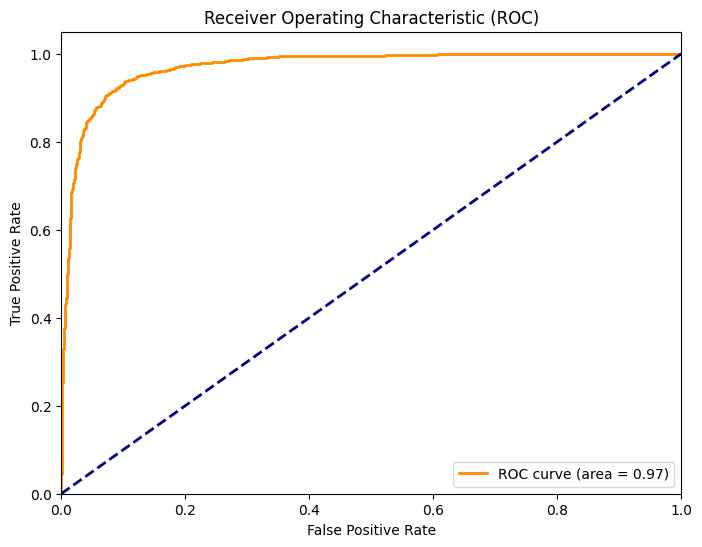

In [48]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

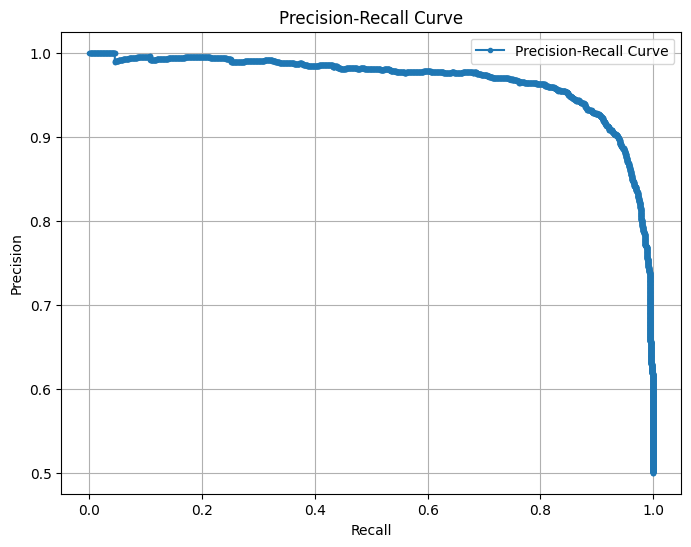

In [49]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# MobileNetV2

In [55]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64,64, 3))

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)

MobileNetV2_model = Model(inputs=base_model.input, outputs=output)

In [56]:
for layer in base_model.layers:
    layer.trainable = False
MobileNetV2_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
MobileNetV2_model.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])

history_MobileNetV2 = MobileNetV2_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 68s 107ms/step - loss: 0.4627 - custom_accuracy: 0.7805 - val_loss: 0.3732 - val_custom_accuracy: 0.8381
Epoch 2/15
603/603 [==============================] - 64s 105ms/step - loss: 0.3050 - custom_accuracy: 0.8811 - val_loss: 0.3028 - val_custom_accuracy: 0.8720
Epoch 3/15
603/603 [==============================] - 65s 108ms/step - loss: 0.2719 - custom_accuracy: 0.8973 - val_loss: 0.2715 - val_custom_accuracy: 0.8885
Epoch 4/15
603/603 [==============================] - 62s 103ms/step - loss: 0.2630 - custom_accuracy: 0.9003 - val_loss: 0.2573 - val_custom_accuracy: 0.8950
Epoch 5/15
603/603 [==============================] - 62s 103ms/step - loss: 0.2515 - custom_accuracy: 0.9027 - val_loss: 0.2469 - val_custom_accuracy: 0.9024
Epoch 6/15
603/603 [==============================] - 63s 105ms/step - loss: 0.2458 - custom_accuracy: 0.9096 - val_loss: 0.2365 - val_custom_accuracy: 0.9060
Epoch 7/15
603/603 [==========================

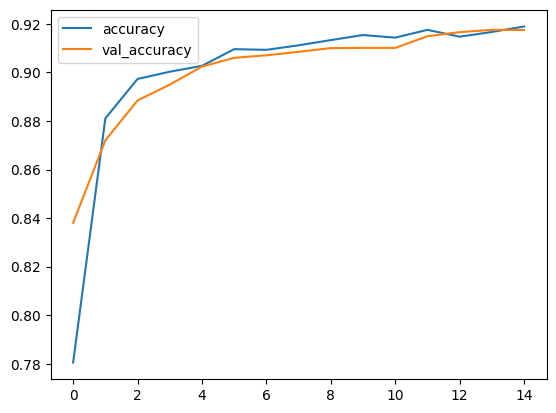

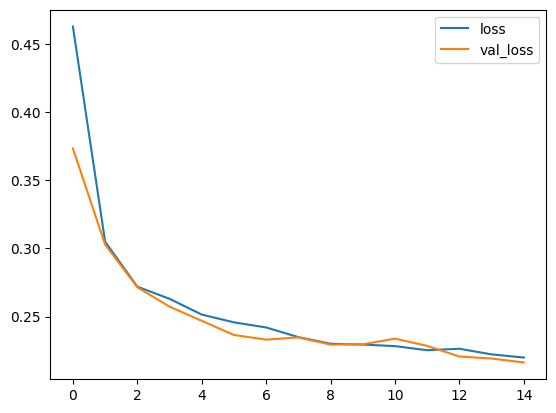

In [58]:
plt.plot(history_MobileNetV2.history['custom_accuracy'], label='accuracy')
plt.plot(history_MobileNetV2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_MobileNetV2.history['loss'], label='loss')
plt.plot(history_MobileNetV2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [59]:
MobileNetV2_model.save('MobileNetV2_model.h5')

test_loss, test_accuracy = MobileNetV2_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 6s 47ms/step - loss: 0.2153 - custom_accuracy: 0.9219
Test Accuracy: 0.921875
Test loss: 0.21534912288188934


In [60]:
predY = MobileNetV2_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 7s 48ms/step


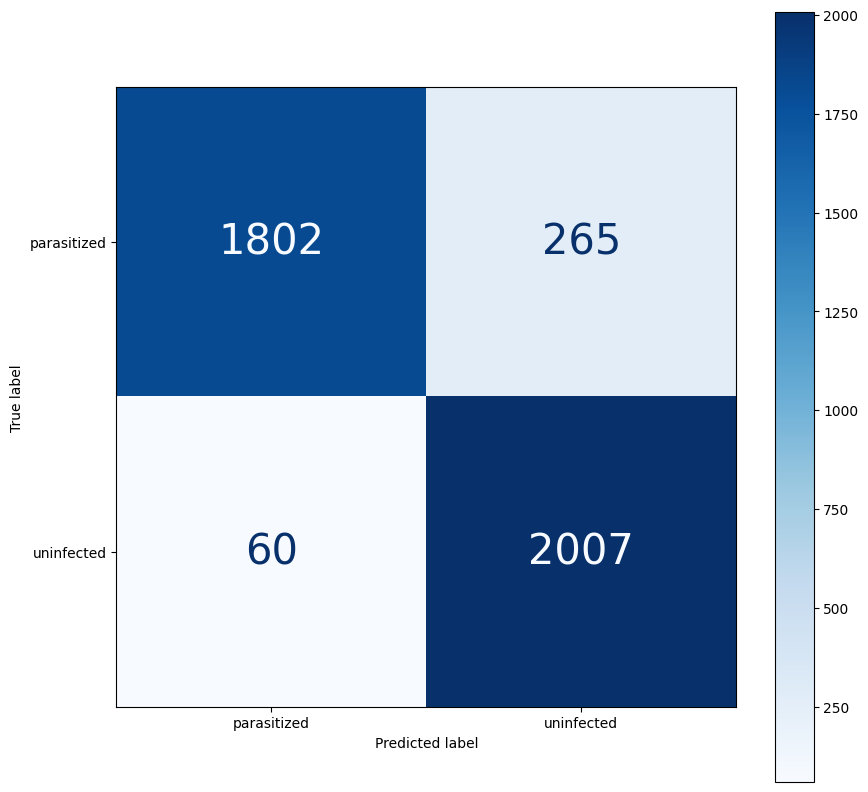

Sensitivity: 0.9709724238026125, Specificity: 0.8717948717948718


In [61]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [62]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.967777  0.871795  0.917282  2067.000000
uninfected     0.883363  0.970972  0.925098  2067.000000
accuracy       0.921384  0.921384  0.921384     0.921384
macro avg      0.925570  0.921384  0.921190  4134.000000
weighted avg   0.925570  0.921384  0.921190  4134.000000

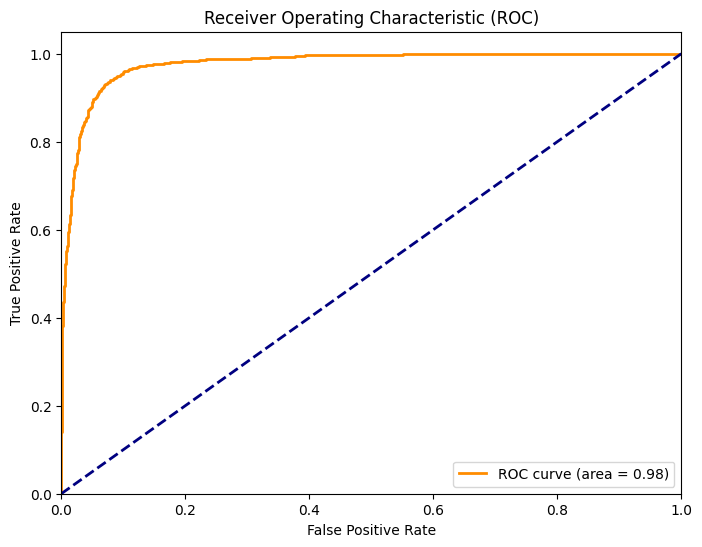

In [63]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

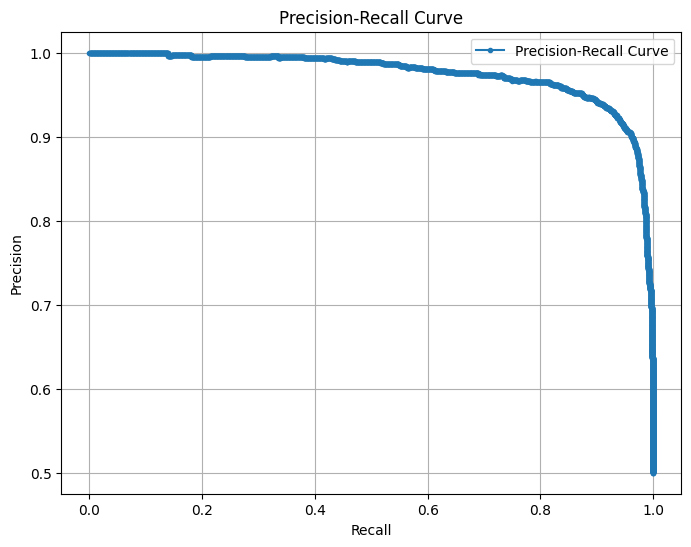

In [64]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# ResNet50

In [30]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(1, activation='sigmoid')(x)

ResNet50_model = Model(inputs=base_model.input, outputs=output)

In [31]:
for layer in base_model.layers:
    layer.trainable = False

ResNet50_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
ResNet50_model.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])

history_ResNet50 = ResNet50_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 77s 120ms/step - loss: 0.7230 - custom_accuracy: 0.5142 - val_loss: 0.6885 - val_custom_accuracy: 0.5589
Epoch 2/15
603/603 [==============================] - 74s 122ms/step - loss: 0.6883 - custom_accuracy: 0.5569 - val_loss: 0.6854 - val_custom_accuracy: 0.5773
Epoch 3/15
603/603 [==============================] - 75s 125ms/step - loss: 0.6855 - custom_accuracy: 0.5642 - val_loss: 0.6837 - val_custom_accuracy: 0.5633
Epoch 4/15
603/603 [==============================] - 76s 125ms/step - loss: 0.6833 - custom_accuracy: 0.5777 - val_loss: 0.6786 - val_custom_accuracy: 0.5950
Epoch 5/15
603/603 [==============================] - 76s 126ms/step - loss: 0.6805 - custom_accuracy: 0.5894 - val_loss: 0.6756 - val_custom_accuracy: 0.5985
Epoch 6/15
603/603 [==============================] - 77s 127ms/step - loss: 0.6783 - custom_accuracy: 0.5936 - val_loss: 0.6747 - val_custom_accuracy: 0.5853
Epoch 7/15
603/603 [==========================

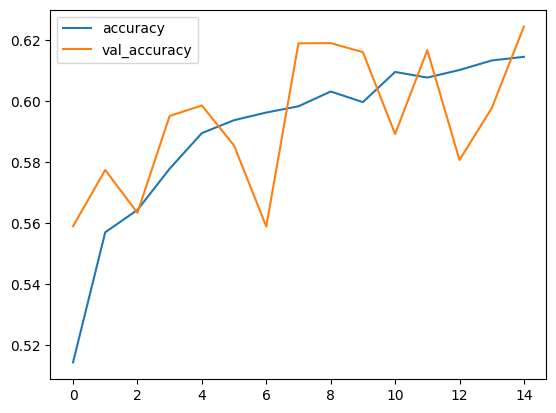

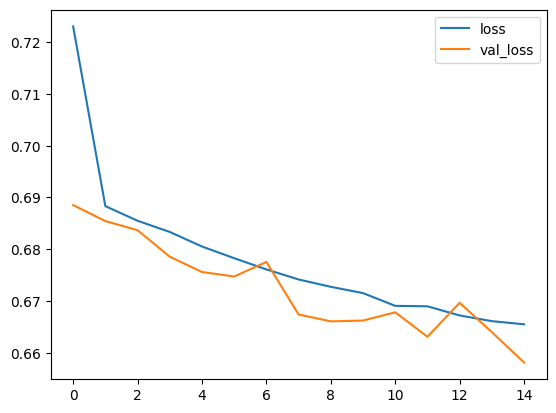

In [34]:
plt.plot(history_ResNet50.history['custom_accuracy'], label='accuracy')
plt.plot(history_ResNet50.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ResNet50.history['loss'], label='loss')
plt.plot(history_ResNet50.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [35]:
ResNet50_model.save('MobileNetV2_model.h5')

test_loss, test_accuracy = ResNet50_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 22s 167ms/step - loss: 0.6565 - custom_accuracy: 0.6228
Test Accuracy: 0.6228365302085876
Test loss: 0.6565319299697876


In [36]:
predY = ResNet50_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 8s 48ms/step


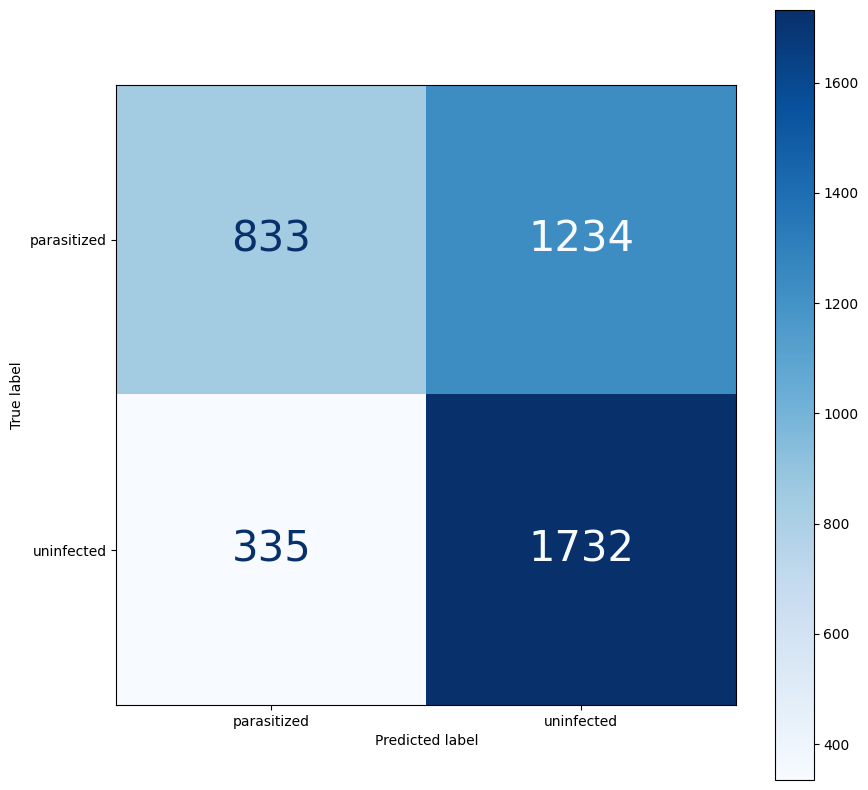

Sensitivity: 0.837929366231253, Specificity: 0.40299951620706337


In [37]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [38]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.713185  0.403000  0.514992  2067.000000
uninfected     0.583951  0.837929  0.688258  2067.000000
accuracy       0.620464  0.620464  0.620464     0.620464
macro avg      0.648568  0.620464  0.601625  4134.000000
weighted avg   0.648568  0.620464  0.601625  4134.000000

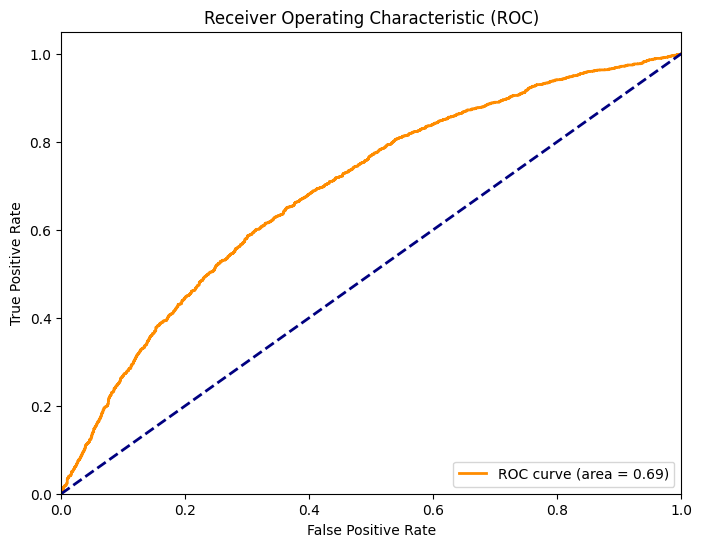

In [39]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

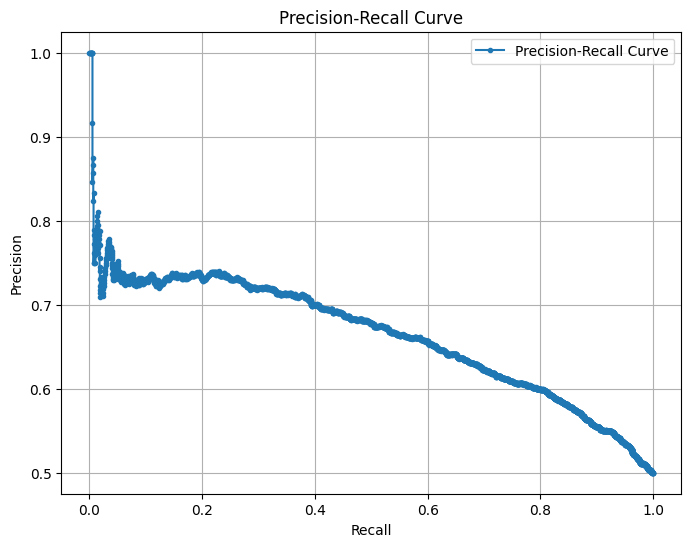

In [40]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# lr = 0.001  in model 1

In [84]:
def Classifier_CNN_1_SE2(input_size=(64,64,3), l2_reg=0.00001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(bn3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    # SE block after all conv and pooling layers
    se_final = SEBlock(pool4) 
    
    # Fully connected layers
    gap = GlobalAveragePooling2D()(se_final)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

In [85]:
model1_se2 = Classifier_CNN_1_SE2(input_size=(64,64,3), l2_reg=0.00001)
model1_se2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 32)   896         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 64, 64, 32)  128         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 32, 32, 32)  0           ['batch_normalization_20[0]

In [86]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model1_se2.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2_lr1 = model1_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))


Epoch 1/15
603/603 [==============================] - 105s 172ms/step - loss: 0.2346 - custom_accuracy: 0.9089 - val_loss: 0.1972 - val_custom_accuracy: 0.9292
Epoch 2/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1612 - custom_accuracy: 0.9479 - val_loss: 0.1997 - val_custom_accuracy: 0.9329
Epoch 3/15
603/603 [==============================] - 39s 64ms/step - loss: 0.1526 - custom_accuracy: 0.9508 - val_loss: 0.1448 - val_custom_accuracy: 0.9564
Epoch 4/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1404 - custom_accuracy: 0.9550 - val_loss: 0.1762 - val_custom_accuracy: 0.9375
Epoch 5/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1380 - custom_accuracy: 0.9548 - val_loss: 0.1392 - val_custom_accuracy: 0.9502
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1332 - custom_accuracy: 0.9555 - val_loss: 0.1226 - val_custom_accuracy: 0.9596
Epoch 7/15
603/603 [==============================

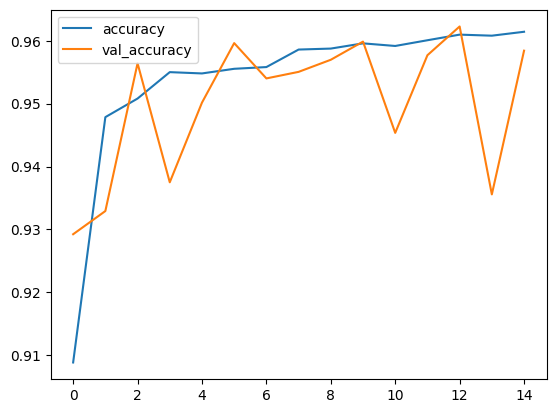

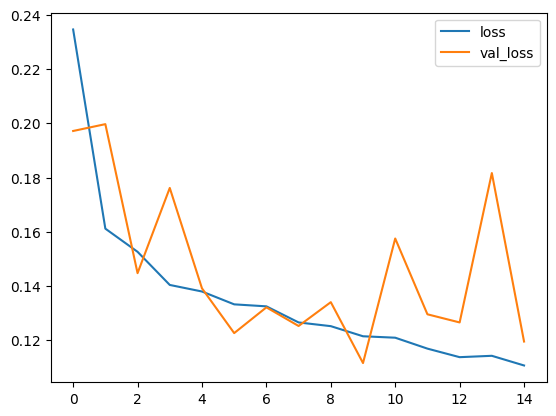

130/130 [==============================] - 4s 27ms/step - loss: 0.1003 - custom_accuracy: 0.9690
Test Accuracy: 0.9689903855323792
Test loss: 0.10026036947965622


In [89]:
plt.plot(history_se2_lr1.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2_lr1.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2_lr1.history['loss'], label='loss')
plt.plot(history_se2_lr1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model1_se2.save('mdoel1_se2_lr1.h5')

test_loss, test_accuracy = model1_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [90]:
predY = model1_se2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 26ms/step


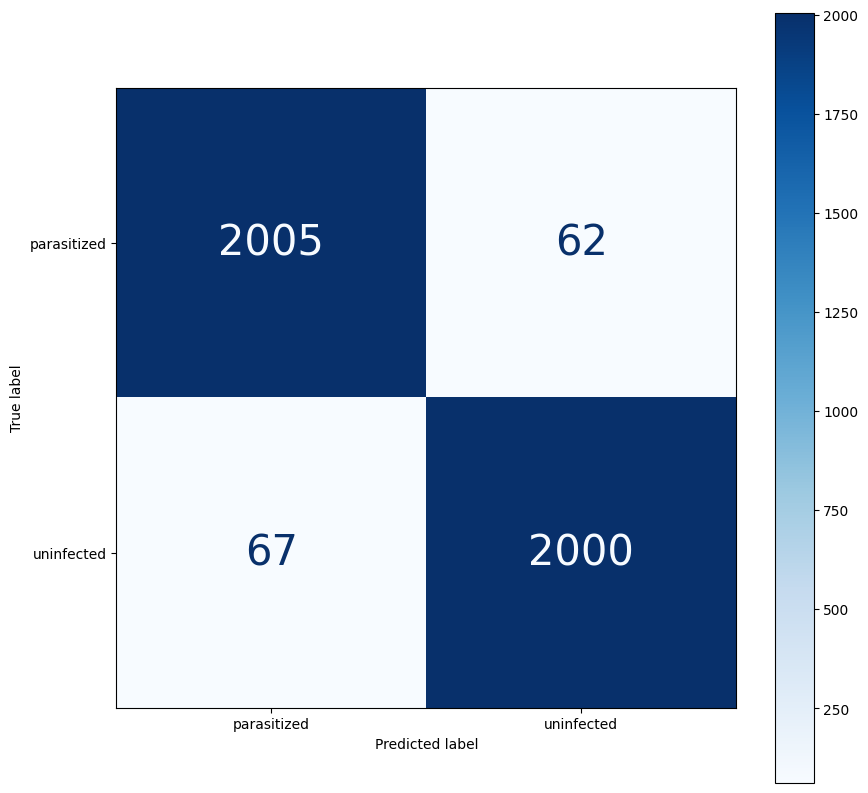

Sensitivity: 0.9675858732462506, Specificity: 0.9700048379293662


In [91]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [92]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.967664  0.970005  0.968833  2067.000000
uninfected     0.969932  0.967586  0.968758  2067.000000
accuracy       0.968795  0.968795  0.968795     0.968795
macro avg      0.968798  0.968795  0.968795  4134.000000
weighted avg   0.968798  0.968795  0.968795  4134.000000

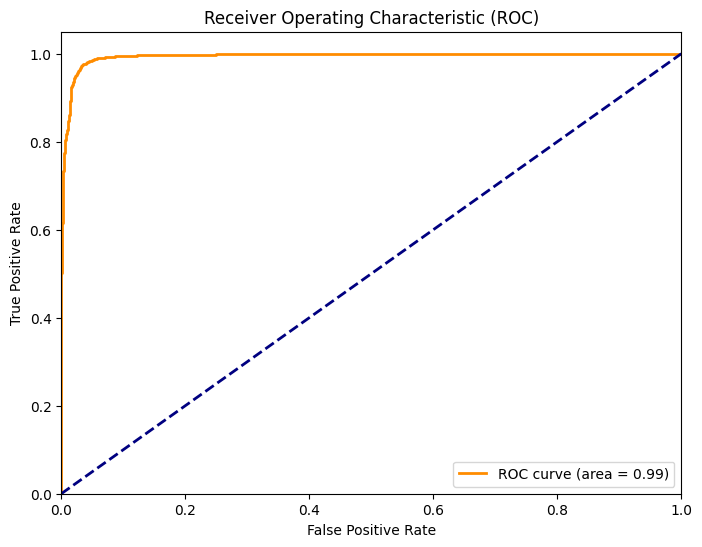

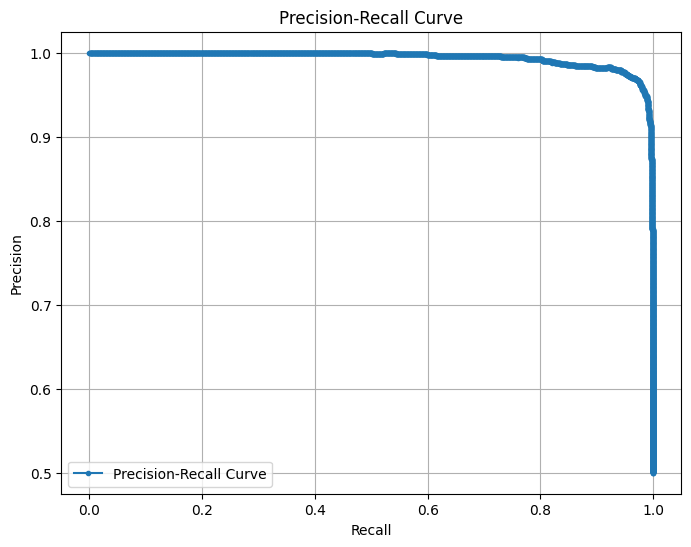

In [93]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# lr = 0.01 in model 1

In [36]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate = 0.01)

model1_se2.compile(optimizer=optimizer2, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2_lr2 = model1_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 38s 62ms/step - loss: 0.2965 - custom_accuracy: 0.8811 - val_loss: 0.3009 - val_custom_accuracy: 0.8934
Epoch 2/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1783 - custom_accuracy: 0.9431 - val_loss: 0.2018 - val_custom_accuracy: 0.9321
Epoch 3/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1610 - custom_accuracy: 0.9483 - val_loss: 0.2126 - val_custom_accuracy: 0.9469
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1592 - custom_accuracy: 0.9505 - val_loss: 0.1429 - val_custom_accuracy: 0.9526
Epoch 5/15
603/603 [==============================] - 36s 60ms/step - loss: 0.1526 - custom_accuracy: 0.9511 - val_loss: 0.1936 - val_custom_accuracy: 0.9389
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1485 - custom_accuracy: 0.9524 - val_loss: 0.1991 - val_custom_accuracy: 0.9288
Epoch 7/15
603/603 [==============================] 

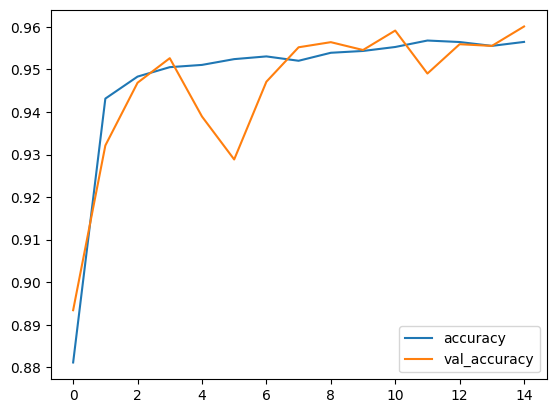

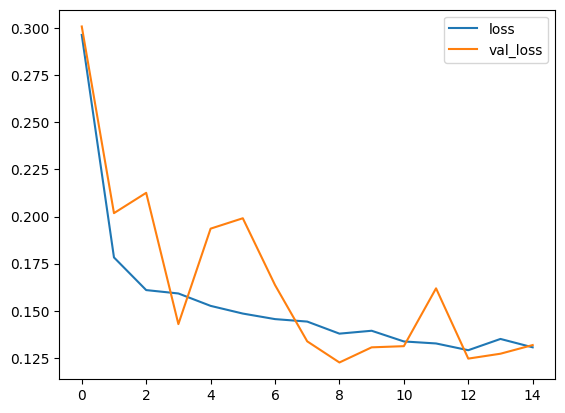

130/130 [==============================] - 4s 28ms/step - loss: 0.1148 - custom_accuracy: 0.9649
Test Accuracy: 0.9649038314819336
Test loss: 0.1147770956158638


In [37]:
plt.plot(history_se2_lr2.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2_lr2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2_lr2.history['loss'], label='loss')
plt.plot(history_se2_lr2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model1_se2.save('mdoel1_se2_lr2.h5')

test_loss, test_accuracy = model1_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [65]:
model1_lr2 = load_model('mdoel1_se2_lr2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

test_loss, test_accuracy = model1_lr2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 4s 27ms/step - loss: 0.1148 - custom_accuracy: 0.9649
Test Accuracy: 0.9649038314819336
Test loss: 0.1147770956158638


In [66]:
predY = model1_lr2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 26ms/step


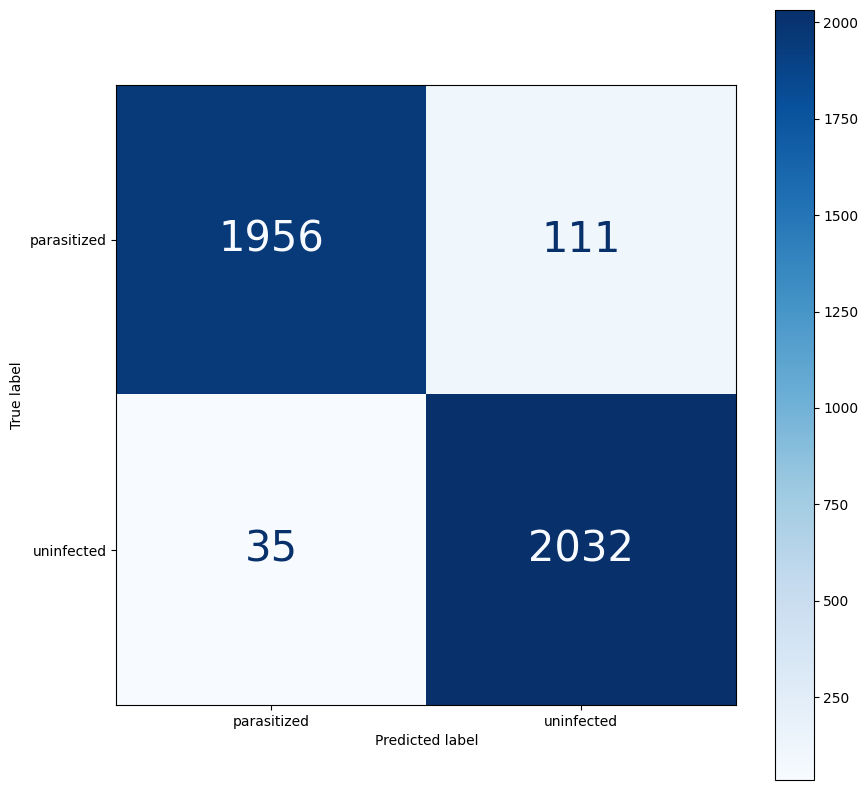

Sensitivity: 0.9830672472181906, Specificity: 0.9462989840348331


In [67]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [68]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.982421  0.946299  0.964022  2067.000000
uninfected     0.948203  0.983067  0.965321  2067.000000
accuracy       0.964683  0.964683  0.964683     0.964683
macro avg      0.965312  0.964683  0.964671  4134.000000
weighted avg   0.965312  0.964683  0.964671  4134.000000

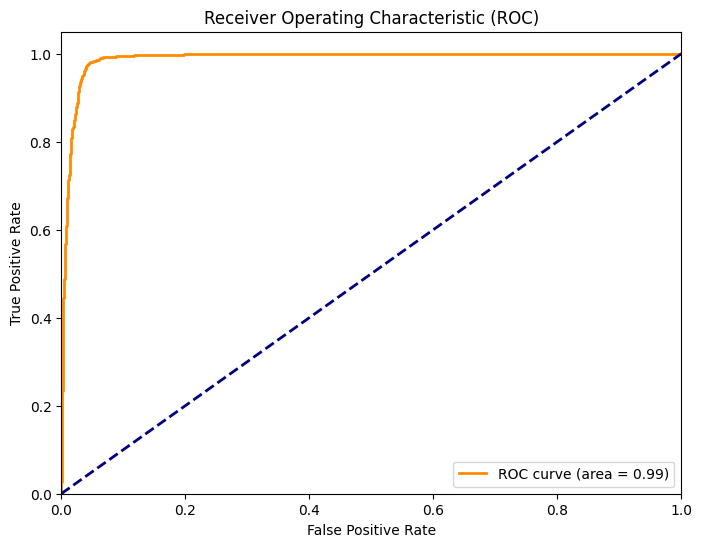

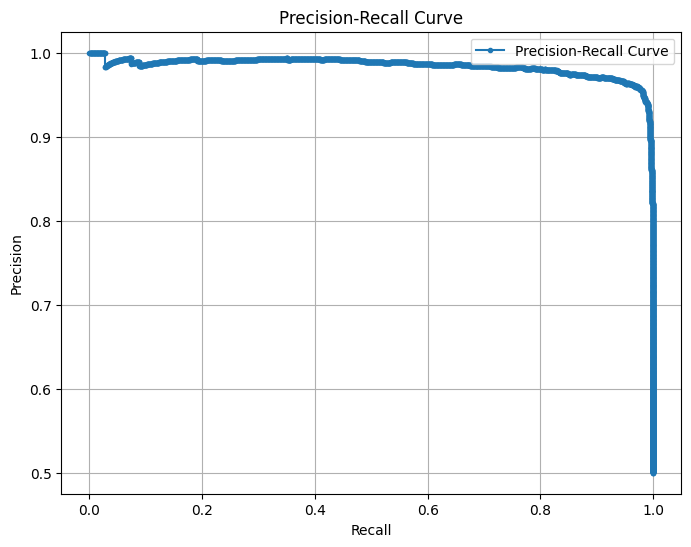

In [69]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# lr = 0.1 in model 1

In [46]:
optimizer3= tf.keras.optimizers.Adam(learning_rate = 0.1)

model1_se2.compile(optimizer=optimizer3,
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2_lr3= model1_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 62ms/step - loss: 0.6707 - custom_accuracy: 0.6396 - val_loss: 7.5260 - val_custom_accuracy: 0.5000
Epoch 2/15
603/603 [==============================] - 37s 61ms/step - loss: 0.3315 - custom_accuracy: 0.8728 - val_loss: 0.5191 - val_custom_accuracy: 0.8270
Epoch 3/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1933 - custom_accuracy: 0.9400 - val_loss: 0.2062 - val_custom_accuracy: 0.9322
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1764 - custom_accuracy: 0.9460 - val_loss: 0.4115 - val_custom_accuracy: 0.8825
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1723 - custom_accuracy: 0.9460 - val_loss: 0.1869 - val_custom_accuracy: 0.9326
Epoch 6/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1674 - custom_accuracy: 0.9476 - val_loss: 0.2282 - val_custom_accuracy: 0.9264
Epoch 7/15
603/603 [==============================] 

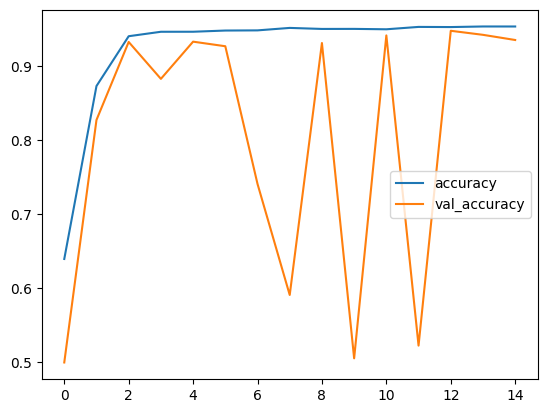

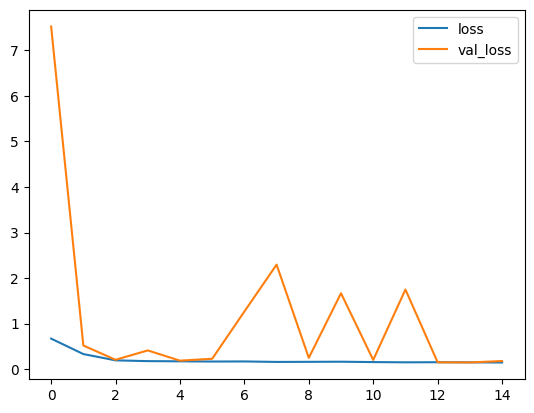

130/130 [==============================] - 13s 102ms/step - loss: 0.1646 - custom_accuracy: 0.9370
Test Accuracy: 0.9370192289352417
Test loss: 0.16463640332221985


In [47]:
plt.plot(history_se2_lr3.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2_lr3.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2_lr3.history['loss'], label='loss')
plt.plot(history_se2_lr3.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model1_se2.save('mdoel1_se2_lr3.h5')

test_loss, test_accuracy = model1_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [70]:
model1_lr3 = load_model('mdoel1_se2_lr3.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

test_loss, test_accuracy = model1_lr3.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

130/130 [==============================] - 4s 26ms/step - loss: 0.1646 - custom_accuracy: 0.9370
Test Accuracy: 0.9370192289352417
Test loss: 0.16463640332221985


In [71]:
predY = model1_se2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 27ms/step


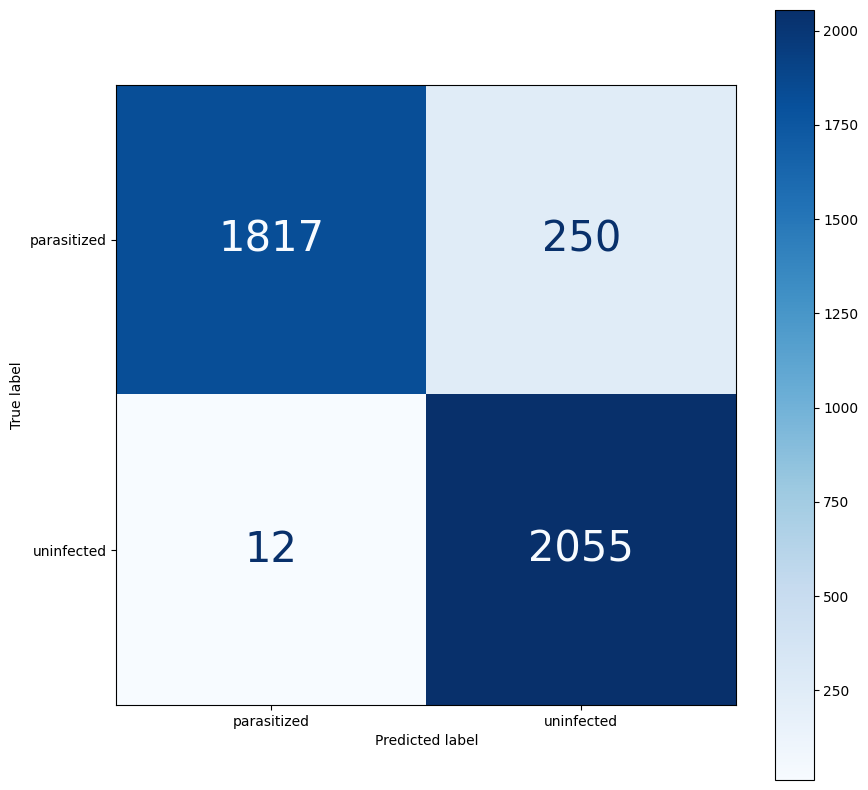

Sensitivity: 0.9941944847605225, Specificity: 0.8790517658442186


In [72]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [73]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.993439  0.879052  0.932752  2067.000000
uninfected     0.891540  0.994194  0.940073  2067.000000
accuracy       0.936623  0.936623  0.936623     0.936623
macro avg      0.942490  0.936623  0.936412  4134.000000
weighted avg   0.942490  0.936623  0.936412  4134.000000

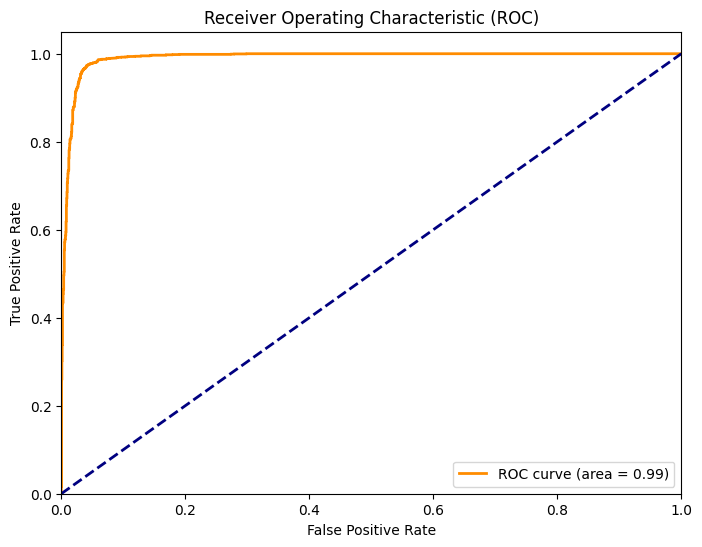

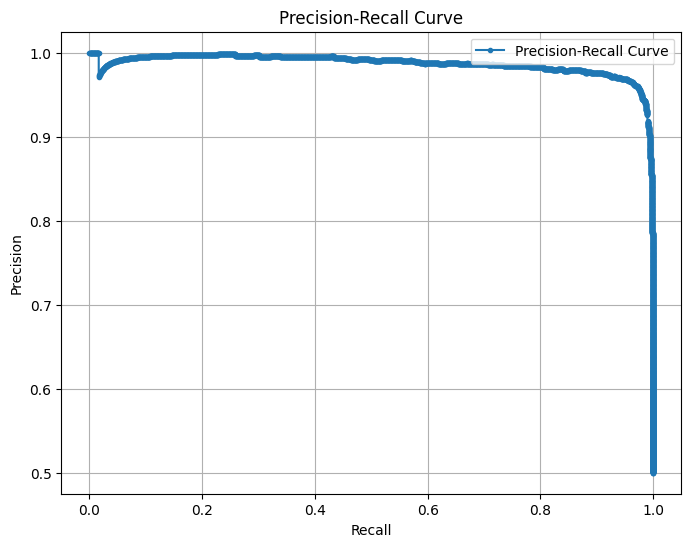

In [77]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# lr = 0.001 in model 2

In [116]:
def Classifier_CNN_2_SE2(input_size=(64,64,3), l2_reg=0.00001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
    parallel_1 = SEBlock(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
    parallel_2 = SEBlock(parallel_2)
       
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    parallel_3 = SEBlock(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)
    
#     # Define the second fully connected layer
#     fc_layer_2 = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(fc_layer_1)
#     fc_layer_2 = BatchNormalization()(fc_layer_2)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(fc_layer_1)
    
    return Model(inputs=[input_layer], outputs=[output_layer])



model2_se2 = Classifier_CNN_2_SE2(input_size=(64,64,3), l2_reg=0.00001)
model2_se2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 64, 64, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 64, 64, 16)   1216        ['input_9[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 64, 64, 16)   2368        ['input_9[0][0]']                
                                                                                            

In [100]:
optimizer1 = tf.keras.optimizers.Adam(learning_rate = 0.001)
model2_se2.compile(optimizer=optimizer1, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se2_lr1 = model2_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 61ms/step - loss: 0.2944 - custom_accuracy: 0.8830 - val_loss: 1.7506 - val_custom_accuracy: 0.5333
Epoch 2/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1930 - custom_accuracy: 0.9341 - val_loss: 0.3046 - val_custom_accuracy: 0.9117
Epoch 3/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1801 - custom_accuracy: 0.9416 - val_loss: 0.2511 - val_custom_accuracy: 0.9170
Epoch 4/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1751 - custom_accuracy: 0.9415 - val_loss: 0.2375 - val_custom_accuracy: 0.9166
Epoch 5/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1732 - custom_accuracy: 0.9436 - val_loss: 0.3915 - val_custom_accuracy: 0.8550
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1663 - custom_accuracy: 0.9458 - val_loss: 0.3262 - val_custom_accuracy: 0.9000
Epoch 7/15
603/603 [==============================] 

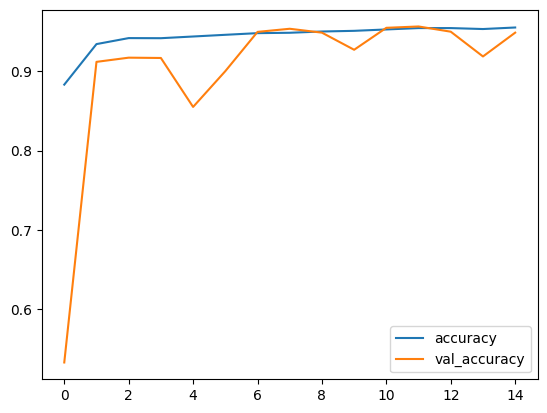

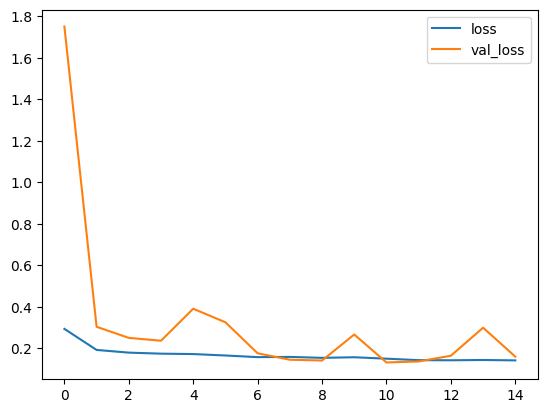

130/130 [==============================] - 4s 28ms/step - loss: 0.1530 - custom_accuracy: 0.9514
Test Accuracy: 0.951442301273346
Test loss: 0.15300731360912323


In [102]:
plt.plot(history2_se2_lr1.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se2_lr1.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se2_lr1.history['loss'], label='loss')
plt.plot(history2_se2_lr1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model2_se2.save('model2_se2_lr1.h5')

test_loss, test_accuracy = model2_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 

In [103]:
predY = model2_se2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 29ms/step


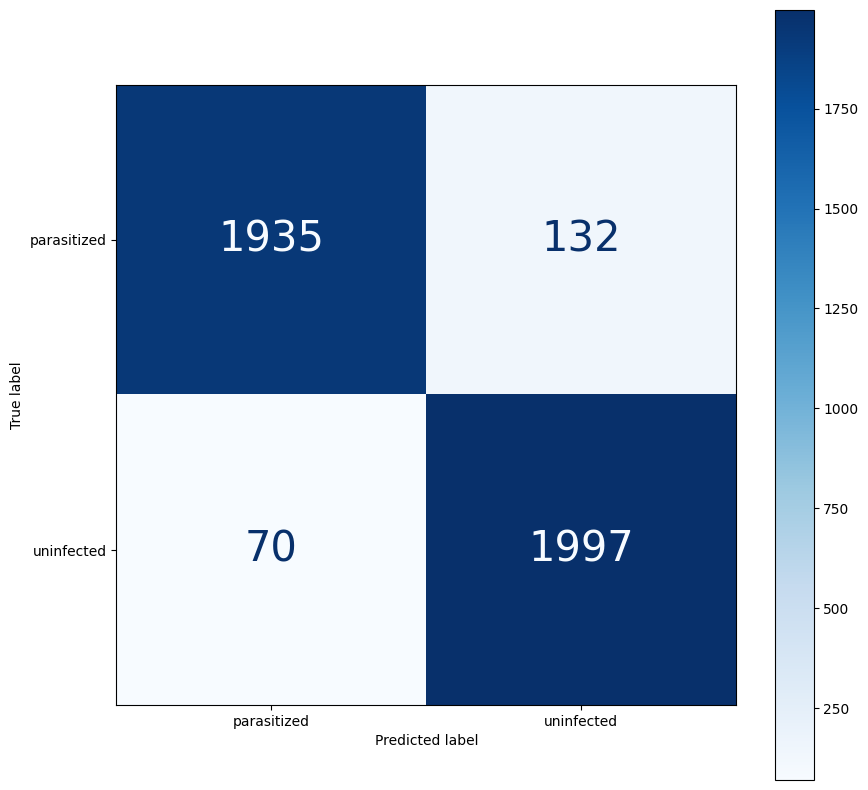

Sensitivity: 0.9661344944363812, Specificity: 0.9361393323657474


In [104]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [105]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df 

precision    recall  f1-score      support
parasitized    0.965087  0.936139  0.950393  2067.000000
uninfected     0.937999  0.966134  0.951859  2067.000000
accuracy       0.951137  0.951137  0.951137     0.951137
macro avg      0.951543  0.951137  0.951126  4134.000000
weighted avg   0.951543  0.951137  0.951126  4134.000000

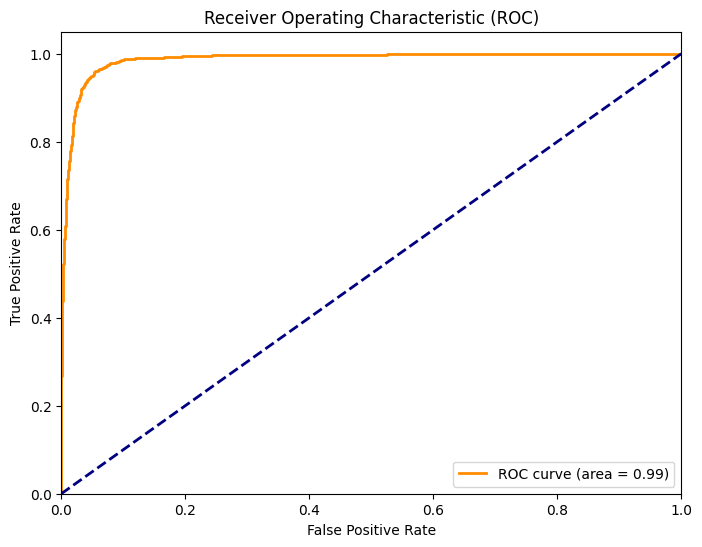

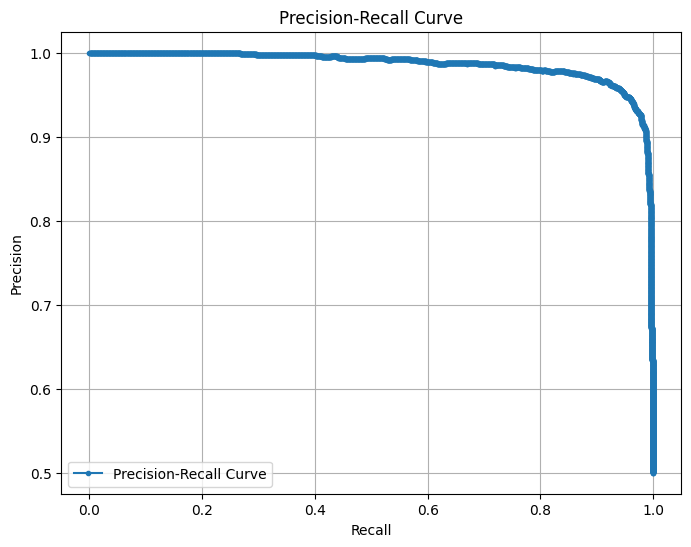

In [106]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# lr = 0.01 in model 2

In [110]:
optimizer2 = tf.keras.optimizers.Adam(learning_rate = 0.01)
model2_se2.compile(optimizer=optimizer2, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se2_lr2 = model2_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 63ms/step - loss: 0.3029 - custom_accuracy: 0.8890 - val_loss: 0.1969 - val_custom_accuracy: 0.9474
Epoch 2/15
603/603 [==============================] - 37s 60ms/step - loss: 0.1907 - custom_accuracy: 0.9448 - val_loss: 0.1586 - val_custom_accuracy: 0.9538
Epoch 3/15
603/603 [==============================] - 36s 60ms/step - loss: 0.1780 - custom_accuracy: 0.9485 - val_loss: 0.5824 - val_custom_accuracy: 0.6907
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1747 - custom_accuracy: 0.9492 - val_loss: 0.1553 - val_custom_accuracy: 0.9534
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1714 - custom_accuracy: 0.9494 - val_loss: 0.1873 - val_custom_accuracy: 0.9528
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1700 - custom_accuracy: 0.9509 - val_loss: 0.1535 - val_custom_accuracy: 0.9505
Epoch 7/15
603/603 [==============================] 

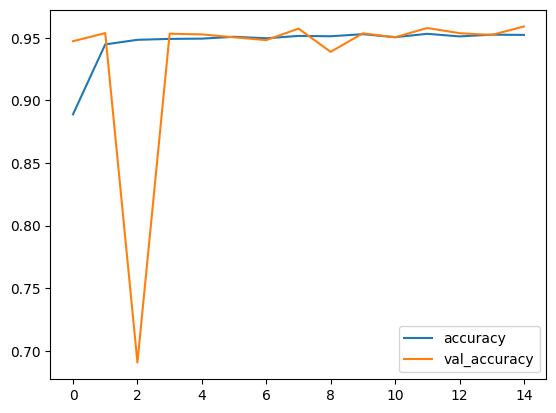

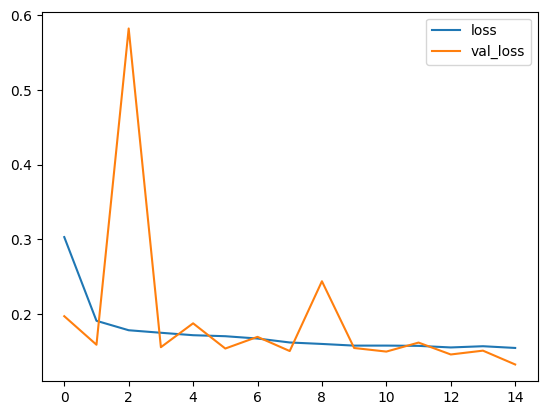

130/130 [==============================] - 4s 28ms/step - loss: 0.1174 - custom_accuracy: 0.9651
Test Accuracy: 0.9651442170143127
Test loss: 0.11735332012176514


In [111]:
plt.plot(history2_se2_lr2.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se2_lr2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se2_lr2.history['loss'], label='loss')
plt.plot(history2_se2_lr2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model2_se2.save('model2_se2_lr2.h5')

test_loss, test_accuracy = model2_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 

In [112]:
predY = model2_se2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 27ms/step


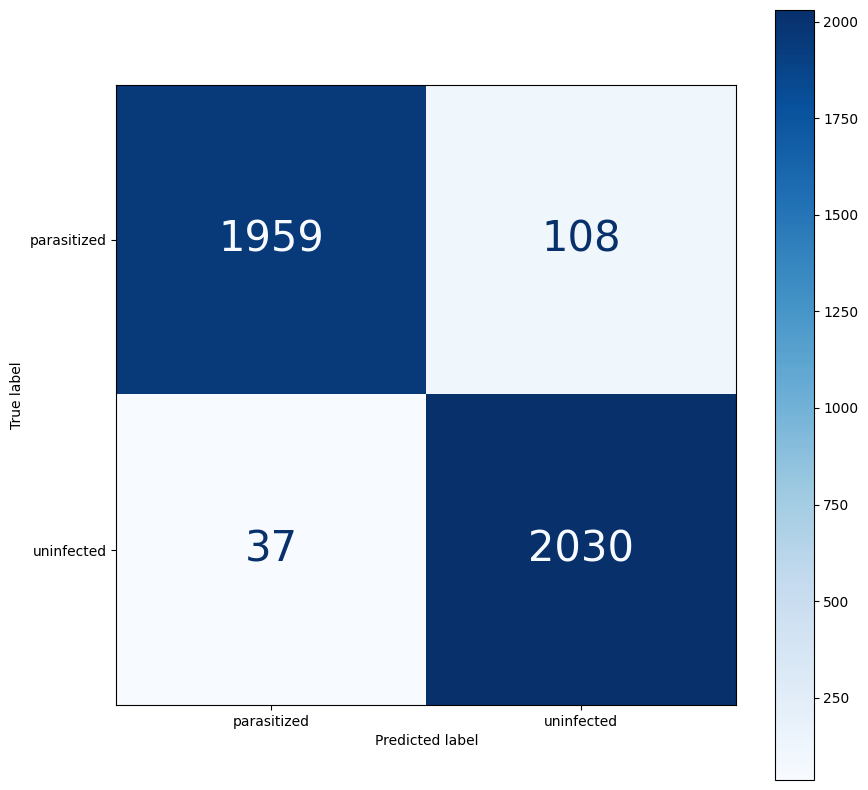

Sensitivity: 0.9820996613449444, Specificity: 0.9477503628447025


In [113]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [114]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df 

precision    recall  f1-score      support
parasitized    0.981463  0.947750  0.964312  2067.000000
uninfected     0.949486  0.982100  0.965517  2067.000000
accuracy       0.964925  0.964925  0.964925     0.964925
macro avg      0.965474  0.964925  0.964915  4134.000000
weighted avg   0.965474  0.964925  0.964915  4134.000000

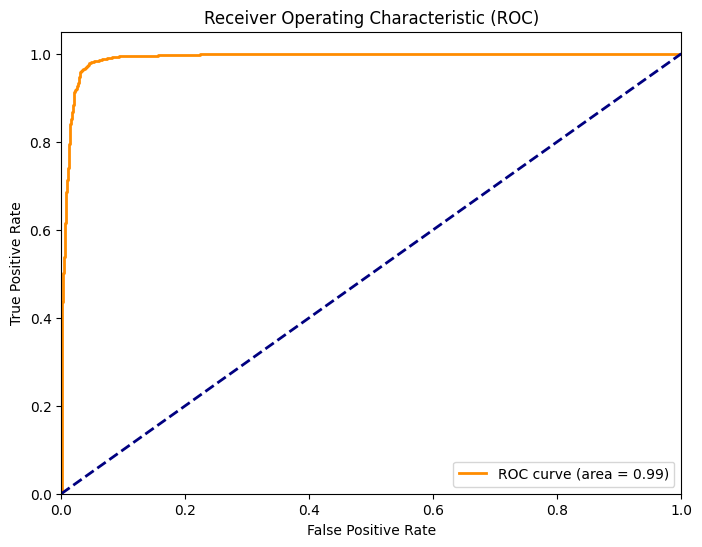

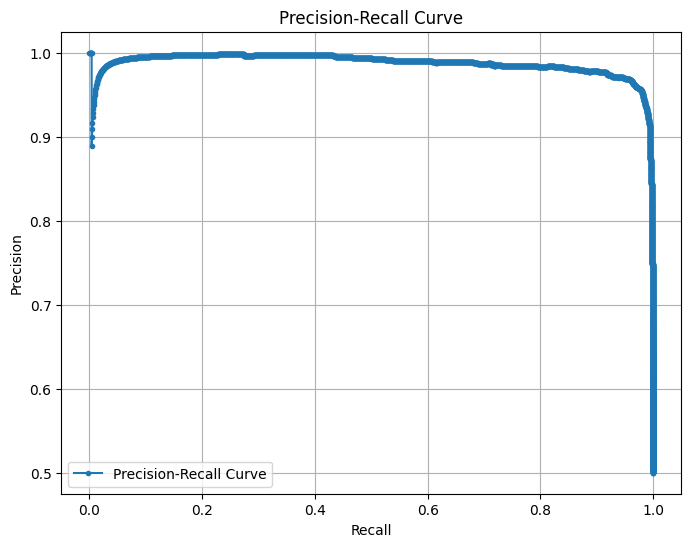

In [115]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# lr = 0.1 in model 2

In [117]:
optimizer3 = tf.keras.optimizers.Adam(learning_rate = 0.1)
model2_se2.compile(optimizer=optimizer3, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se2_lr3 = model2_se2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 39s 62ms/step - loss: 0.6075 - custom_accuracy: 0.8302 - val_loss: 8.2562 - val_custom_accuracy: 0.5000
Epoch 2/15
603/603 [==============================] - 37s 61ms/step - loss: 0.4296 - custom_accuracy: 0.9099 - val_loss: 1.3859 - val_custom_accuracy: 0.5091
Epoch 3/15
603/603 [==============================] - 37s 61ms/step - loss: 0.3701 - custom_accuracy: 0.9211 - val_loss: 0.6019 - val_custom_accuracy: 0.8797
Epoch 4/15
603/603 [==============================] - 37s 62ms/step - loss: 0.2913 - custom_accuracy: 0.9336 - val_loss: 0.2360 - val_custom_accuracy: 0.9483
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2453 - custom_accuracy: 0.9370 - val_loss: 0.3310 - val_custom_accuracy: 0.9292
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2633 - custom_accuracy: 0.9356 - val_loss: 0.3649 - val_custom_accuracy: 0.9184
Epoch 7/15
603/603 [==============================] 

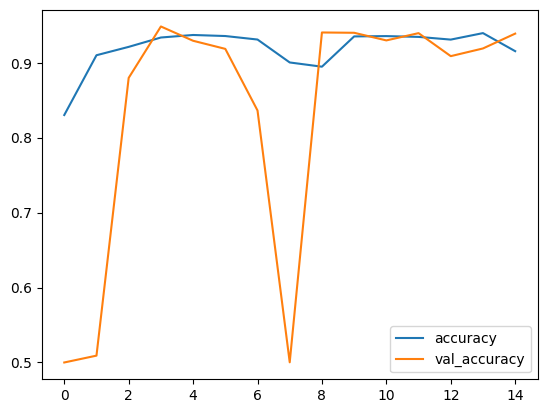

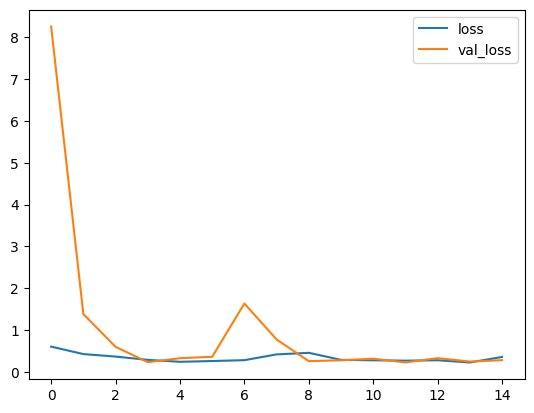

130/130 [==============================] - 4s 28ms/step - loss: 0.2690 - custom_accuracy: 0.9469
Test Accuracy: 0.9468749761581421
Test loss: 0.2689720094203949


In [118]:
plt.plot(history2_se2_lr3.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se2_lr3.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se2_lr3.history['loss'], label='loss')
plt.plot(history2_se2_lr3.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

model2_se2.save('model2_se2_lr3.h5')

test_loss, test_accuracy = model2_se2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 

In [119]:
predY = model1_se2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


130/130 [==============================] - 3s 26ms/step


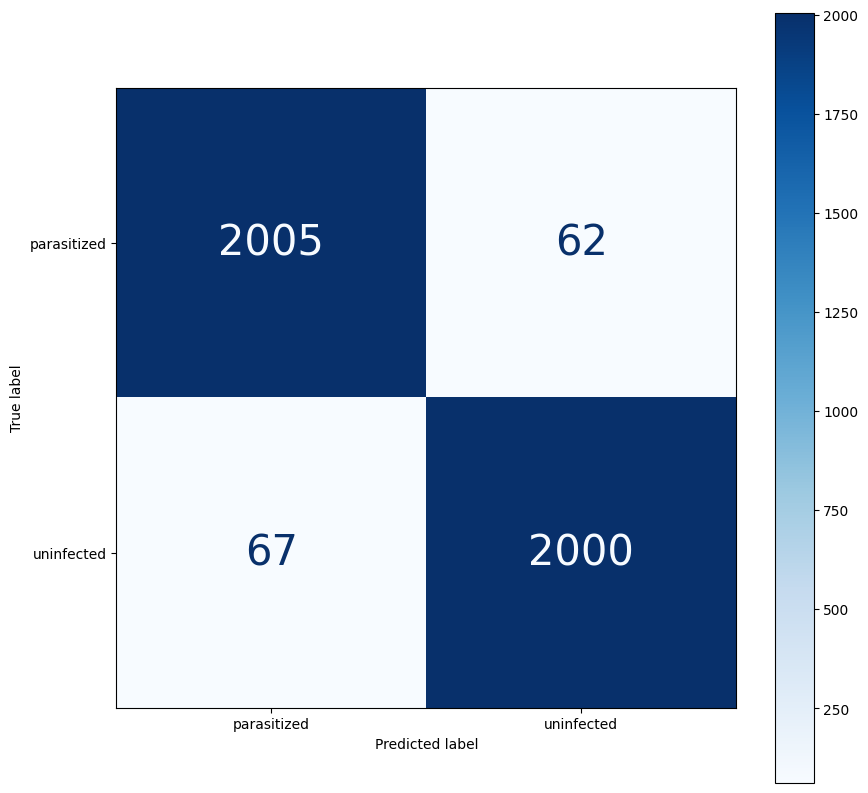

Sensitivity: 0.9675858732462506, Specificity: 0.9700048379293662


In [120]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [121]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df 

precision    recall  f1-score      support
parasitized    0.967664  0.970005  0.968833  2067.000000
uninfected     0.969932  0.967586  0.968758  2067.000000
accuracy       0.968795  0.968795  0.968795     0.968795
macro avg      0.968798  0.968795  0.968795  4134.000000
weighted avg   0.968798  0.968795  0.968795  4134.000000

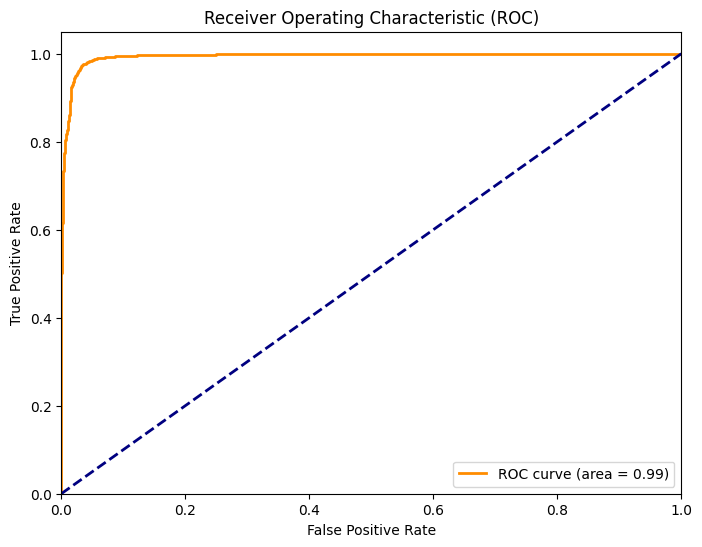

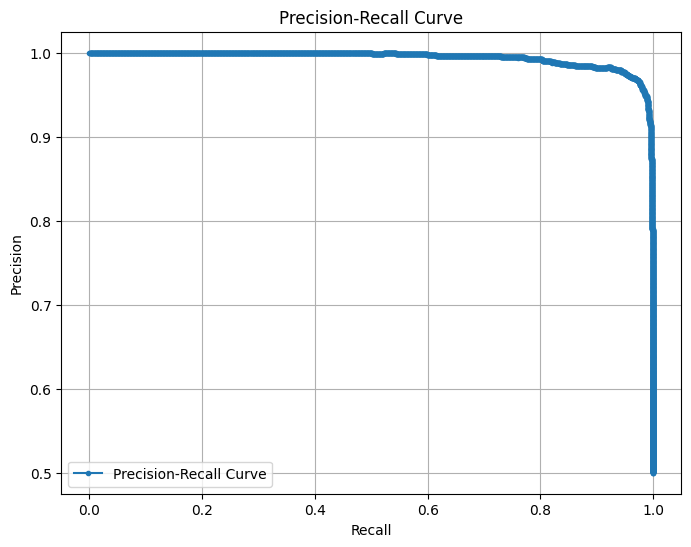

In [122]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# lr= 0.0001 in Ensemble model

In [11]:
from tensorflow.keras.models import load_model
model1 = load_model('model1_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})
model2 = load_model('model2_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})


for layer in model1.layers:
    layer.trainable = False

for layer in model2.layers:
    layer.trainable = False

common_input = Input(shape=(64, 64, 3))

output1 = model1.layers[-4].output
output2 = model2.layers[-5].output


model1_with_common_input = Model(inputs=model1.input, outputs=output1)
model2_with_common_input = Model(inputs=model2.input, outputs=output2)

output1_from_common = model1_with_common_input(common_input)
output2_from_common = model2_with_common_input(common_input)

merged_outputs = concatenate([output1_from_common, output2_from_common])
merged_outputs = Flatten()(merged_outputs)


output = Dense(1, activation='sigmoid')(merged_outputs)

ensemble_model = Model(inputs=common_input, outputs=output)

ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 8, 8, 128)    246480      ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 8, 8, 128)    60406       ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 8, 8, 256)    0           ['model[0][0]',                  
                                                                  'model_1[0][0]']          

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
ensemble_model.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_ensemble = ensemble_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))



Epoch 1/15
603/603 [==============================] - 40s 64ms/step - loss: 0.1666 - custom_accuracy: 0.9393 - val_loss: 0.1325 - val_custom_accuracy: 0.9515
Epoch 2/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1286 - custom_accuracy: 0.9558 - val_loss: 0.1420 - val_custom_accuracy: 0.9524
Epoch 3/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1246 - custom_accuracy: 0.9583 - val_loss: 0.1572 - val_custom_accuracy: 0.9510
Epoch 4/15
603/603 [==============================] - 38s 62ms/step - loss: 0.1245 - custom_accuracy: 0.9582 - val_loss: 0.1261 - val_custom_accuracy: 0.9601
Epoch 5/15
603/603 [==============================] - 37s 62ms/step - loss: 0.1248 - custom_accuracy: 0.9568 - val_loss: 0.1474 - val_custom_accuracy: 0.9523
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.1194 - custom_accuracy: 0.9597 - val_loss: 0.1416 - val_custom_accuracy: 0.9553
Epoch 7/15
603/603 [==============================] 

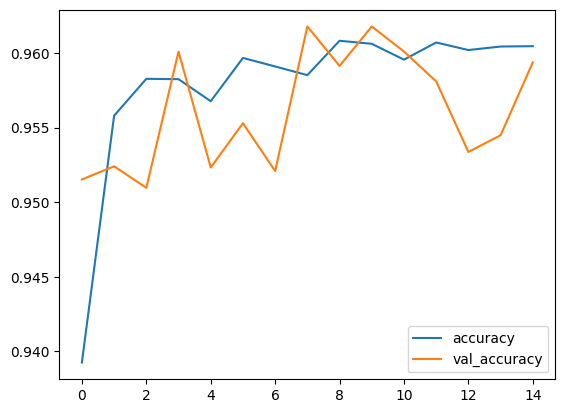

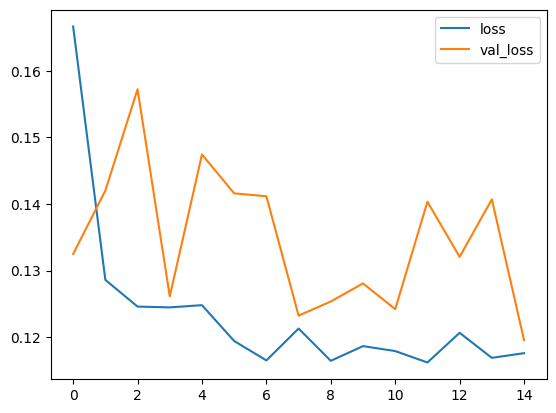

130/130 [==============================] - 17s 128ms/step - loss: 0.1108 - custom_accuracy: 0.9623
Test Accuracy: 0.9622595906257629
Test loss: 0.11082962900400162


In [38]:
plt.plot(history_ensemble.history['custom_accuracy'], label='accuracy')
plt.plot(history_ensemble.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ensemble.history['loss'], label='loss')
plt.plot(history_ensemble.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = ensemble_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

# ensemble_model.save('ensemble_model_1.h5')


In [39]:
predY = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


130/130 [==============================] - 4s 28ms/step


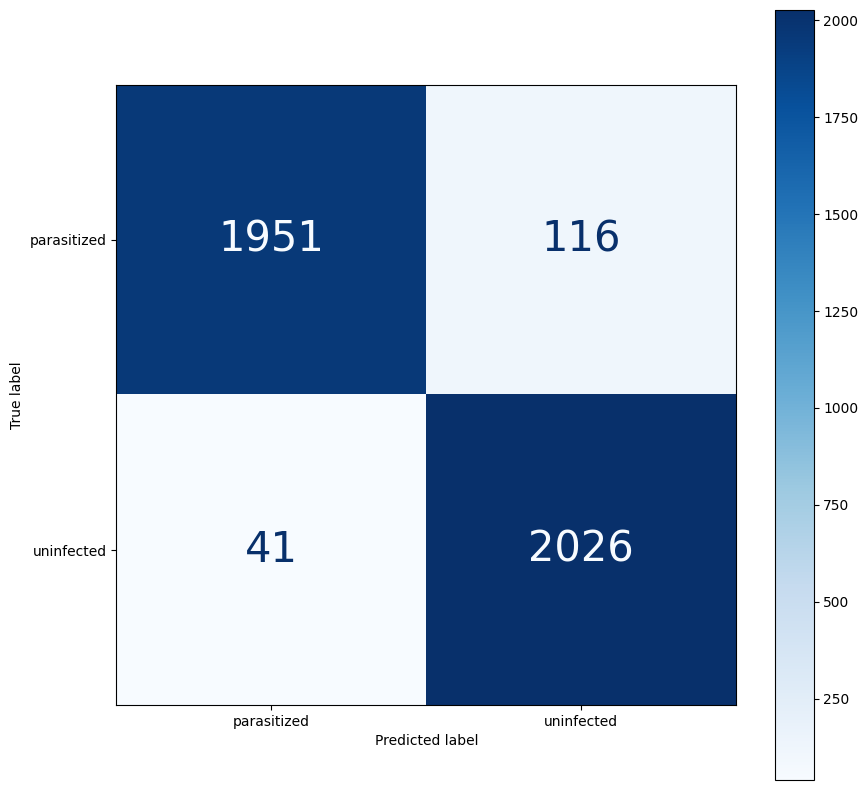

Sensitivity: 0.9801644895984518, Specificity: 0.9438800193517175


In [40]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [41]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.979418  0.943880  0.961321  2067.000000
uninfected     0.945845  0.980164  0.962699  2067.000000
accuracy       0.962022  0.962022  0.962022     0.962022
macro avg      0.962631  0.962022  0.962010  4134.000000
weighted avg   0.962631  0.962022  0.962010  4134.000000

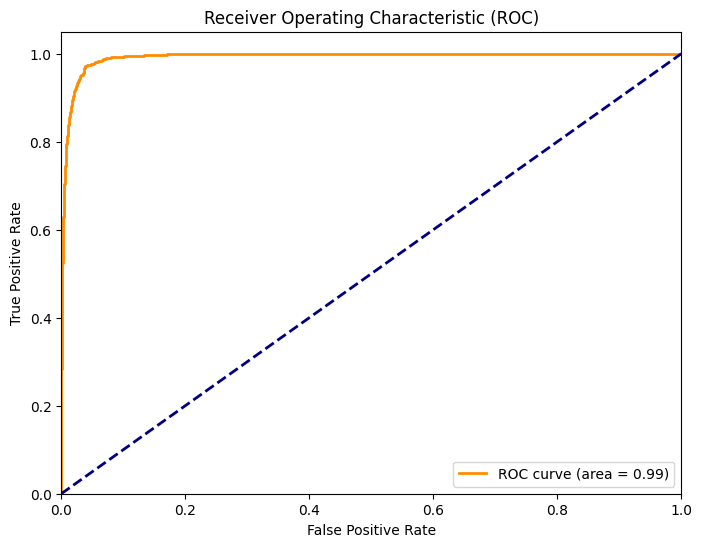

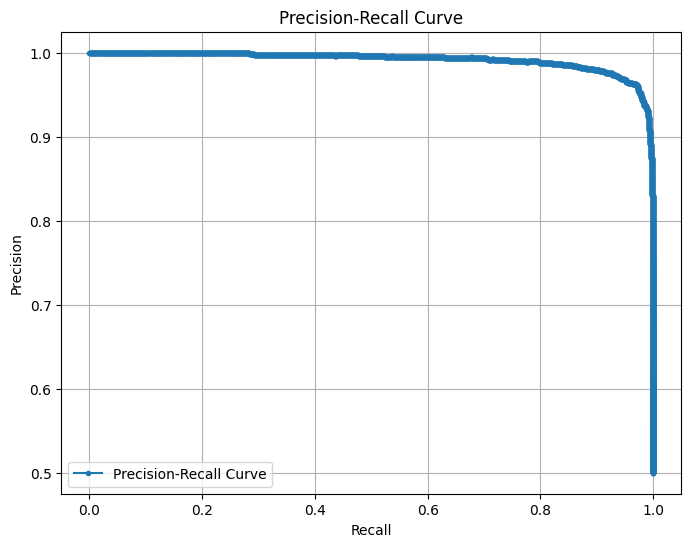

In [42]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# lr= 0.001 in Ensemble model

In [45]:
optimizer_2 = tf.keras.optimizers.Adam(learning_rate = 0.001)
ensemble_model.compile(optimizer=optimizer_2, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_ensemble_2 = ensemble_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))


Epoch 1/15
603/603 [==============================] - 39s 62ms/step - loss: 0.2523 - custom_accuracy: 0.9364 - val_loss: 0.2835 - val_custom_accuracy: 0.9493
Epoch 2/15
603/603 [==============================] - 37s 62ms/step - loss: 0.2682 - custom_accuracy: 0.9447 - val_loss: 0.2860 - val_custom_accuracy: 0.9464
Epoch 3/15
603/603 [==============================] - 38s 63ms/step - loss: 0.2867 - custom_accuracy: 0.9476 - val_loss: 0.3549 - val_custom_accuracy: 0.9507
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2898 - custom_accuracy: 0.9479 - val_loss: 0.3589 - val_custom_accuracy: 0.9522
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.2916 - custom_accuracy: 0.9474 - val_loss: 0.3591 - val_custom_accuracy: 0.9517
Epoch 6/15
603/603 [==============================] - 36s 60ms/step - loss: 0.3203 - custom_accuracy: 0.9453 - val_loss: 0.3808 - val_custom_accuracy: 0.9485
Epoch 7/15
603/603 [==============================] 

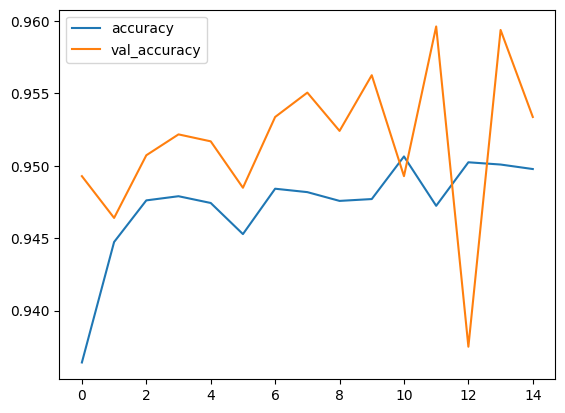

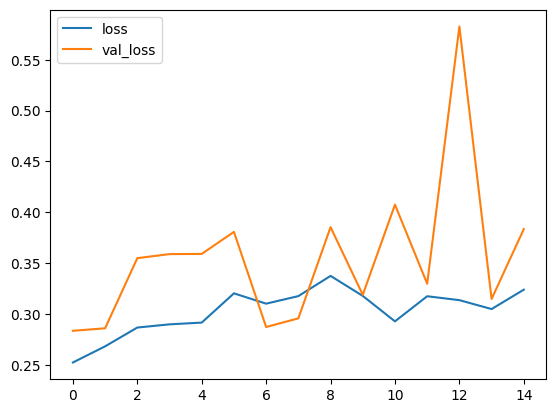

130/130 [==============================] - 4s 28ms/step - loss: 0.3488 - custom_accuracy: 0.9591
Test Accuracy: 0.9591346383094788
Test loss: 0.348798006772995


In [51]:
plt.plot(history_ensemble_2.history['custom_accuracy'], label='accuracy')
plt.plot(history_ensemble_2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ensemble_2.history['loss'], label='loss')
plt.plot(history_ensemble_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = ensemble_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )


In [52]:
predY = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


130/130 [==============================] - 4s 28ms/step


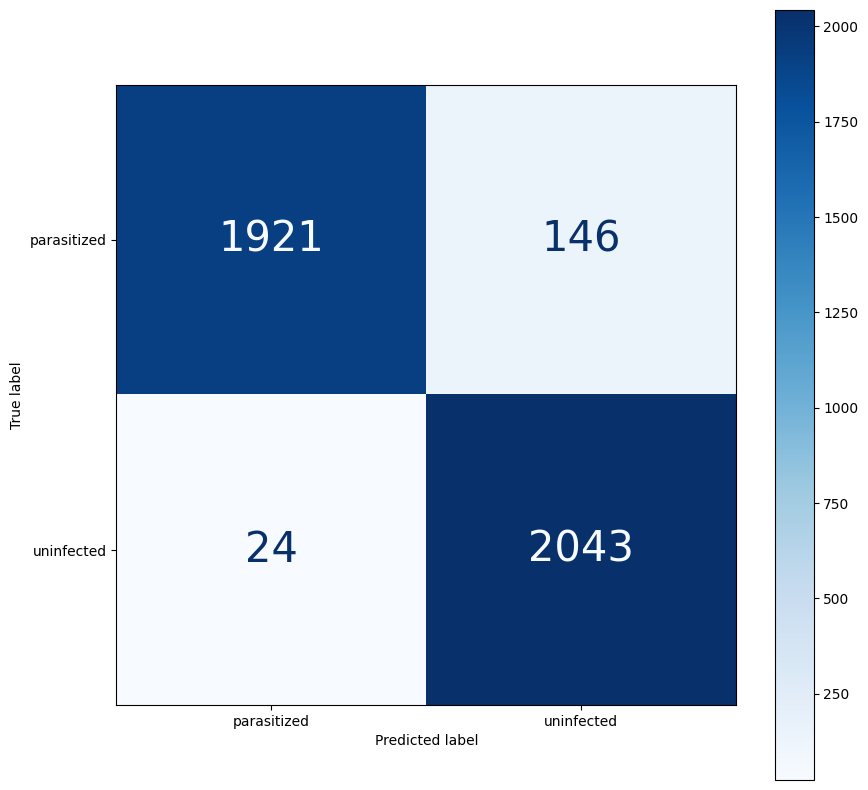

Sensitivity: 0.988388969521045, Specificity: 0.9293662312530238


In [53]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [54]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.987661  0.929366  0.957627  2067.000000
uninfected     0.933303  0.988389  0.960056  2067.000000
accuracy       0.958878  0.958878  0.958878     0.958878
macro avg      0.960482  0.958878  0.958842  4134.000000
weighted avg   0.960482  0.958878  0.958842  4134.000000

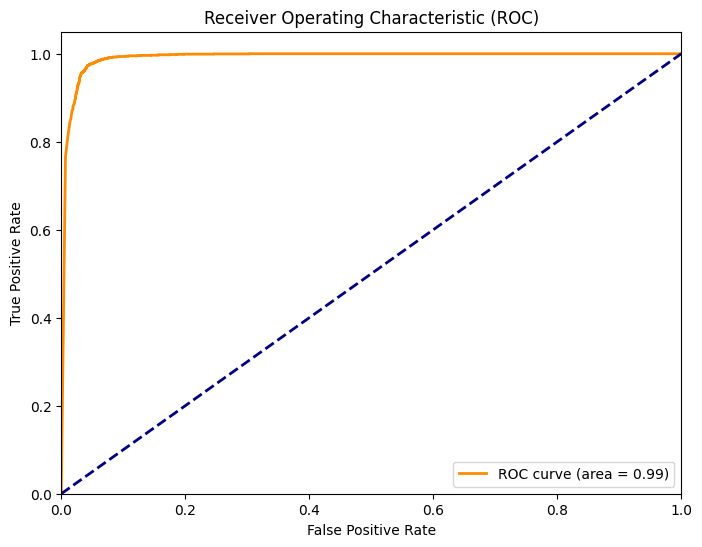

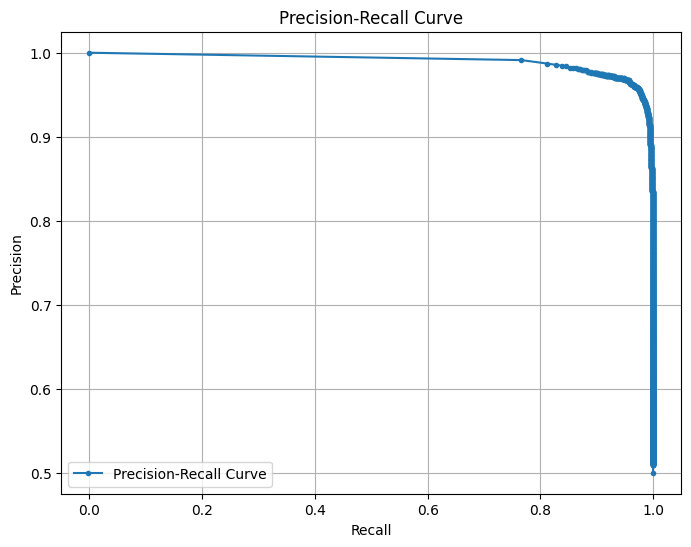

In [55]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# lr= 0.01 in Ensemble model

In [60]:
from tensorflow.keras.models import load_model
model1 = load_model('model1_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})
model2 = load_model('model2_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})


for layer in model1.layers:
    layer.trainable = False

for layer in model2.layers:
    layer.trainable = False

common_input = Input(shape=(64, 64, 3))

output1 = model1.layers[-4].output
output2 = model2.layers[-5].output


model1_with_common_input = Model(inputs=model1.input, outputs=output1)
model2_with_common_input = Model(inputs=model2.input, outputs=output2)

output1_from_common = model1_with_common_input(common_input)
output2_from_common = model2_with_common_input(common_input)

merged_outputs = concatenate([output1_from_common, output2_from_common])
merged_outputs = Flatten()(merged_outputs)


output = Dense(1, activation='sigmoid')(merged_outputs)

ensemble_model = Model(inputs=common_input, outputs=output)

ensemble_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
ensemble_model.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_ensemble = ensemble_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model_21 (Functional)          (None, 8, 8, 128)    246480      ['input_8[0][0]']                
                                                                                                  
 model_22 (Functional)          (None, 8, 8, 128)    60406       ['input_8[0][0]']                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 8, 8, 256)    0           ['model_21[0][0]',               
                                                                  'model_22[0][0]']        

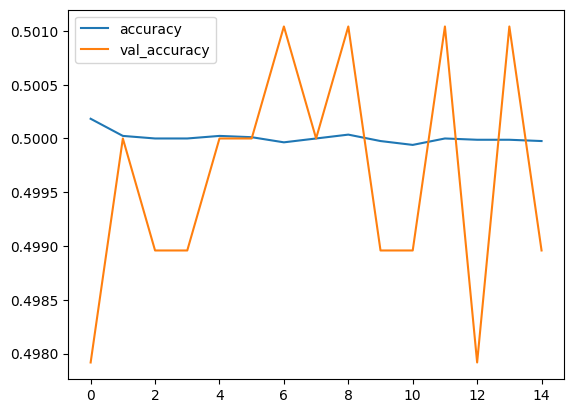

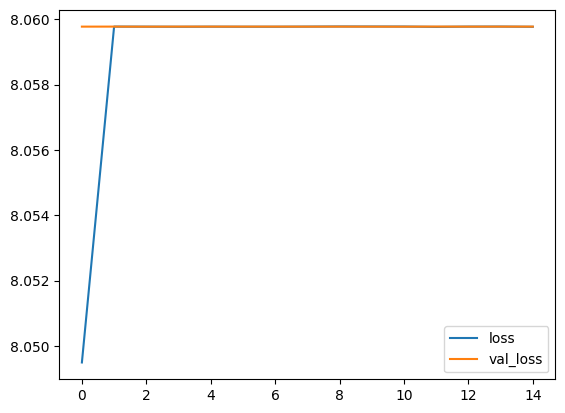

130/130 [==============================] - 4s 29ms/step - loss: 8.0598 - custom_accuracy: 0.4969
Test Accuracy: 0.49687498807907104
Test loss: 8.05978012084961


In [61]:

plt.plot(history_ensemble.history['custom_accuracy'], label='accuracy')
plt.plot(history_ensemble.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ensemble.history['loss'], label='loss')
plt.plot(history_ensemble.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = ensemble_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [62]:
predY = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 27ms/step


D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


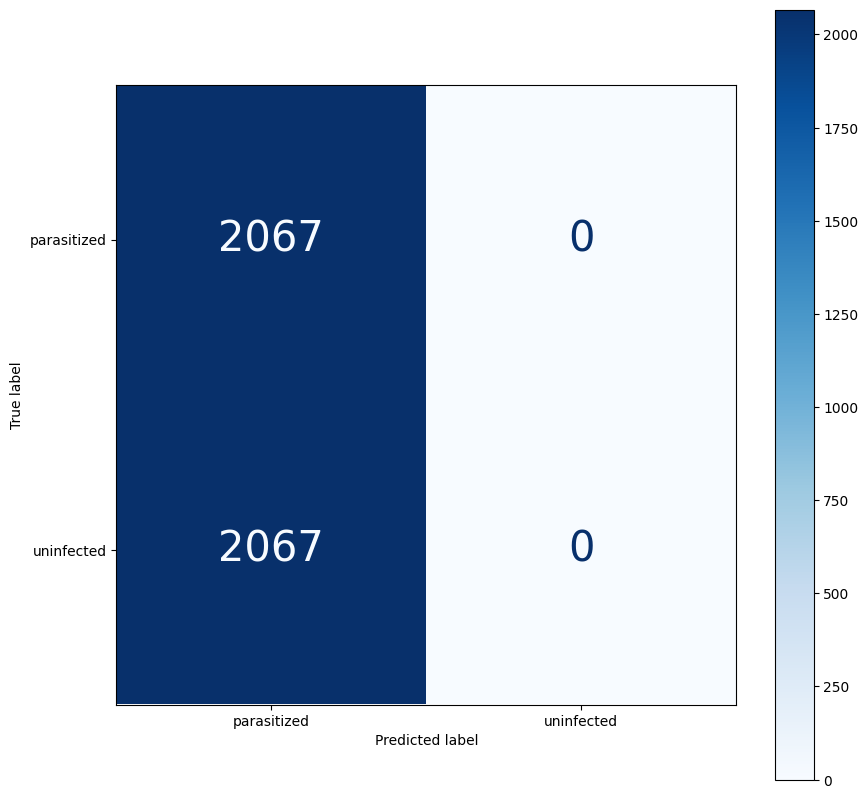

Sensitivity: 0.0, Specificity: 1.0


In [63]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [64]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  recall  f1-score  support
parasitized        0.50     1.0  0.666667   2067.0
uninfected         0.00     0.0  0.000000   2067.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333   4134.0
weighted avg       0.25     0.5  0.333333   4134.0

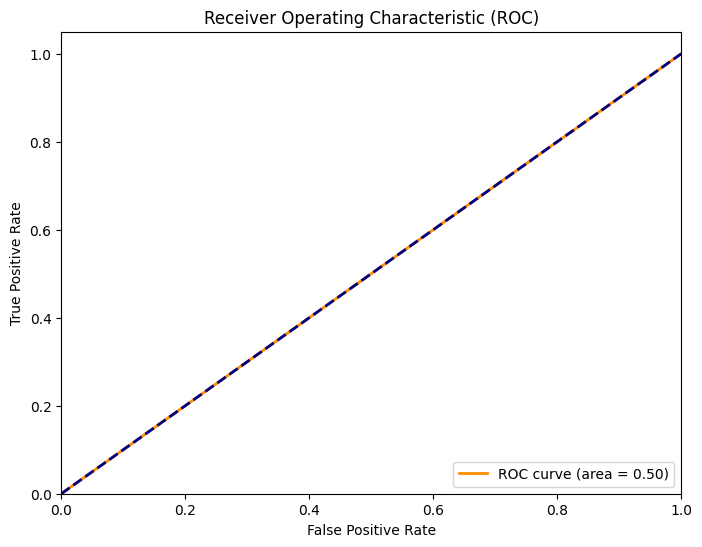

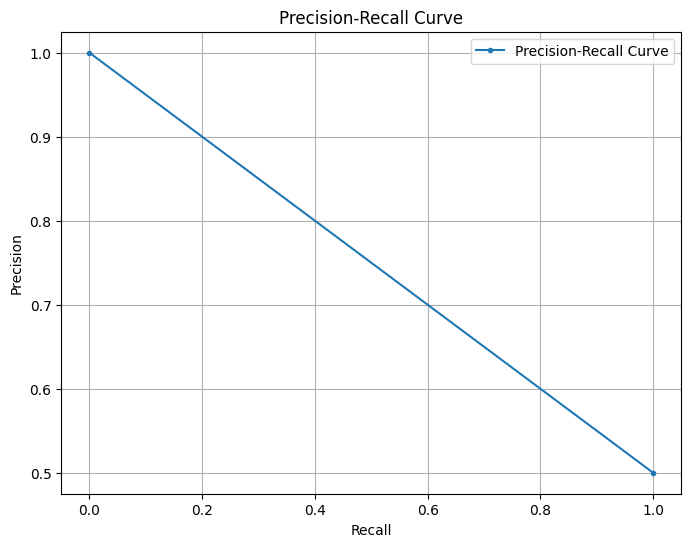

In [65]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# lr= 0.1 in Ensemble model

In [12]:
optimizer_4 = tf.keras.optimizers.Adam(learning_rate = 0.1)
ensemble_model.compile(optimizer=optimizer_4, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_ensemble_4 = ensemble_model.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))


Epoch 1/15
603/603 [==============================] - 106s 166ms/step - loss: 7.7513 - custom_accuracy: 0.5167 - val_loss: 8.0598 - val_custom_accuracy: 0.5000
Epoch 2/15
603/603 [==============================] - 37s 62ms/step - loss: 8.0598 - custom_accuracy: 0.5000 - val_loss: 8.0598 - val_custom_accuracy: 0.4990
Epoch 3/15
603/603 [==============================] - 38s 62ms/step - loss: 8.0598 - custom_accuracy: 0.5000 - val_loss: 8.0598 - val_custom_accuracy: 0.4990
Epoch 4/15
603/603 [==============================] - 38s 62ms/step - loss: 8.0598 - custom_accuracy: 0.5000 - val_loss: 8.0598 - val_custom_accuracy: 0.4979
Epoch 5/15
603/603 [==============================] - 37s 62ms/step - loss: 8.0598 - custom_accuracy: 0.5000 - val_loss: 8.0598 - val_custom_accuracy: 0.4990
Epoch 6/15
603/603 [==============================] - 38s 63ms/step - loss: 8.0598 - custom_accuracy: 0.5000 - val_loss: 8.0598 - val_custom_accuracy: 0.5000
Epoch 7/15
603/603 [==============================

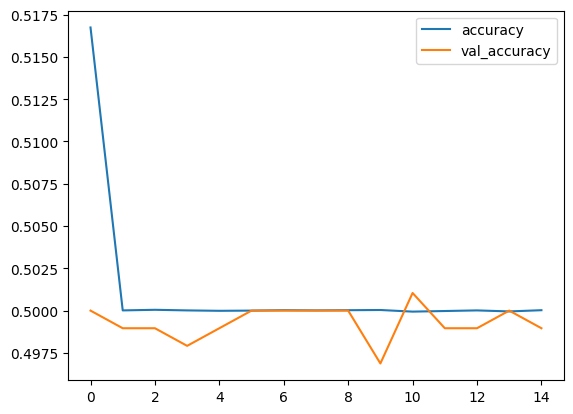

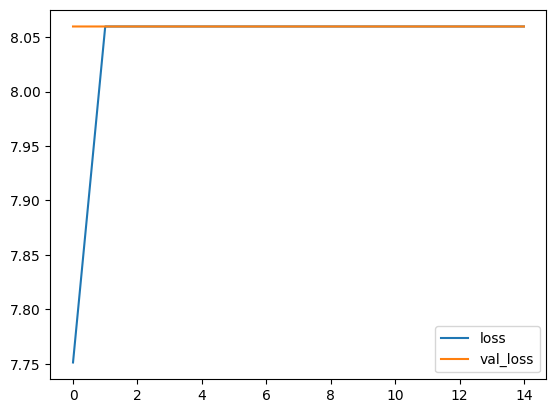

130/130 [==============================] - 5s 37ms/step - loss: 8.0598 - custom_accuracy: 0.4969
Test Accuracy: 0.49687498807907104
Test loss: 8.05978012084961


In [13]:
plt.plot(history_ensemble_4.history['custom_accuracy'], label='accuracy')
plt.plot(history_ensemble_4.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_ensemble_4.history['loss'], label='loss')
plt.plot(history_ensemble_4.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = ensemble_model.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )


In [14]:
predY = ensemble_model.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 28ms/step


D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


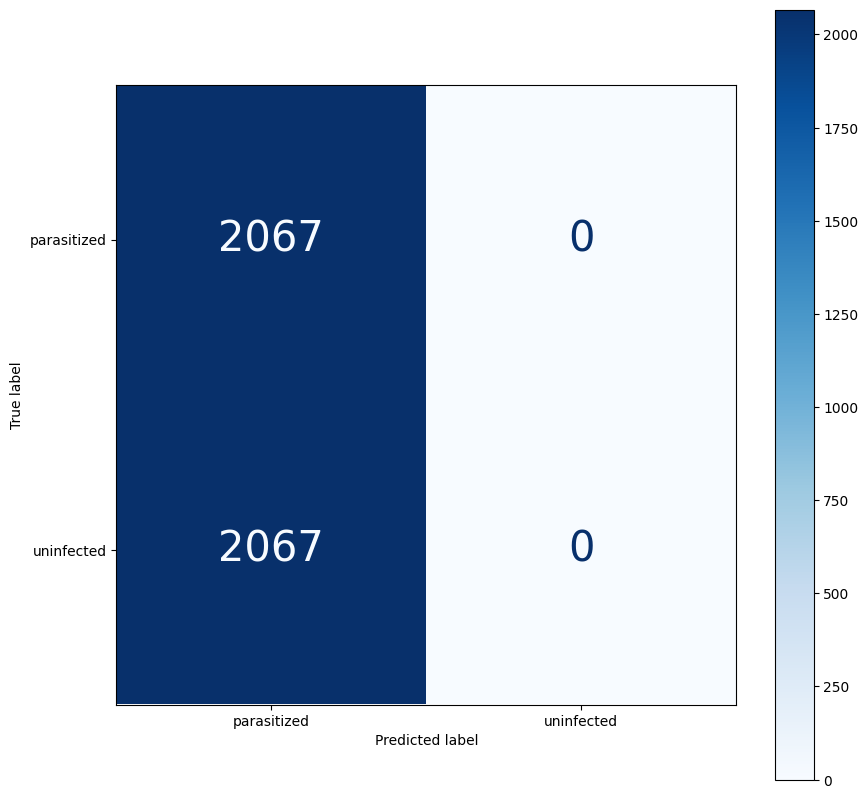

Sensitivity: 0.0, Specificity: 1.0


In [15]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [16]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Machine\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision  recall  f1-score  support
parasitized        0.50     1.0  0.666667   2067.0
uninfected         0.00     0.0  0.000000   2067.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333   4134.0
weighted avg       0.25     0.5  0.333333   4134.0

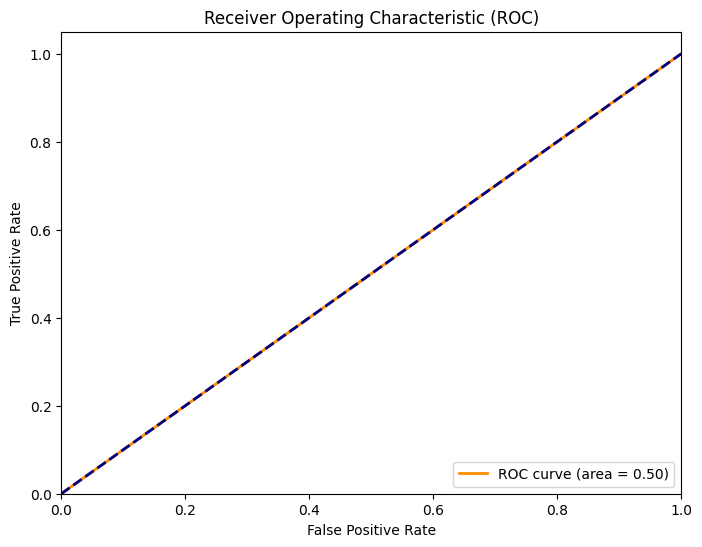

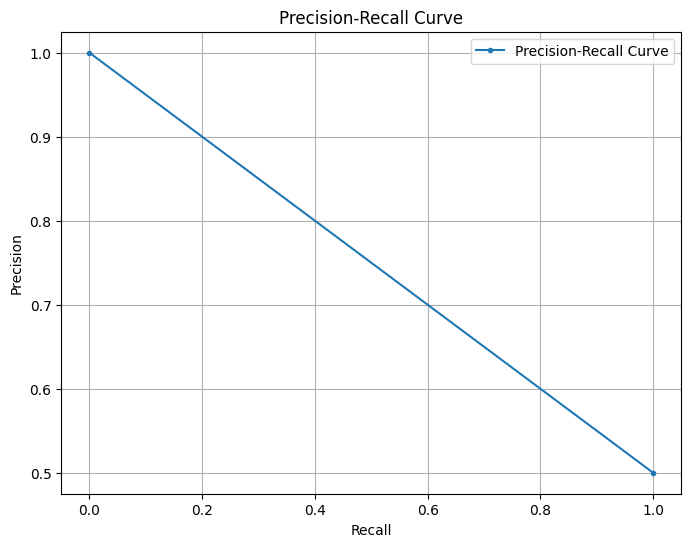

In [17]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Model 1 with Dropout（0.3）

In [27]:
from keras.layers import Dropout
def Classifier_CNN_1_SE2_With_drop(input_size=(64,64,3), l2_reg=0.00001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(bn3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    # SE block after all conv and pooling layers
    se_final = SEBlock(pool4) 
    
    # Fully connected layers
    gap = GlobalAveragePooling2D()(se_final)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    d = Dropout(0.3)(dense1)
    # Output layer
    output = Dense(1, activation='sigmoid')(d)

    return Model(inputs=[inputs], outputs=[output])

In [28]:
model1_se2_drop_1 = Classifier_CNN_1_SE2_With_drop(input_size=(64,64,3), l2_reg=0.00001)
model1_se2_drop_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 32)   896         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 64, 64, 32)  128         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 32, 32, 32)  0           ['batch_normalization_12[0]

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_se2_drop_1.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2_drop_1 = model1_se2_drop_1.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 43s 65ms/step - loss: 0.4060 - custom_accuracy: 0.8166 - val_loss: 0.5263 - val_custom_accuracy: 0.7636
Epoch 2/15
603/603 [==============================] - 38s 64ms/step - loss: 0.2001 - custom_accuracy: 0.9272 - val_loss: 0.2629 - val_custom_accuracy: 0.9136
Epoch 3/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1788 - custom_accuracy: 0.9396 - val_loss: 0.1717 - val_custom_accuracy: 0.9385
Epoch 4/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1631 - custom_accuracy: 0.9445 - val_loss: 0.1916 - val_custom_accuracy: 0.9339
Epoch 5/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1531 - custom_accuracy: 0.9478 - val_loss: 0.1853 - val_custom_accuracy: 0.9380
Epoch 6/15
603/603 [==============================] - 38s 64ms/step - loss: 0.1470 - custom_accuracy: 0.9516 - val_loss: 0.1715 - val_custom_accuracy: 0.9439
Epoch 7/15
603/603 [==============================] 

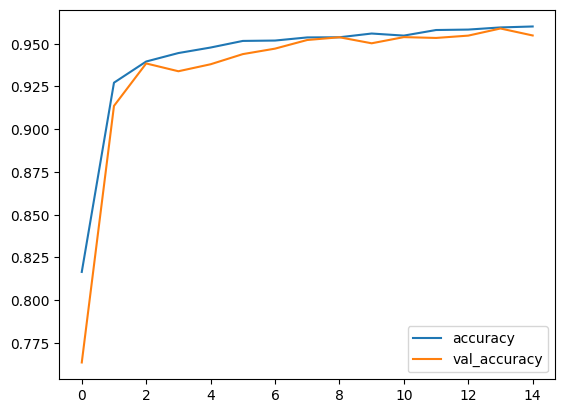

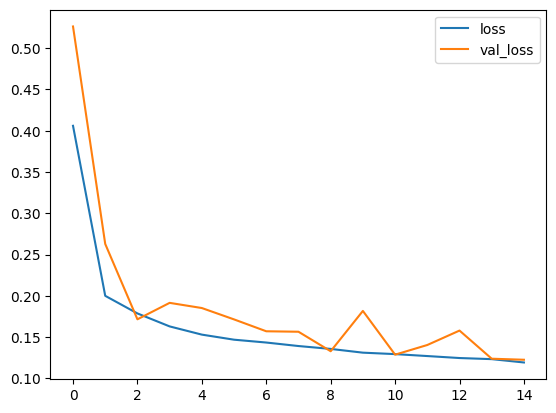

130/130 [==============================] - 4s 29ms/step - loss: 0.1092 - custom_accuracy: 0.9644
Test Accuracy: 0.9644230604171753
Test loss: 0.10920742899179459


In [30]:
plt.plot(history_se2_drop_1.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2_drop_1.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2_drop_1.history['loss'], label='loss')
plt.plot(history_se2_drop_1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model1_se2_drop_1.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [31]:
predY = model1_se2_drop_1.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


130/130 [==============================] - 4s 27ms/step


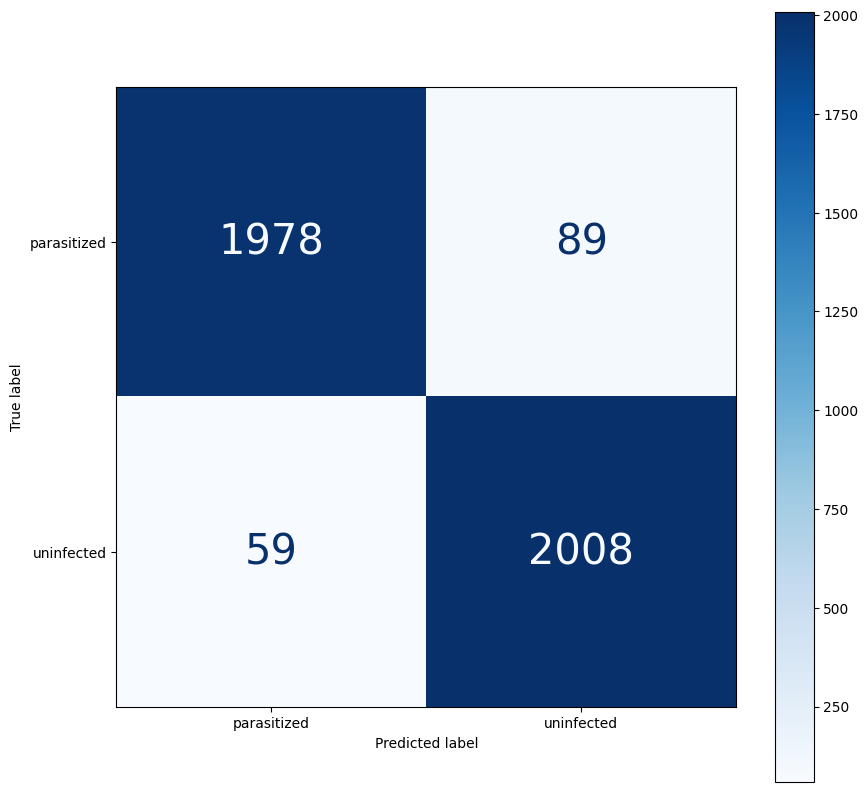

Sensitivity: 0.9714562167392357, Specificity: 0.9569424286405418


In [32]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [33]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


precision    recall  f1-score      support
parasitized    0.971036  0.956942  0.963938  2067.000000
uninfected     0.957558  0.971456  0.964457  2067.000000
accuracy       0.964199  0.964199  0.964199     0.964199
macro avg      0.964297  0.964199  0.964197  4134.000000
weighted avg   0.964297  0.964199  0.964197  4134.000000

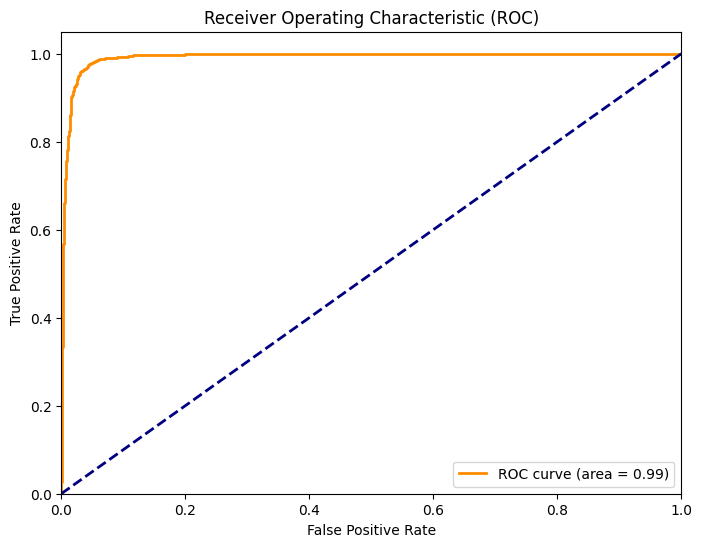

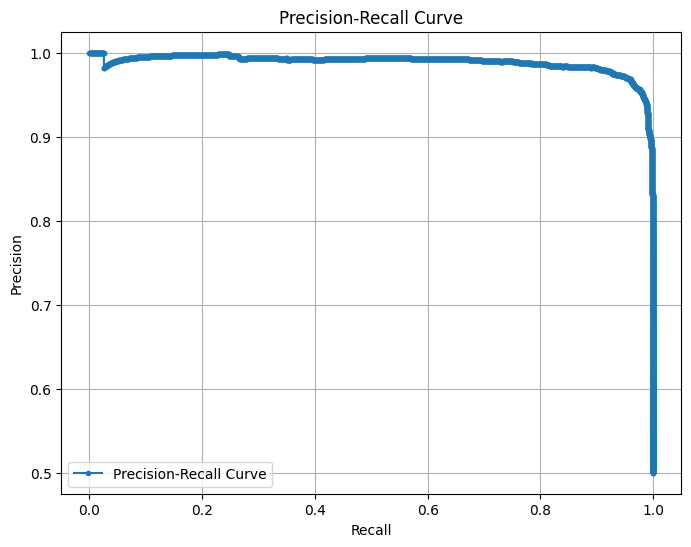

In [34]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
 

# Model 1 with Dropout（0.5）

In [35]:
from keras.layers import Dropout
def Classifier_CNN_1_SE2_With_drop(input_size=(64,64,3), l2_reg=0.00001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(bn3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    # SE block after all conv and pooling layers
    se_final = SEBlock(pool4) 
    
    # Fully connected layers
    gap = GlobalAveragePooling2D()(se_final)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    d = Dropout(0.5)(dense1)
    # Output layer
    output = Dense(1, activation='sigmoid')(d)

    return Model(inputs=[inputs], outputs=[output])

In [36]:
model1_se2_drop_2 = Classifier_CNN_1_SE2_With_drop(input_size=(64,64,3), l2_reg=0.00001)
model1_se2_drop_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 32)   896         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 64, 64, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 32, 32, 32)  0           ['batch_normalization_16[0]

In [37]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_se2_drop_2.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2_drop_2 = model1_se2_drop_2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 40s 65ms/step - loss: 0.3790 - custom_accuracy: 0.8324 - val_loss: 0.7936 - val_custom_accuracy: 0.6772
Epoch 2/15
603/603 [==============================] - 39s 65ms/step - loss: 0.2013 - custom_accuracy: 0.9286 - val_loss: 0.1907 - val_custom_accuracy: 0.9279
Epoch 3/15
603/603 [==============================] - 39s 64ms/step - loss: 0.1753 - custom_accuracy: 0.9401 - val_loss: 0.1763 - val_custom_accuracy: 0.9353
Epoch 4/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1596 - custom_accuracy: 0.9450 - val_loss: 0.1793 - val_custom_accuracy: 0.9368
Epoch 5/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1522 - custom_accuracy: 0.9477 - val_loss: 0.1545 - val_custom_accuracy: 0.9438
Epoch 6/15
603/603 [==============================] - 40s 67ms/step - loss: 0.1485 - custom_accuracy: 0.9487 - val_loss: 0.1601 - val_custom_accuracy: 0.9471
Epoch 7/15
603/603 [==============================] 

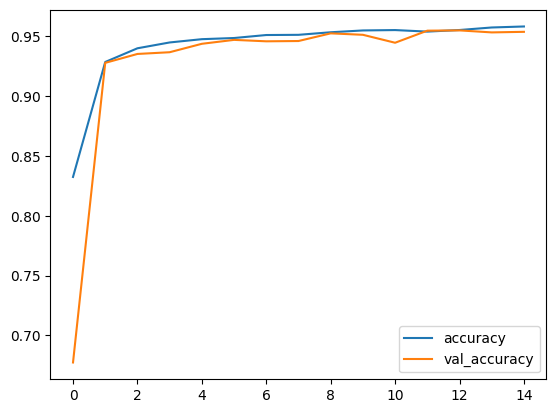

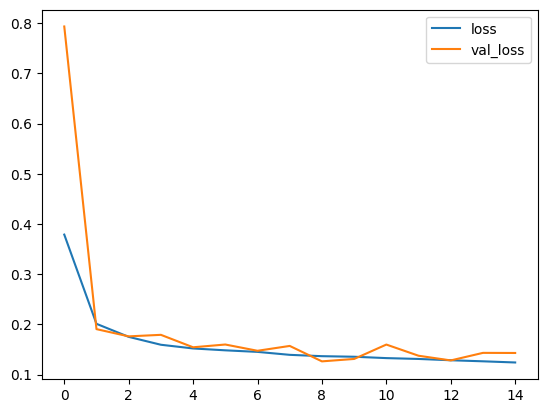

130/130 [==============================] - 4s 27ms/step - loss: 0.1308 - custom_accuracy: 0.9572
Test Accuracy: 0.9572115540504456
Test loss: 0.130758598446846


In [52]:
plt.plot(history_se2_drop_2.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2_drop_2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2_drop_2.history['loss'], label='loss')
plt.plot(history_se2_drop_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model1_se2_drop_2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [39]:
predY = model1_se2_drop_2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


130/130 [==============================] - 4s 28ms/step


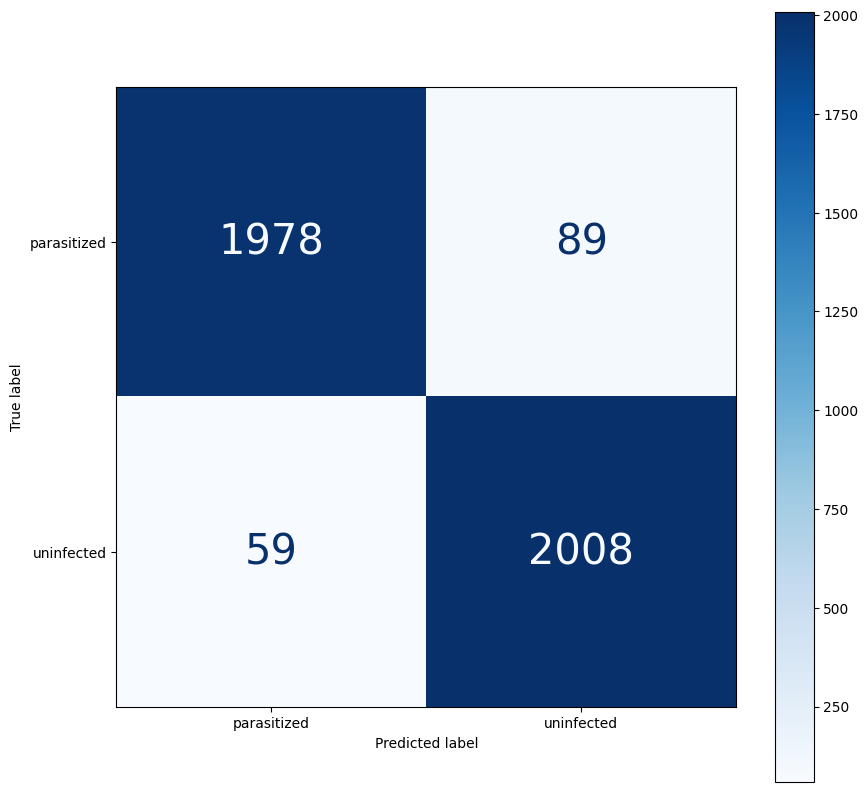

Sensitivity: 0.9714562167392357, Specificity: 0.9569424286405418


In [40]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [41]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


precision    recall  f1-score      support
parasitized    0.971036  0.956942  0.963938  2067.000000
uninfected     0.957558  0.971456  0.964457  2067.000000
accuracy       0.964199  0.964199  0.964199     0.964199
macro avg      0.964297  0.964199  0.964197  4134.000000
weighted avg   0.964297  0.964199  0.964197  4134.000000

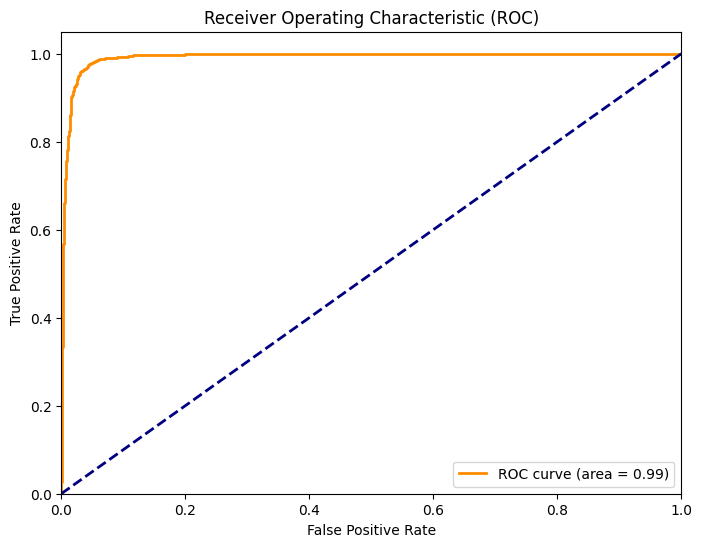

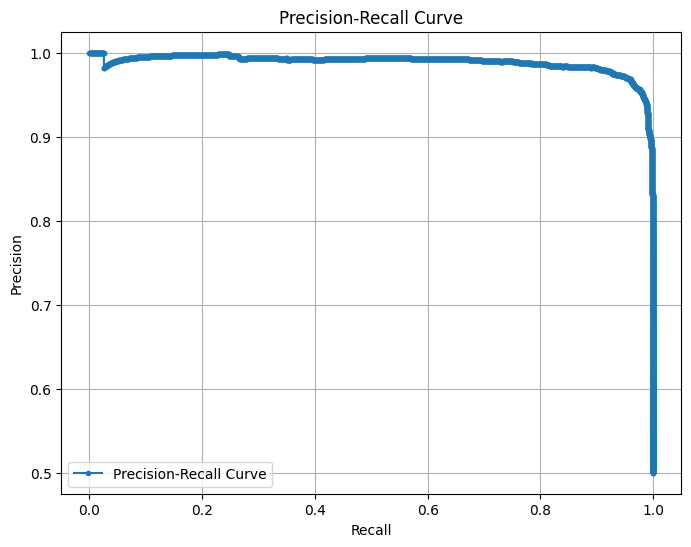

In [42]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
 

# Model 2 with Dropout（0.3）

In [43]:
def Classifier_CNN_2_SE2_drop(input_size=(64,64,3), l2_reg=0.00001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
    parallel_1 = SEBlock(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
    parallel_2 = SEBlock(parallel_2)
       
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    parallel_3 = SEBlock(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)
    
    d = Dropout(0.3)(fc_layer_1)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(d)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

In [45]:
model2_se2_drop_1 = Classifier_CNN_2_SE2_drop(input_size=(64,64,3), l2_reg=0.00001)
model2_se2_drop_1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 16)   448         ['input_8[0][0]']                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 64, 64, 16)   1216        ['input_8[0][0]']                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 64, 64, 16)   2368        ['input_8[0][0]']                
                                                                                            

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model2_se2_drop_1.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_2_drop_1 = model2_se2_drop_1.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))


Epoch 1/15
603/603 [==============================] - 109s 178ms/step - loss: 0.6926 - custom_accuracy: 0.6119 - val_loss: 0.6235 - val_custom_accuracy: 0.6457
Epoch 2/15
603/603 [==============================] - 38s 62ms/step - loss: 0.5983 - custom_accuracy: 0.6947 - val_loss: 0.5257 - val_custom_accuracy: 0.7425
Epoch 3/15
603/603 [==============================] - 37s 62ms/step - loss: 0.5355 - custom_accuracy: 0.7351 - val_loss: 0.4581 - val_custom_accuracy: 0.7734
Epoch 4/15
603/603 [==============================] - 38s 63ms/step - loss: 0.4812 - custom_accuracy: 0.7737 - val_loss: 0.4401 - val_custom_accuracy: 0.7903
Epoch 5/15
603/603 [==============================] - 39s 65ms/step - loss: 0.4345 - custom_accuracy: 0.8048 - val_loss: 0.4063 - val_custom_accuracy: 0.8097
Epoch 6/15
603/603 [==============================] - 39s 65ms/step - loss: 0.3907 - custom_accuracy: 0.8297 - val_loss: 0.3606 - val_custom_accuracy: 0.8392
Epoch 7/15
603/603 [==============================

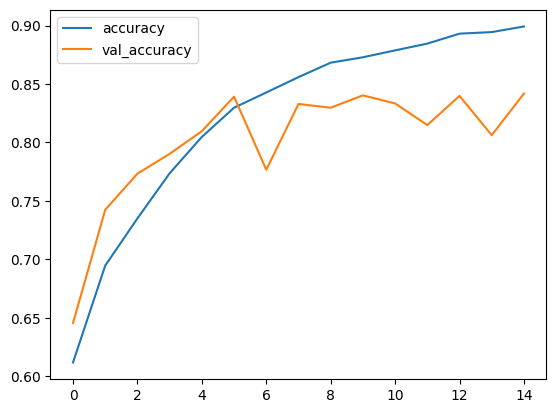

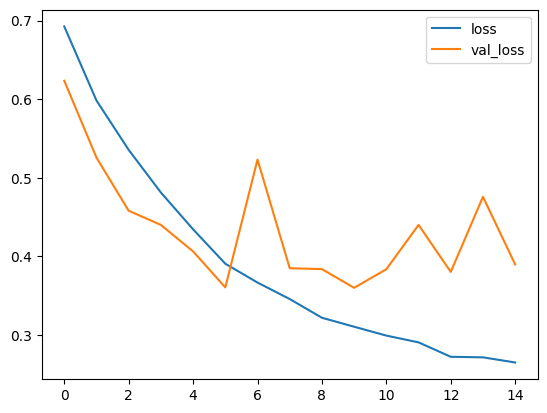

130/130 [==============================] - 15s 119ms/step - loss: 0.3550 - custom_accuracy: 0.8529
Test Accuracy: 0.8528845906257629
Test loss: 0.35504838824272156


In [47]:
plt.plot(history_2_drop_1.history['custom_accuracy'], label='accuracy')
plt.plot(history_2_drop_1.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_2_drop_1.history['loss'], label='loss')
plt.plot(history_2_drop_1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model2_se2_drop_1.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [48]:
predY = model2_se2_drop_1.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 29ms/step


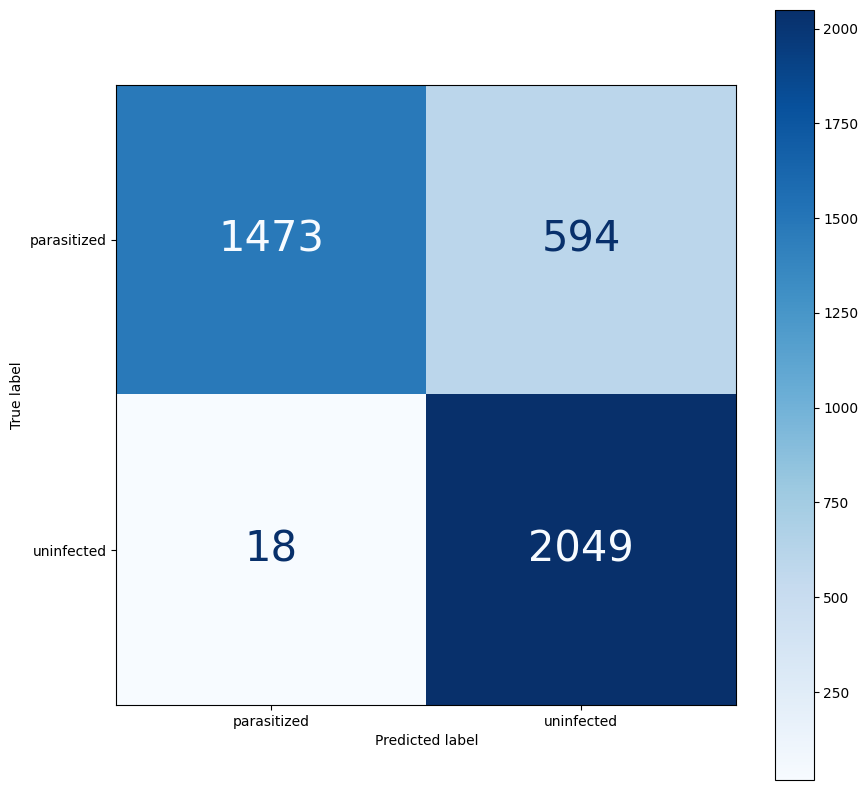

Sensitivity: 0.9912917271407837, Specificity: 0.7126269956458636


In [49]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [50]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


precision    recall  f1-score      support
parasitized    0.987928  0.712627  0.827993  2067.000000
uninfected     0.775255  0.991292  0.870064  2067.000000
accuracy       0.851959  0.851959  0.851959     0.851959
macro avg      0.881591  0.851959  0.849028  4134.000000
weighted avg   0.881591  0.851959  0.849028  4134.000000

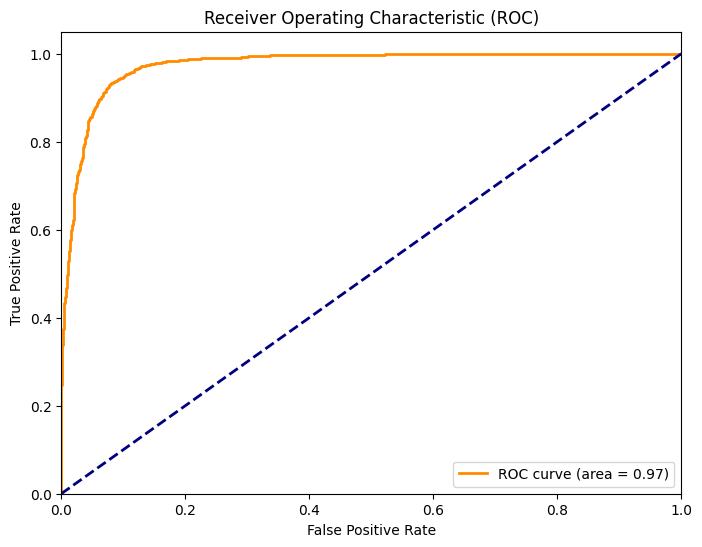

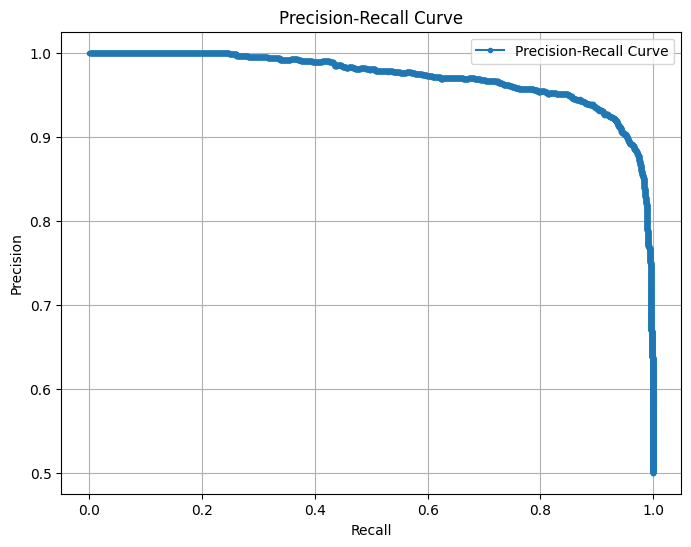

In [51]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Model 2 with dropout(0.5)

In [53]:
def Classifier_CNN_2_SE2_drop(input_size=(64,64,3), l2_reg=0.00001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
    parallel_1 = SEBlock(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
    parallel_2 = SEBlock(parallel_2)
       
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    parallel_3 = SEBlock(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)
    
    d = Dropout(0.5)(fc_layer_1)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(d)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

In [54]:
model2_se2_drop_2 = Classifier_CNN_2_SE2_drop(input_size=(64,64,3), l2_reg=0.00001)
model2_se2_drop_2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 64, 64, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 64, 64, 16)   1216        ['input_9[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 64, 64, 16)   2368        ['input_9[0][0]']                
                                                                                            

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model2_se2_drop_2.compile(optimizer=optimizer, 
               loss=custom_binary_crossentropy, 
               metrics=[custom_accuracy])


history_2_drop_2 = model2_se2_drop_2.fit(x = train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 15,
                              validation_data = validation_generator,
                              validation_steps = len(validation_generator))


Epoch 1/15
603/603 [==============================] - 39s 63ms/step - loss: 0.7381 - custom_accuracy: 0.6033 - val_loss: 0.5829 - val_custom_accuracy: 0.7071
Epoch 2/15
603/603 [==============================] - 37s 62ms/step - loss: 0.6578 - custom_accuracy: 0.6659 - val_loss: 0.5479 - val_custom_accuracy: 0.7244
Epoch 3/15
603/603 [==============================] - 37s 62ms/step - loss: 0.5996 - custom_accuracy: 0.7049 - val_loss: 0.6749 - val_custom_accuracy: 0.6655
Epoch 4/15
603/603 [==============================] - 37s 61ms/step - loss: 0.5551 - custom_accuracy: 0.7280 - val_loss: 0.9328 - val_custom_accuracy: 0.6068
Epoch 5/15
603/603 [==============================] - 37s 61ms/step - loss: 0.5104 - custom_accuracy: 0.7594 - val_loss: 1.2981 - val_custom_accuracy: 0.5813
Epoch 6/15
603/603 [==============================] - 37s 61ms/step - loss: 0.4608 - custom_accuracy: 0.7845 - val_loss: 1.5377 - val_custom_accuracy: 0.5716
Epoch 7/15
603/603 [==============================] 

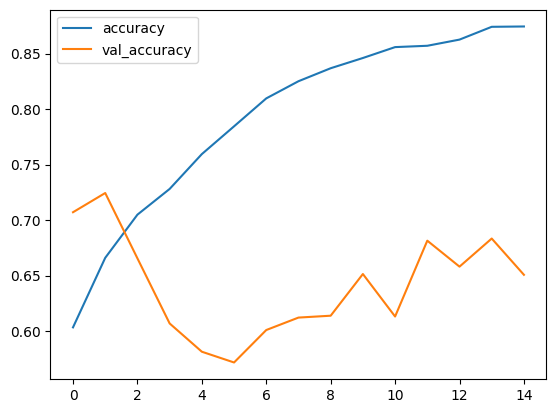

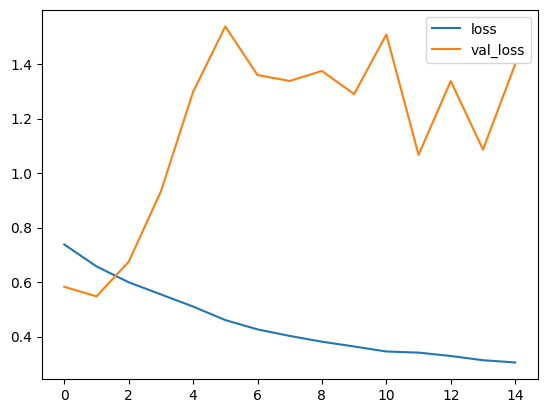

130/130 [==============================] - 4s 29ms/step - loss: 1.3706 - custom_accuracy: 0.6526
Test Accuracy: 0.6526442170143127
Test loss: 1.370639443397522


In [57]:
plt.plot(history_2_drop_2.history['custom_accuracy'], label='accuracy')
plt.plot(history_2_drop_2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_2_drop_2.history['loss'], label='loss')
plt.plot(history_2_drop_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model2_se2_drop_2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

In [58]:
predY = model2_se2_drop_2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

130/130 [==============================] - 4s 27ms/step


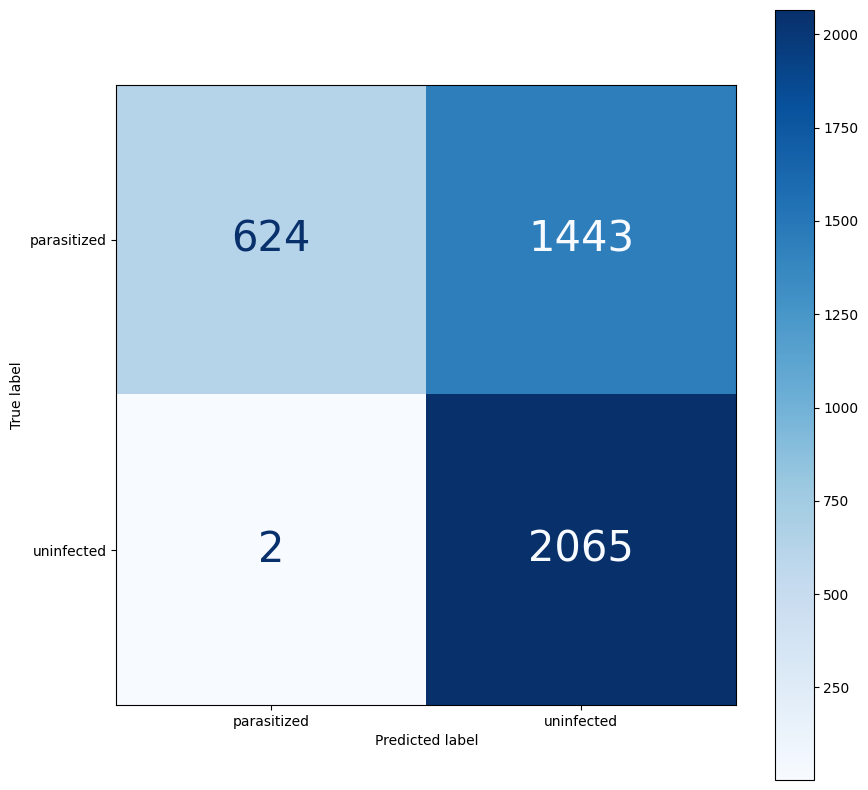

Sensitivity: 0.9990324141267537, Specificity: 0.3018867924528302


In [59]:
class_to_label_map = {'parasitized':0 , 'uninfected':1}
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [60]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score     support
parasitized    0.996805  0.301887  0.463424  2067.00000
uninfected     0.588655  0.999032  0.740807  2067.00000
accuracy       0.650460  0.650460  0.650460     0.65046
macro avg      0.792730  0.650460  0.602115  4134.00000
weighted avg   0.792730  0.650460  0.602115  4134.00000

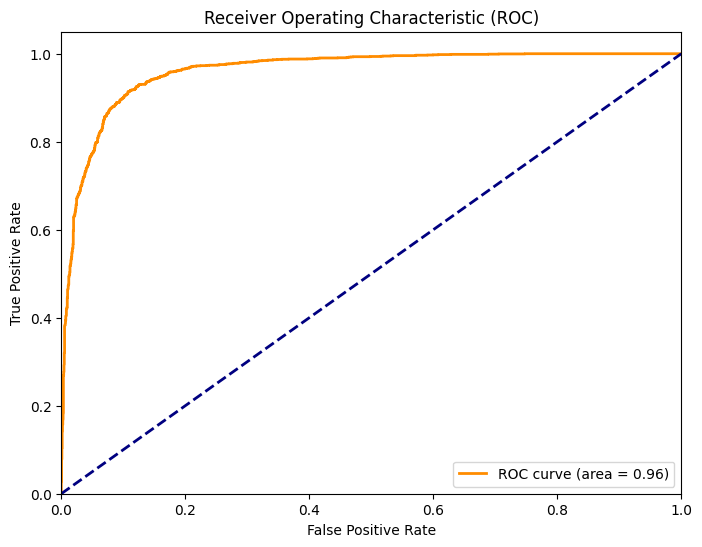

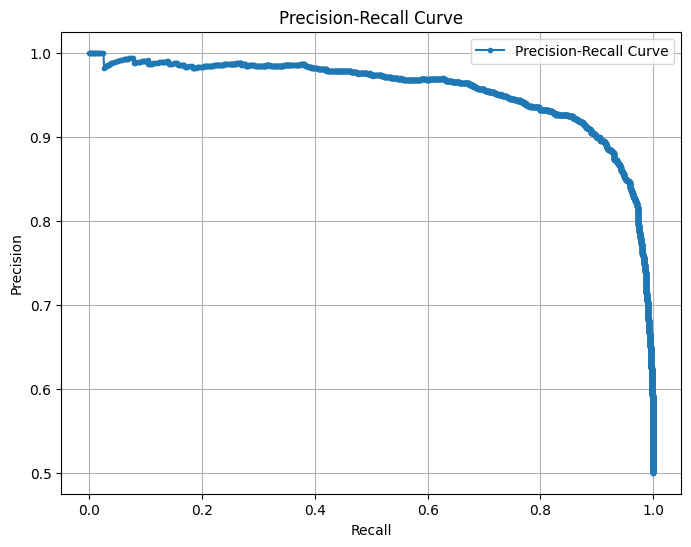

In [61]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# L2 = 0.0001 in model 1

In [64]:
def Classifier_CNN_1_SE2_L2(input_size=(64,64,3), l2_reg=0.0001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(bn3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    # SE block after all conv and pooling layers
    se_final = SEBlock(pool4) 
    
    # Fully connected layers
    gap = GlobalAveragePooling2D()(se_final)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

model1_se2_L2_1 = Classifier_CNN_1_SE2_L2(input_size=(64,64,3), l2_reg=0.0001)
model1_se2_L2_1.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 64, 64, 32)   896         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_39 (BatchN  (None, 64, 64, 32)  128         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 32, 32, 32)  0           ['batch_normalization_39[0]

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_se2_L2_1.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2_L2_1 = model1_se2_L2_1.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))


Epoch 1/15
603/603 [==============================] - 40s 65ms/step - loss: 0.3288 - custom_accuracy: 0.8745 - val_loss: 0.8102 - val_custom_accuracy: 0.6692
Epoch 2/15
603/603 [==============================] - 38s 64ms/step - loss: 0.1982 - custom_accuracy: 0.9374 - val_loss: 0.1732 - val_custom_accuracy: 0.9454
Epoch 3/15
603/603 [==============================] - 39s 64ms/step - loss: 0.1808 - custom_accuracy: 0.9445 - val_loss: 0.1591 - val_custom_accuracy: 0.9490
Epoch 4/15
603/603 [==============================] - 39s 65ms/step - loss: 0.1669 - custom_accuracy: 0.9480 - val_loss: 0.1679 - val_custom_accuracy: 0.9474
Epoch 5/15
603/603 [==============================] - 39s 64ms/step - loss: 0.1606 - custom_accuracy: 0.9496 - val_loss: 0.1635 - val_custom_accuracy: 0.9486
Epoch 6/15
603/603 [==============================] - 38s 63ms/step - loss: 0.1548 - custom_accuracy: 0.9515 - val_loss: 0.2010 - val_custom_accuracy: 0.9404
Epoch 7/15
603/603 [==============================] 

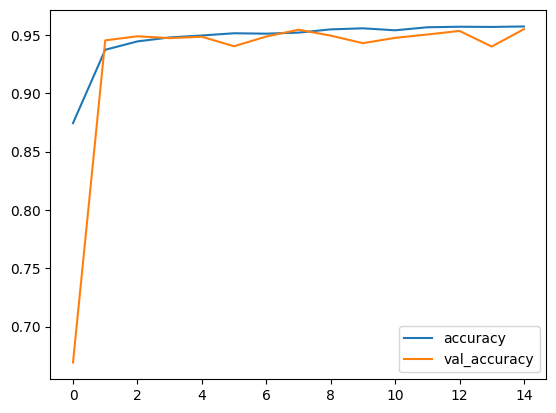

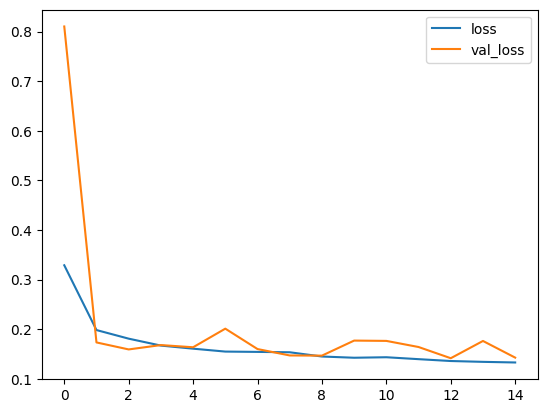

130/130 [==============================] - 17s 128ms/step - loss: 0.1256 - custom_accuracy: 0.9599
Test Accuracy: 0.9598557949066162
Test loss: 0.12563146650791168


In [66]:
plt.plot(history_se2_L2_1.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2_L2_1.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2_L2_1.history['loss'], label='loss')
plt.plot(history_se2_L2_1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model1_se2_L2_1.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )


130/130 [==============================] - 4s 28ms/step


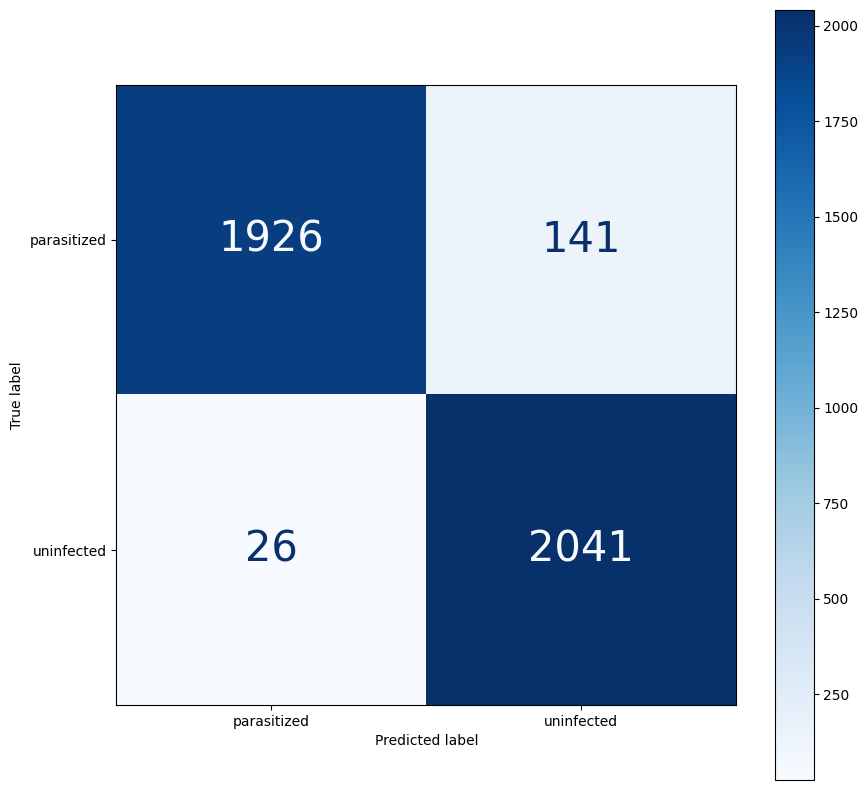

Sensitivity: 0.9874213836477987, Specificity: 0.9317851959361393


In [67]:
predY = model1_se2_L2_1.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [68]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


precision    recall  f1-score      support
parasitized    0.986680  0.931785  0.958447  2067.000000
uninfected     0.935380  0.987421  0.960697  2067.000000
accuracy       0.959603  0.959603  0.959603     0.959603
macro avg      0.961030  0.959603  0.959572  4134.000000
weighted avg   0.961030  0.959603  0.959572  4134.000000

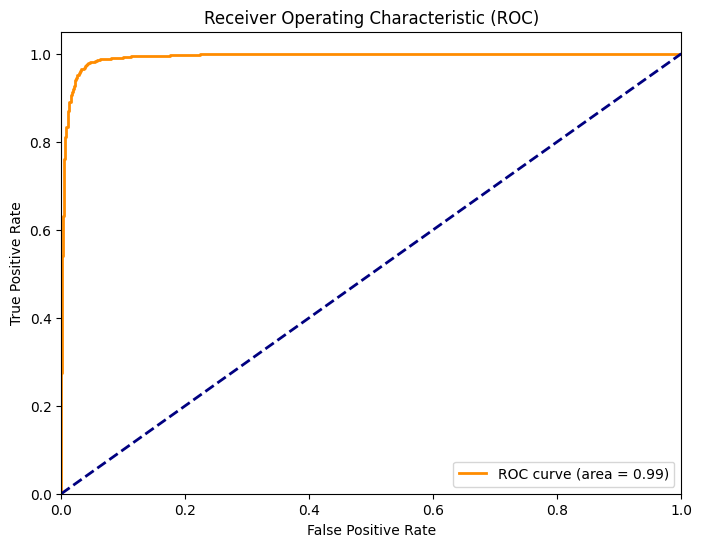

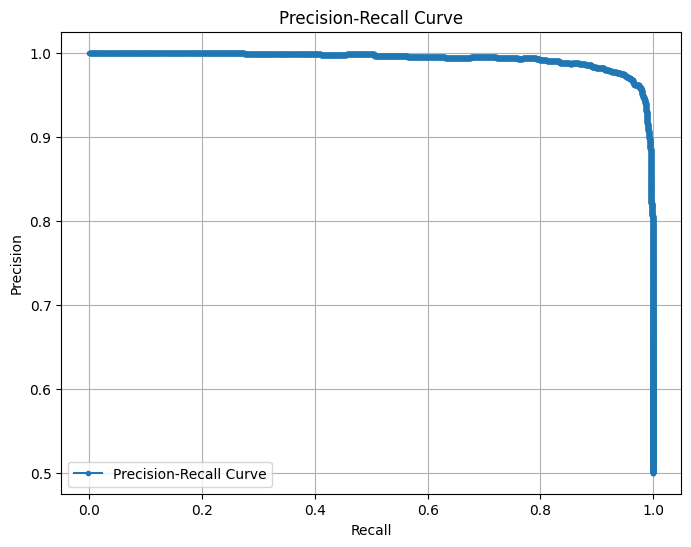

In [69]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# L2 = 0.001 in model 1

In [70]:
def Classifier_CNN_1_SE2_L2(input_size=(64,64,3), l2_reg=0.001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(bn3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    # SE block after all conv and pooling layers
    se_final = SEBlock(pool4) 
    
    # Fully connected layers
    gap = GlobalAveragePooling2D()(se_final)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

model1_se2_l2_2 = Classifier_CNN_1_SE2_L2(input_size=(64,64,3), l2_reg=0.001)
model1_se2_l2_2.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_40 (Conv2D)             (None, 64, 64, 32)   896         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_43 (BatchN  (None, 64, 64, 32)  128         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_33 (MaxPooling2D  (None, 32, 32, 32)  0           ['batch_normalization_43[0

In [72]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_se2_l2_2.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_se2_l2_2 = model1_se2_l2_2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))


Epoch 1/15
 69/603 [==>...........................] - ETA: 31s - loss: 0.1343 - custom_accuracy: 0.9574

KeyboardInterrupt: 

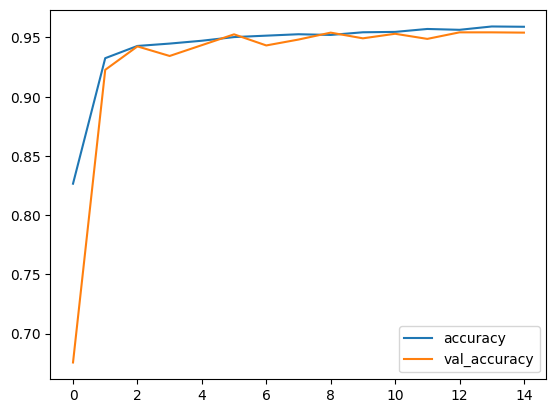

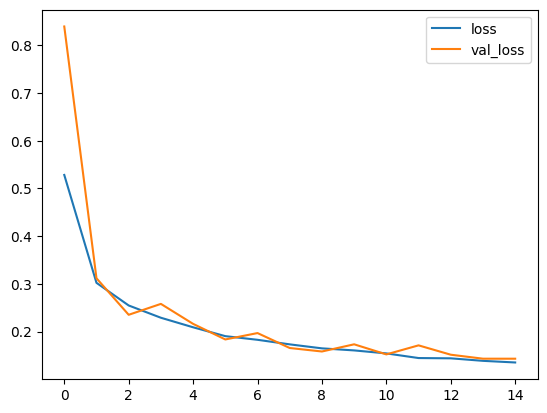

130/130 [==============================] - 4s 29ms/step - loss: 0.1245 - custom_accuracy: 0.9620
Test Accuracy: 0.9620192050933838
Test loss: 0.12449389696121216


In [73]:
plt.plot(history_se2_l2_2.history['custom_accuracy'], label='accuracy')
plt.plot(history_se2_l2_2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_se2_l2_2.history['loss'], label='loss')
plt.plot(history_se2_l2_2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model1_se2_l2_2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )


130/130 [==============================] - 4s 27ms/step


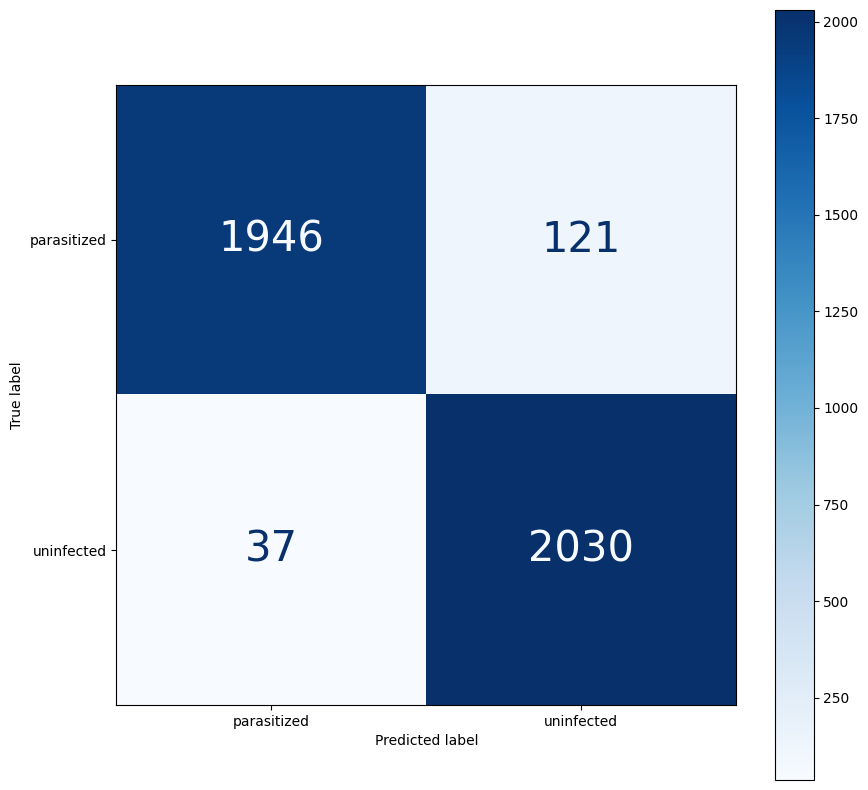

Sensitivity: 0.9820996613449444, Specificity: 0.9414610546686019


In [74]:
predY = model1_se2_l2_2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [75]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df


precision    recall  f1-score     support
parasitized    0.981341  0.941461  0.960988  2067.00000
uninfected     0.943747  0.982100  0.962541  2067.00000
accuracy       0.961780  0.961780  0.961780     0.96178
macro avg      0.962544  0.961780  0.961765  4134.00000
weighted avg   0.962544  0.961780  0.961765  4134.00000

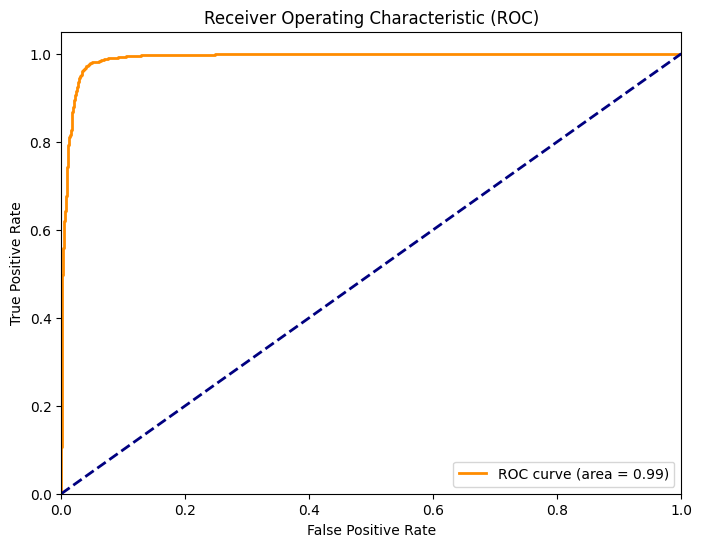

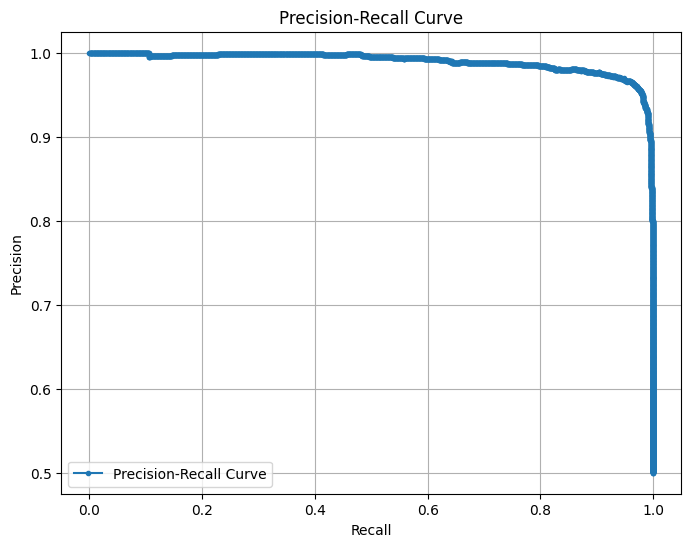

In [76]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# L2 Fator = 0.0001 in model 2

In [77]:
def Classifier_CNN_2_SE2_Lr(input_size=(64,64,3), l2_reg=0.0001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
    parallel_1 = SEBlock(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
    parallel_2 = SEBlock(parallel_2)
       
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    parallel_3 = SEBlock(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(fc_layer_1)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

model2_se2_lr1 = Classifier_CNN_2_SE2_Lr(input_size=(64,64,3), l2_reg=0.0001)
model2_se2_lr1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_44 (Conv2D)             (None, 64, 64, 16)   448         ['input_13[0][0]']               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 64, 64, 16)   1216        ['input_13[0][0]']               
                                                                                                  
 conv2d_46 (Conv2D)             (None, 64, 64, 16)   2368        ['input_13[0][0]']               
                                                                                           

In [78]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2_se2_lr1.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se2_lr1 = model2_se2_lr1.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 71s 113ms/step - loss: 0.4526 - custom_accuracy: 0.8007 - val_loss: 2.3330 - val_custom_accuracy: 0.5141
Epoch 2/15
603/603 [==============================] - 67s 111ms/step - loss: 0.2851 - custom_accuracy: 0.8969 - val_loss: 1.0009 - val_custom_accuracy: 0.6831
Epoch 3/15
603/603 [==============================] - 65s 108ms/step - loss: 0.2450 - custom_accuracy: 0.9147 - val_loss: 0.4316 - val_custom_accuracy: 0.8460
Epoch 4/15
603/603 [==============================] - 64s 106ms/step - loss: 0.2245 - custom_accuracy: 0.9253 - val_loss: 0.2565 - val_custom_accuracy: 0.9011
Epoch 5/15
603/603 [==============================] - 72s 120ms/step - loss: 0.2119 - custom_accuracy: 0.9308 - val_loss: 0.2092 - val_custom_accuracy: 0.9267
Epoch 6/15
603/603 [==============================] - 69s 115ms/step - loss: 0.2002 - custom_accuracy: 0.9352 - val_loss: 0.3005 - val_custom_accuracy: 0.8918
Epoch 7/15
603/603 [==========================

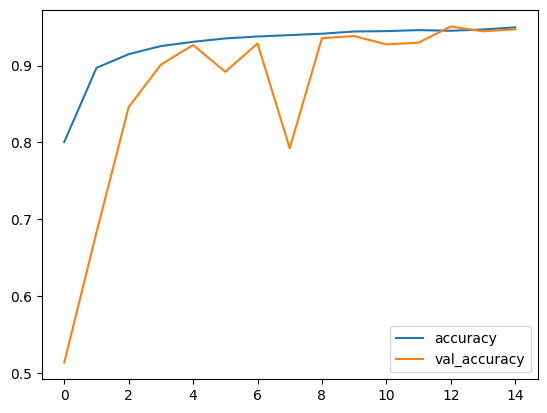

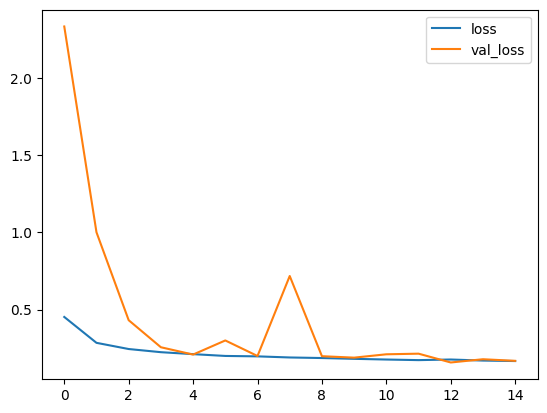

130/130 [==============================] - 7s 51ms/step - loss: 0.1438 - custom_accuracy: 0.9550
Test Accuracy: 0.9550480842590332
Test loss: 0.14378759264945984


In [79]:
plt.plot(history2_se2_lr1.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se2_lr1.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se2_lr1.history['loss'], label='loss')
plt.plot(history2_se2_lr1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


test_loss, test_accuracy = model2_se2_lr1.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 


130/130 [==============================] - 7s 49ms/step


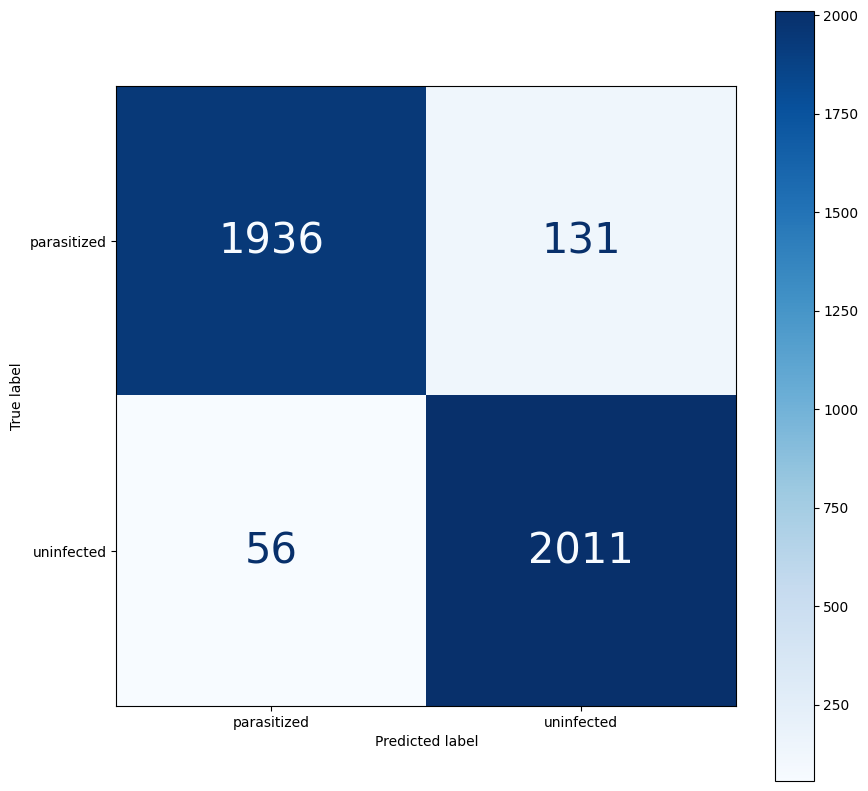

Sensitivity: 0.972907595549105, Specificity: 0.9366231253023706


In [80]:
predY = model2_se2_lr1.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [81]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df 


precision    recall  f1-score      support
parasitized    0.971888  0.936623  0.953930  2067.000000
uninfected     0.938842  0.972908  0.955571  2067.000000
accuracy       0.954765  0.954765  0.954765     0.954765
macro avg      0.955365  0.954765  0.954750  4134.000000
weighted avg   0.955365  0.954765  0.954750  4134.000000

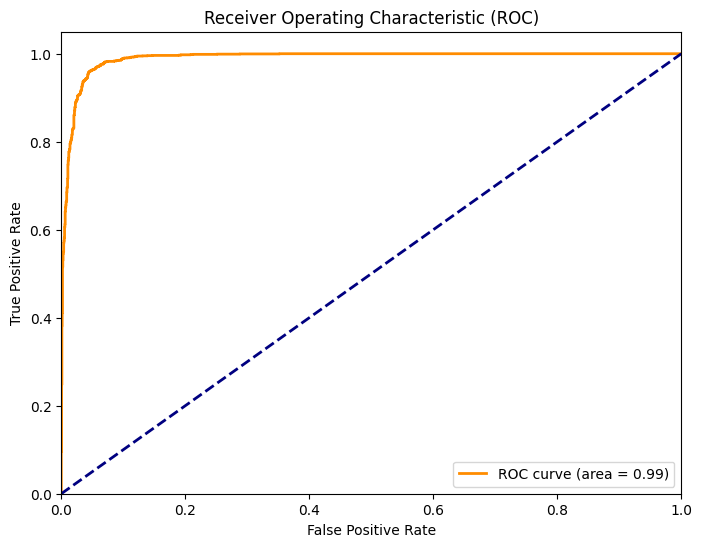

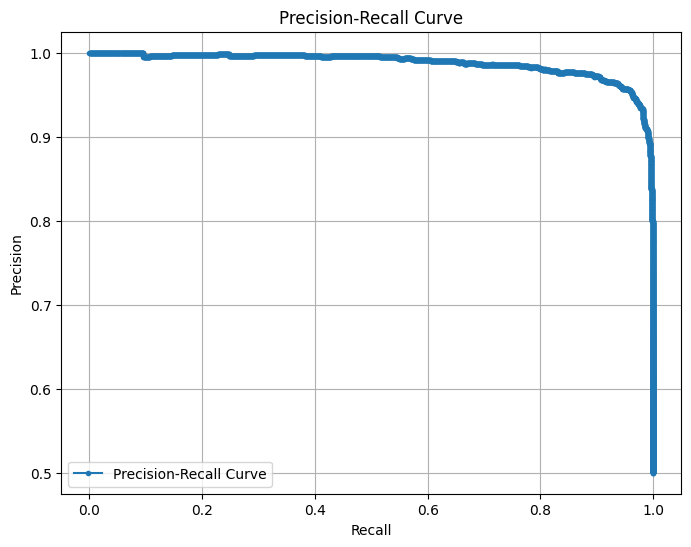

In [82]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# L2 Fator = 0.001 in model 2

In [83]:
def Classifier_CNN_2_SE2_Lr(input_size=(64,64,3), l2_reg=0.001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
    parallel_1 = SEBlock(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)
    parallel_2 = SEBlock(parallel_2)
       
    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    parallel_3 = SEBlock(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(fc_layer_1)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

model2_se2_lr2 = Classifier_CNN_2_SE2_Lr(input_size=(64,64,3), l2_reg=0.001)
model2_se2_lr2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 64, 64, 16)   448         ['input_14[0][0]']               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 64, 64, 16)   1216        ['input_14[0][0]']               
                                                                                                  
 conv2d_50 (Conv2D)             (None, 64, 64, 16)   2368        ['input_14[0][0]']               
                                                                                           

In [84]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2_se2_lr2.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_se2_lr2 = model2_se2_lr2.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Epoch 1/15
603/603 [==============================] - 72s 114ms/step - loss: 0.6001 - custom_accuracy: 0.8339 - val_loss: 2.0659 - val_custom_accuracy: 0.5185
Epoch 2/15
603/603 [==============================] - 66s 110ms/step - loss: 0.4454 - custom_accuracy: 0.9047 - val_loss: 0.4513 - val_custom_accuracy: 0.8966
Epoch 3/15
603/603 [==============================] - 71s 118ms/step - loss: 0.3946 - custom_accuracy: 0.9218 - val_loss: 0.3648 - val_custom_accuracy: 0.9256
Epoch 4/15
603/603 [==============================] - 68s 113ms/step - loss: 0.3716 - custom_accuracy: 0.9292 - val_loss: 0.5296 - val_custom_accuracy: 0.8755
Epoch 5/15
603/603 [==============================] - 67s 111ms/step - loss: 0.3443 - custom_accuracy: 0.9362 - val_loss: 0.3325 - val_custom_accuracy: 0.9332
Epoch 6/15
603/603 [==============================] - 66s 109ms/step - loss: 0.3287 - custom_accuracy: 0.9395 - val_loss: 0.3112 - val_custom_accuracy: 0.9492
Epoch 7/15
603/603 [==========================

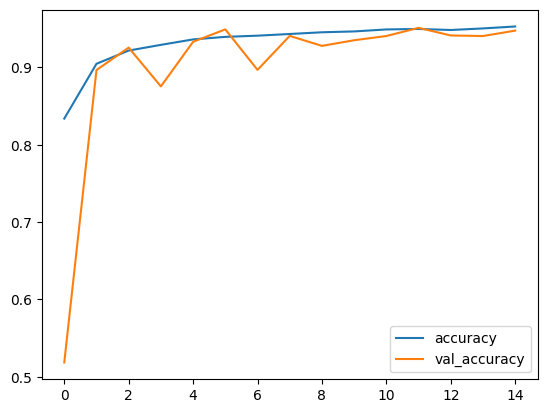

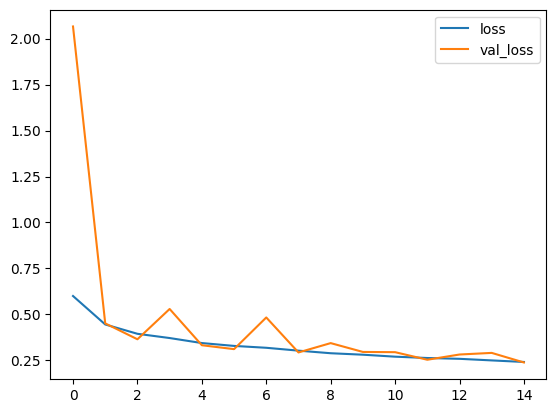

130/130 [==============================] - 6s 49ms/step - loss: 0.2178 - custom_accuracy: 0.9560
Test Accuracy: 0.9560096263885498
Test loss: 0.21780802309513092


In [85]:
plt.plot(history2_se2_lr2.history['custom_accuracy'], label='accuracy')
plt.plot(history2_se2_lr2.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_se2_lr2.history['loss'], label='loss')
plt.plot(history2_se2_lr2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


test_loss, test_accuracy = model2_se2_lr2.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 


130/130 [==============================] - 7s 46ms/step


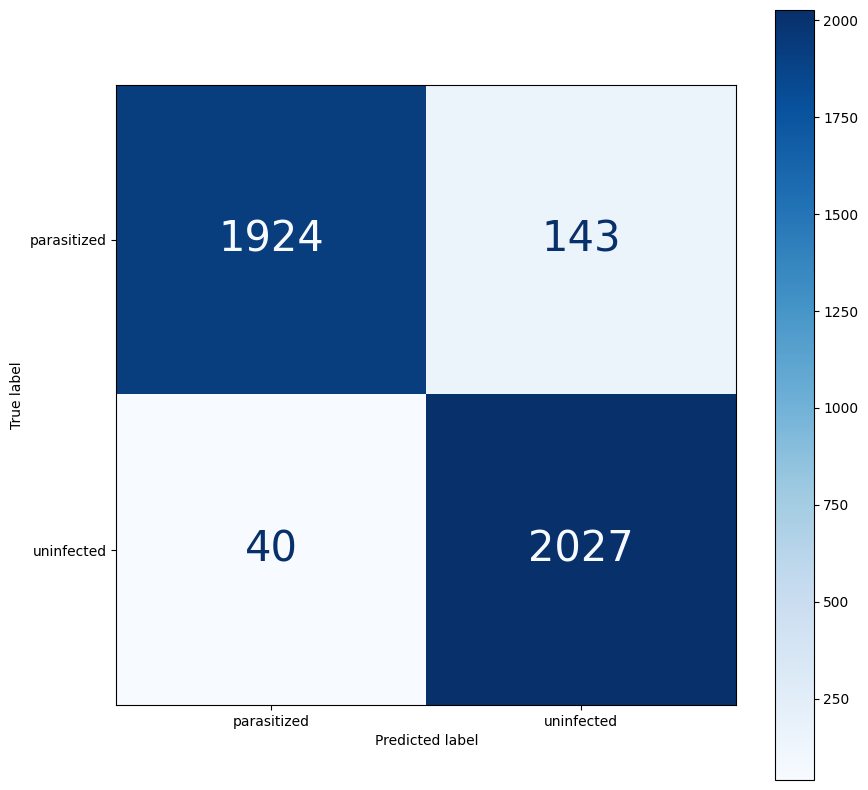

Sensitivity: 0.980648282535075, Specificity: 0.9308176100628931


In [86]:
predY = model2_se2_lr2.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()

class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')


In [87]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df 


precision    recall  f1-score      support
parasitized    0.979633  0.930818  0.954602  2067.000000
uninfected     0.934101  0.980648  0.956809  2067.000000
accuracy       0.955733  0.955733  0.955733     0.955733
macro avg      0.956867  0.955733  0.955705  4134.000000
weighted avg   0.956867  0.955733  0.955705  4134.000000

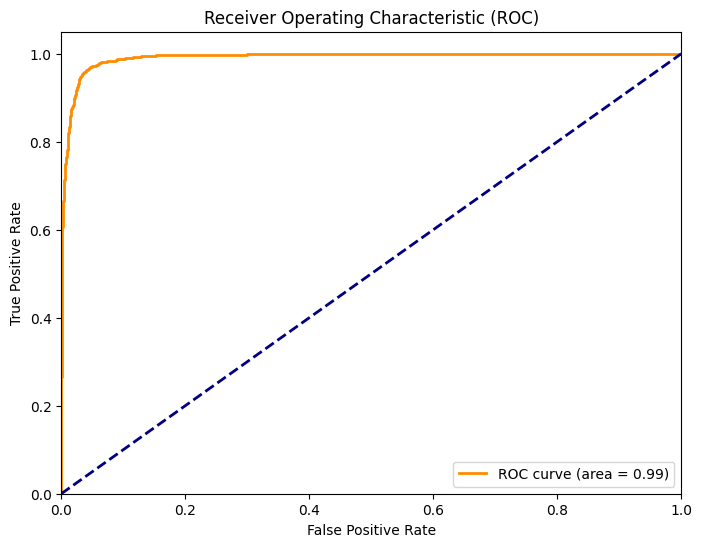

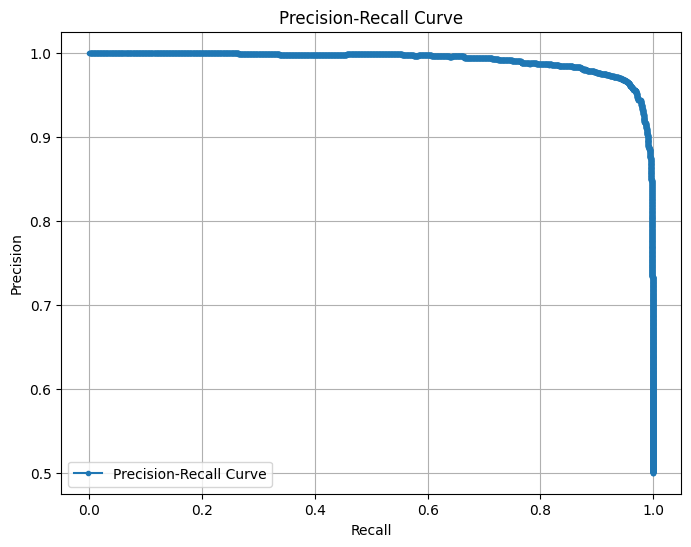

In [88]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Grad-CAM in model 1

# Train model1 1 without SE

In [16]:
def Classifier_CNN_1(input_size=(64,64,3), l2_reg=0.00001):
    inputs = Input(input_size)
    
    # First block
    conv1 = Conv2D(32, (3,3), padding="same", activation='relu')(inputs)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(bn1)
    
    # Second block 
    conv2 = Conv2D(64, (3,3), padding="same", activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(bn2)
    
    # Third block
    conv3 = Conv2D(128, (3,3), padding="same", activation='relu')(pool2)
    bn3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2,2))(bn3)
    
    # Fourth block
    conv4 = Conv2D(128, (3,3), padding="same", activation='relu')(bn3)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(bn4)
    
    # Fully connected layers
    gap = GlobalAveragePooling2D()(pool4)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense1)

    return Model(inputs=[inputs], outputs=[output])

In [17]:
model1_base = Classifier_CNN_1(input_size=(64,64,3), l2_reg=0.00001)
model1_base.summary() 

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1_base.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history_base = model1_base.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 64)       256 

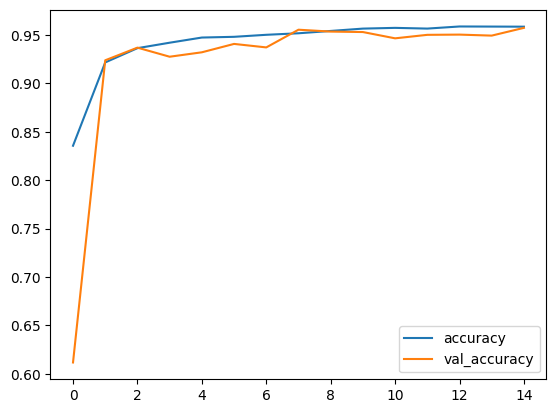

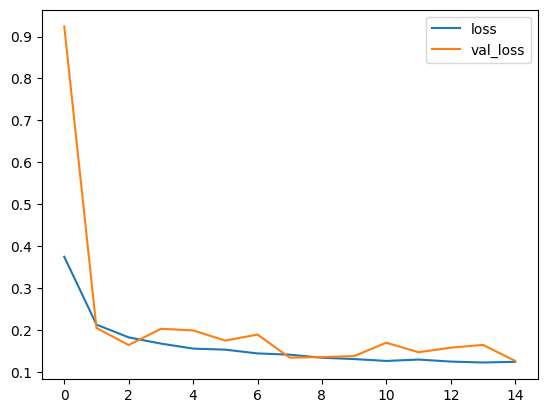

130/130 [==============================] - 17s 130ms/step - loss: 0.1102 - custom_accuracy: 0.9627
Test Accuracy: 0.9627403616905212
Test loss: 0.11018724739551544


In [18]:
plt.plot(history_base.history['custom_accuracy'], label='accuracy')
plt.plot(history_base.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history_base.history['loss'], label='loss')
plt.plot(history_base.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


model1_base.save('model1_base.h5')

test_loss, test_accuracy = model1_base.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )


130/130 [==============================] - 3s 23ms/step


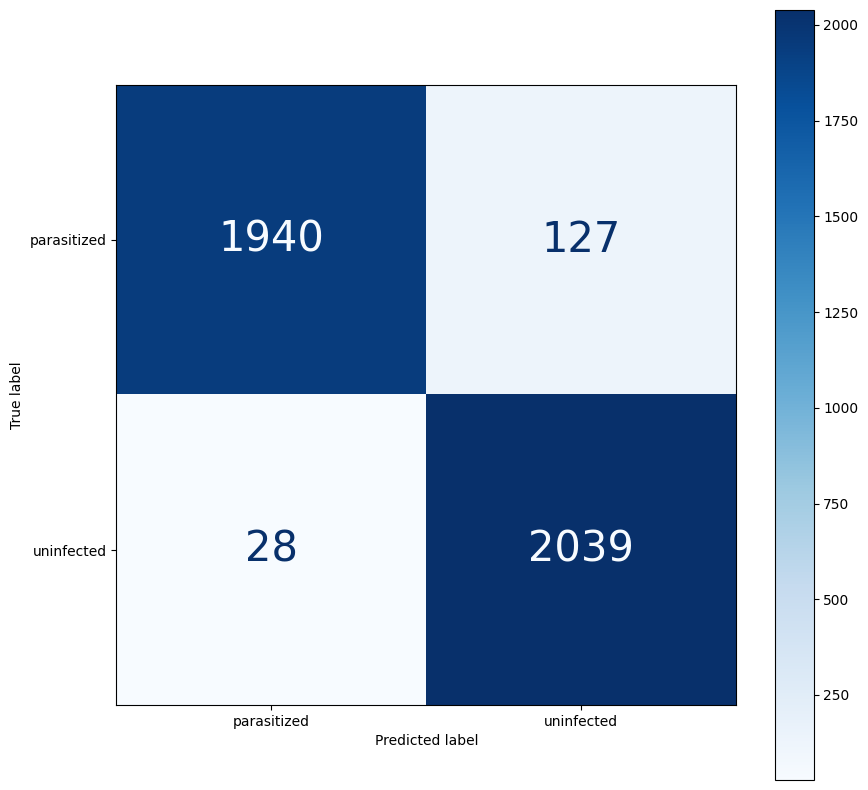

Sensitivity: 0.9864537977745524, Specificity: 0.9385582970488631


In [19]:
predY = model1_base.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [20]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df

precision    recall  f1-score      support
parasitized    0.985772  0.938558  0.961586  2067.000000
uninfected     0.941367  0.986454  0.963383  2067.000000
accuracy       0.962506  0.962506  0.962506     0.962506
macro avg      0.963569  0.962506  0.962485  4134.000000
weighted avg   0.963569  0.962506  0.962485  4134.000000

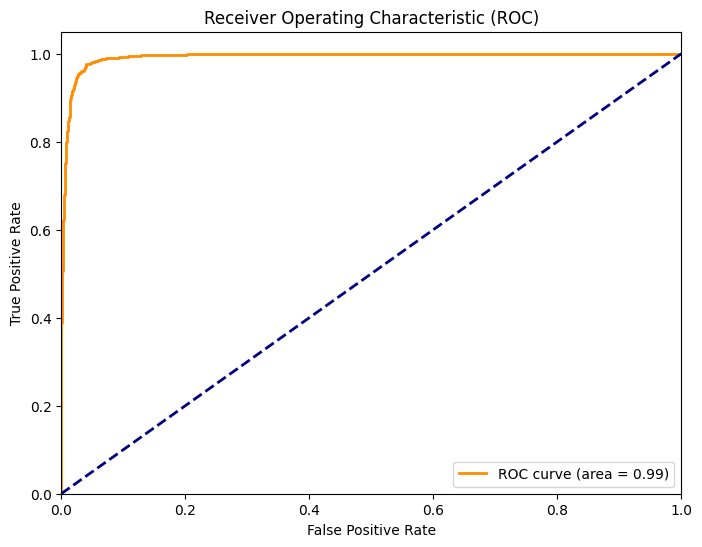

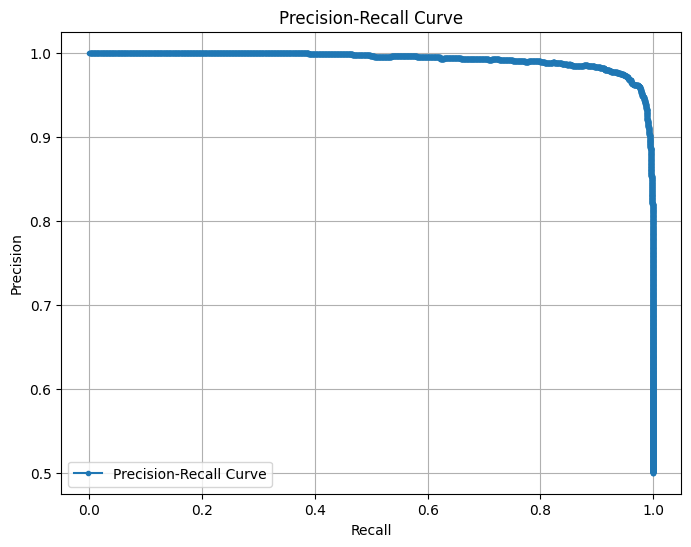

In [21]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 15ms/step


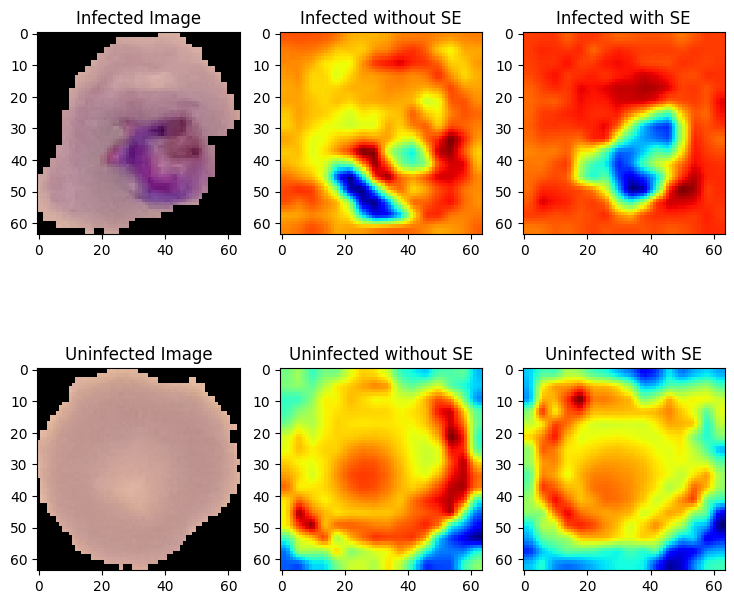

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

def load_image(img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  
    return x

def grad_cam(model, img_array, layer_name, class_idx, target_size=(64, 64)):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.ones(output.shape[0: 2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, target_size)
    return cam

model_1_without_se = load_model('model1_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})
model_1_with_se = load_model('model1_base.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

img_path_parasitized = r'E:\MV-Code\Datasets\archive\Base_datasets\test\parasitized\C39P4thinF_original_IMG_20150622_105102_cell_83.png'
img_path_uninfected = r'E:\MV-Code\Datasets\archive\Base_datasets\test\uninfected\C1_thinF_IMG_20150604_104942_cell_168.png'

img_array_infected = load_image(img_path_parasitized)
img_array_uninfected = load_image(img_path_uninfected)

preds_infected = model_1_without_se.predict(img_array_infected)
class_idx_infected = np.argmax(preds_infected[0])

preds_uninfected = model_1_without_se.predict(img_array_uninfected)
class_idx_uninfected = np.argmax(preds_uninfected[0])

cam_infected_without_se = grad_cam(model_1_without_se, img_array_infected, 'conv2d_7', class_idx_infected)
cam_infected_with_se = grad_cam(model_1_with_se, img_array_infected, 'conv2d_7', class_idx_infected)

cam_uninfected_without_se = grad_cam(model_1_without_se, img_array_uninfected, 'conv2d_7', class_idx_uninfected)
cam_uninfected_with_se = grad_cam(model_1_with_se, img_array_uninfected, 'conv2d_7', class_idx_uninfected)

plt.figure(figsize=(12, 8))


# Infected Images
plt.subplot(2, 4, 1)
plt.imshow(tf.squeeze(img_array_infected))
plt.title("Infected Image")

plt.subplot(2, 4, 2)
plt.imshow(cam_infected_without_se, cmap='jet')
plt.title("Infected without SE")

plt.subplot(2, 4, 3)
plt.imshow(cam_infected_with_se, cmap='jet')
plt.title("Infected with SE")

# Uninfected Images
plt.subplot(2, 4, 5)
plt.imshow(tf.squeeze(img_array_uninfected))
plt.title("Uninfected Image")

plt.subplot(2, 4, 6)
plt.imshow(cam_uninfected_without_se, cmap='jet')
plt.title("Uninfected without SE")

plt.subplot(2, 4, 7)
plt.imshow(cam_uninfected_with_se, cmap='jet')
plt.title("Uninfected with SE")

plt.show()


# Grad-CAM in mode2

# Train model1 2 without SE

In [28]:
def Classifier_CNN_2(input_size=(64,64,3), l2_reg=0.00001):
    input_layer = Input(input_size)
    
    # Define the first parallel connection
    parallel_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_layer)
    parallel_1 = BatchNormalization()(parallel_1)
    parallel_1 = MaxPooling2D(pool_size=(2, 2))(parallel_1)
      
    # Define the second parallel connection
    parallel_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(input_layer)
    parallel_2 = BatchNormalization()(parallel_2)
    parallel_2 = MaxPooling2D(pool_size=(2, 2))(parallel_2)

    # Define the third parallel connection
    parallel_3 = Conv2D(16, (7, 7), padding='same', activation='relu')(input_layer)
    parallel_3 = BatchNormalization()(parallel_3)
    parallel_3 = MaxPooling2D(pool_size=(2, 2))(parallel_3)
    
    # Concatenate the outputs of the parallel connections
    concatenated = concatenate([parallel_1, parallel_2, parallel_3])
    
    conv = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg))(concatenated)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D(pool_size=(4, 4), strides=(4,4))(conv)
    
    # Define the flatten layer
#     flatten_layer = Flatten()(conv)

    # use globalverage pool instead of flatten
    gap = GlobalAveragePooling2D()(conv)
    
    # Define the first fully connected layer
    fc_layer_1 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(gap)
    fc_layer_1 = BatchNormalization()(fc_layer_1)
    
#     # Define the second fully connected layer
#     fc_layer_2 = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(fc_layer_1)
#     fc_layer_2 = BatchNormalization()(fc_layer_2)

    # Define the output layer
    output_layer = Dense(1, activation='sigmoid')(fc_layer_1)
    
    return Model(inputs=[input_layer], outputs=[output_layer])

model2_base = Classifier_CNN_2(input_size=(64,64,3), l2_reg=0.00001)
model2_base.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 16)   448         ['input_3[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 64, 64, 16)   1216        ['input_3[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 16)   2368        ['input_3[0][0]']                
                                                                                            

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2_base.compile(optimizer=optimizer, 
                loss=custom_binary_crossentropy, 
                metrics=[custom_accuracy])

history2_base = model2_base.fit(x = train_generator,
                      steps_per_epoch = len(train_generator),
                      epochs = 15,
                      validation_data = validation_generator,
                      validation_steps = len(validation_generator))


Epoch 1/15
603/603 [==============================] - 137s 225ms/step - loss: 0.4083 - custom_accuracy: 0.8213 - val_loss: 1.6271 - val_custom_accuracy: 0.5344
Epoch 2/15
603/603 [==============================] - 24s 39ms/step - loss: 0.2541 - custom_accuracy: 0.9039 - val_loss: 0.4468 - val_custom_accuracy: 0.8284
Epoch 3/15
603/603 [==============================] - 24s 39ms/step - loss: 0.2210 - custom_accuracy: 0.9191 - val_loss: 0.2645 - val_custom_accuracy: 0.8910
Epoch 4/15
603/603 [==============================] - 23s 39ms/step - loss: 0.1989 - custom_accuracy: 0.9282 - val_loss: 0.1816 - val_custom_accuracy: 0.9305
Epoch 5/15
603/603 [==============================] - 24s 39ms/step - loss: 0.1896 - custom_accuracy: 0.9336 - val_loss: 0.1860 - val_custom_accuracy: 0.9332
Epoch 6/15
603/603 [==============================] - 24s 39ms/step - loss: 0.1807 - custom_accuracy: 0.9377 - val_loss: 0.2396 - val_custom_accuracy: 0.9111
Epoch 7/15
603/603 [==============================

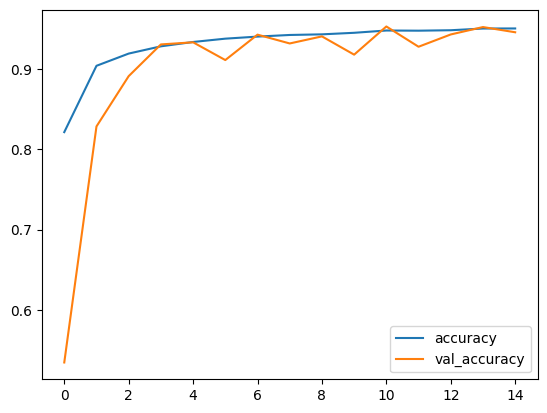

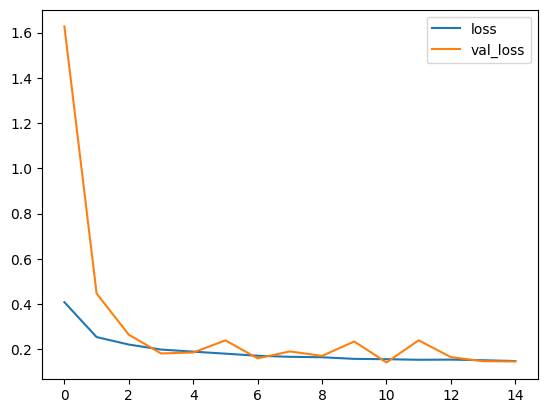

130/130 [==============================] - 22s 171ms/step - loss: 0.1248 - custom_accuracy: 0.9531
Test Accuracy: 0.953125
Test loss: 0.12481217086315155


In [30]:
plt.plot(history2_base.history['custom_accuracy'], label='accuracy')
plt.plot(history2_base.history['val_custom_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history2_base.history['loss'], label='loss')
plt.plot(history2_base.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


model2_base.save('model2_base.h5')

test_loss, test_accuracy = model2_base.evaluate(test_generator, steps=len(test_generator))
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss ) 

130/130 [==============================] - 3s 21ms/step


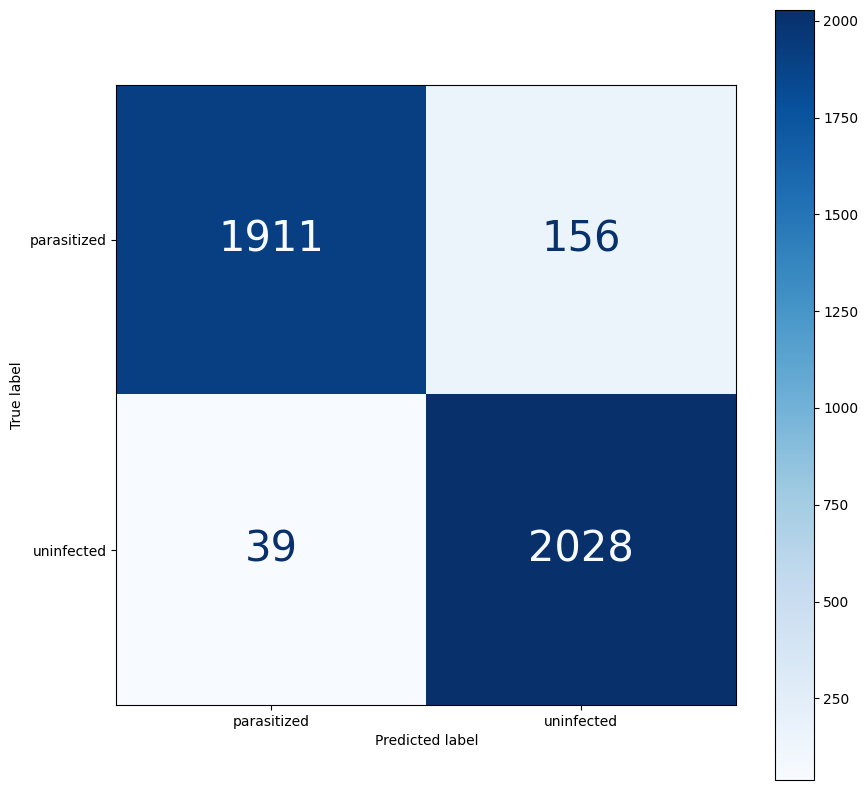

Sensitivity: 0.9811320754716981, Specificity: 0.9245283018867925


In [31]:
predY = model2_base.predict(test_generator, steps=len(test_generator), verbose=1)
testY = test_generator.classes
predY_classes = (predY > 0.5).astype(int).flatten()


class_to_label_map = {'parasitized':0 , 'uninfected':1}

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(testY, predY_classes)

cr=(classification_report(testY, predY_classes, target_names=class_to_label_map, output_dict=True, digits=4))

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

In [32]:
import pandas as pd

target_names = [key for key, value in sorted(class_to_label_map.items(), key=lambda item: item[1])]

# Generate the classification report
cr = classification_report(testY, predY_classes, target_names=target_names, output_dict=True, digits=4)

# Convert the classification report to a DataFrame
cr_df = pd.DataFrame(cr).transpose()
cr_df 


precision    recall  f1-score     support
parasitized    0.980000  0.924528  0.951456  2067.00000
uninfected     0.928571  0.981132  0.954128  2067.00000
accuracy       0.952830  0.952830  0.952830     0.95283
macro avg      0.954286  0.952830  0.952792  4134.00000
weighted avg   0.954286  0.952830  0.952792  4134.00000

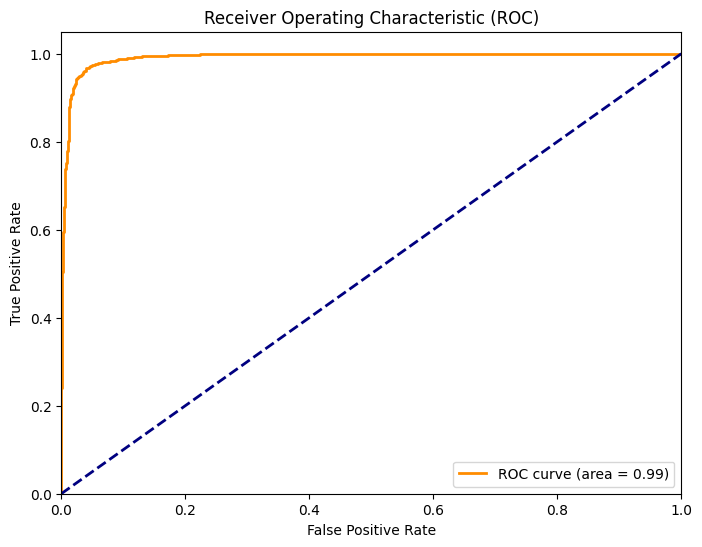

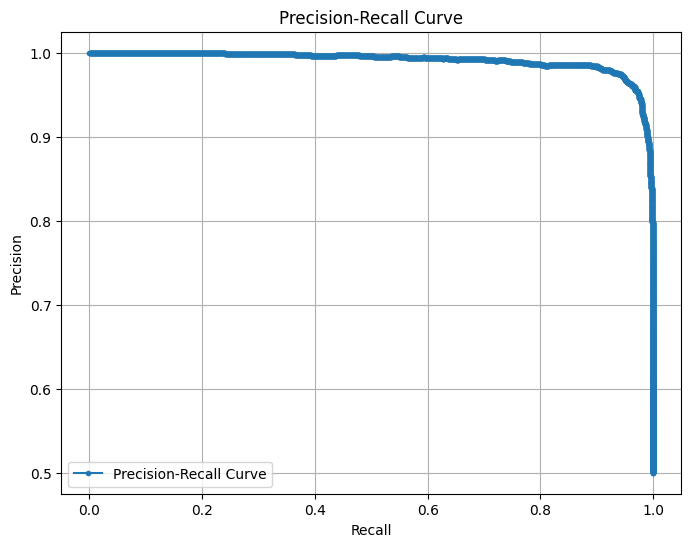

In [33]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points and the AUC score
fpr, tpr, thresholds = roc_curve(testY, predY)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(testY, predY)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 64, 64, 16)   448         ['input_9[0][0]']                
                                                                                                  
 conv2d_33 (Conv2D)             (None, 64, 64, 16)   1216        ['input_9[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 64, 64, 16)   2368        ['input_9[0][0]']                
                                                                                            

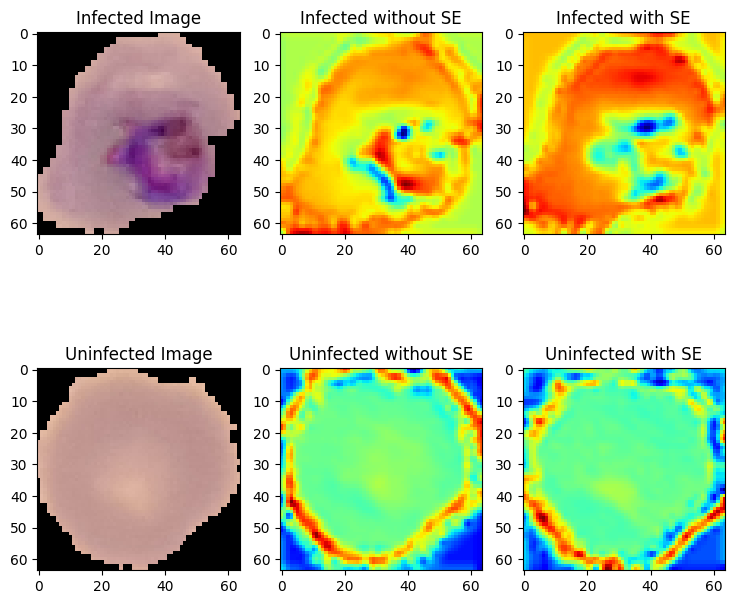

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

def load_image(img_path, target_size=(64, 64)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  
    return x

def grad_cam(model, img_array, layer_name, class_idx, target_size=(64, 64)):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.ones(output.shape[0: 2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, target_size)
    return cam

model_1_without_se = load_model('model2_se2.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})
model_1_with_se = load_model('model2_base.h5', custom_objects={
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
})

model_1_without_se.summary()
model_1_with_se.summary()

img_path_parasitized = r'E:\MV-Code\Datasets\archive\Base_datasets\test\parasitized\C39P4thinF_original_IMG_20150622_105102_cell_83.png'
img_path_uninfected = r'E:\MV-Code\Datasets\archive\Base_datasets\test\uninfected\C1_thinF_IMG_20150604_104942_cell_168.png'

img_array_infected = load_image(img_path_parasitized)
img_array_uninfected = load_image(img_path_uninfected)

preds_infected = model_1_without_se.predict(img_array_infected)
class_idx_infected = np.argmax(preds_infected[0])

preds_uninfected = model_1_without_se.predict(img_array_uninfected)
class_idx_uninfected = np.argmax(preds_uninfected[0])

cam_infected_without_se = grad_cam(model_1_without_se, img_array_infected, 'conv2d_35', class_idx_infected)
cam_infected_with_se = grad_cam(model_1_with_se, img_array_infected, 'conv2d_11', class_idx_infected)

cam_uninfected_without_se = grad_cam(model_1_without_se, img_array_uninfected, 'conv2d_35', class_idx_uninfected)
cam_uninfected_with_se = grad_cam(model_1_with_se, img_array_uninfected, 'conv2d_11', class_idx_uninfected)

plt.figure(figsize=(12, 8))


# Infected Images
plt.subplot(2, 4, 1)
plt.imshow(tf.squeeze(img_array_infected))
plt.title("Infected Image")

plt.subplot(2, 4, 2)
plt.imshow(cam_infected_without_se, cmap='jet')
plt.title("Infected without SE")

plt.subplot(2, 4, 3)
plt.imshow(cam_infected_with_se, cmap='jet')
plt.title("Infected with SE")

# Uninfected Images
plt.subplot(2, 4, 5)
plt.imshow(tf.squeeze(img_array_uninfected))
plt.title("Uninfected Image")

plt.subplot(2, 4, 6)
plt.imshow(cam_uninfected_without_se, cmap='jet')
plt.title("Uninfected without SE")

plt.subplot(2, 4, 7)
plt.imshow(cam_uninfected_with_se, cmap='jet')
plt.title("Uninfected with SE")

plt.show()
